In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
data = pd.read_csv('/kaggle/input/tweet-sentiment-extraction-dataset/test (1).csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


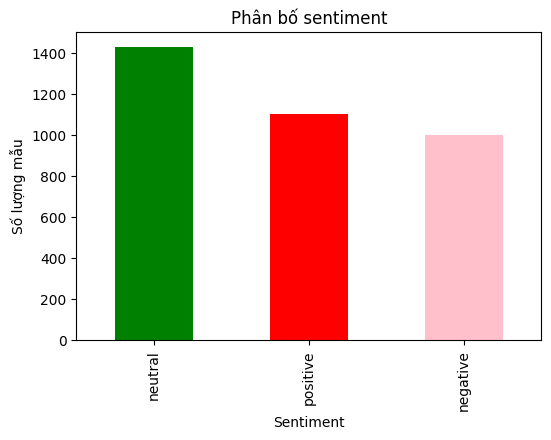

In [4]:
# Check the labels before removing
plt.figure(figsize=(6,4))
data["sentiment"].value_counts().plot(kind="bar", color=["green","red","pink"])
plt.title("Phân bố sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Số lượng mẫu")
plt.show()

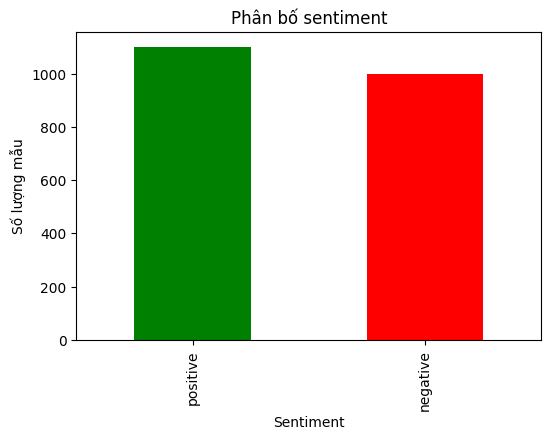

In [5]:
# Remove sentiment neutral for decreasing time predicting
data = data[data["sentiment"] != "neutral"]
# Check the labels after removing
plt.figure(figsize=(6,4))
data["sentiment"].value_counts().plot(kind="bar", color=["green","red","pink"])
plt.title("Phân bố sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Số lượng mẫu")
plt.show()

In [6]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

In [7]:
# Copy data for maintaining text
data["raw_text"] = data["text"]

# Preprocessed with NLTK library
data["clean_text"] = data["text"].astype(str).apply(clean_text)

# Print a sample for review
first_row = data.iloc[6]
print("=== Original Tweet ===")
print(first_row["text"])
print("\n=== Raw Text ===")
print(first_row["raw_text"])
print("\n=== Cleaned Text (NLTK) ===")
print(first_row["clean_text"])

=== Original Tweet ===
 soooooo wish i could, but im in school and myspace is completely blocked

=== Raw Text ===
 soooooo wish i could, but im in school and myspace is completely blocked

=== Cleaned Text (NLTK) ===
soooooo wish could im school myspace completely blocked


In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load Qwen3-4B-Instruct
model_name = "Qwen/Qwen3-4B-Instruct-2507"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

# Hàm phân loại sentiment
def classify_sentiment(text):
    messages = [
    {"role": "system", "content": "You are a sentiment analysis assistant. Only answer exactly 'positive' or 'negative' without explanation."},
    {"role": "user", "content": f'Classify the following tweet sentiment:\n\n"{text}"'}
    ]

    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True
    ).to(model.device)

    outputs = model.generate(**inputs, max_new_tokens=20)
    response = outputs[0][inputs["input_ids"].shape[-1]:]  # chỉ lấy phần model sinh
    return tokenizer.decode(response, skip_special_tokens=True).strip()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

2025-09-06 11:54:46.806114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757159686.996711      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757159687.046986      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [9]:
# Test trên raw và cleaned cho 1 sample
first_row = data.iloc[0]
raw_text = first_row["raw_text"]
clean_text = first_row["clean_text"]

print("=== RAW TEXT ===")
print(raw_text)
print("Predicted:", classify_sentiment(raw_text))

print("\n=== CLEANED TEXT ===")
print(clean_text)
print("Predicted:", classify_sentiment(clean_text))

=== RAW TEXT ===
 Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China:  (SH)  (BJ).
Predicted: positive

=== CLEANED TEXT ===
shanghai also really exciting precisely skyscraper galore good tweeps china sh bj
Predicted: positive


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2104 entries, 1 to 3533
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   textID      2104 non-null   object
 1   text        2104 non-null   object
 2   sentiment   2104 non-null   object
 3   raw_text    2104 non-null   object
 4   clean_text  2104 non-null   object
dtypes: object(5)
memory usage: 98.6+ KB


In [11]:
data_subset = data.head(1000)

results = []
total_samples = len(data_subset)

for i, (_, row) in enumerate(tqdm(data_subset.iterrows(), total=total_samples), start=1):
    raw_text = row["raw_text"]
    cleaned_text = row["clean_text"]
    true_sent = row["sentiment"]

    pred_raw = classify_sentiment(raw_text)
    pred_clean = classify_sentiment(cleaned_text)

    # Lưu kết quả vào list
    results.append({
        "textID": row["textID"],
        "raw_text": raw_text,
        "clean_text": cleaned_text,
        "sentiment": true_sent,
        "pred_raw": pred_raw,
        "pred_clean": pred_clean
    })

    # In ra kiểu sample i/n
    print(f"\n=== Sample {i}/{total_samples} ===")
    print("RAW TEXT:", raw_text)
    print("Predicted RAW:", pred_raw)
    print("CLEANED TEXT:", cleaned_text)
    print("Predicted CLEAN:", pred_clean)
    print("TRUE SENTIMENT:", true_sent)

# Chuyển sang DataFrame
df_results = pd.DataFrame(results)

# Accuracy
acc_raw = (df_results["pred_raw"] == df_results["sentiment"]).mean()
acc_clean = (df_results["pred_clean"] == df_results["sentiment"]).mean()
print(f"\nAccuracy (raw text): {acc_raw:.2%}")
print(f"Accuracy (clean text): {acc_clean:.2%}")

# Xuất CSV
df_results.to_csv("sentiment_predictions_1000.csv", index=False)


  0%|          | 1/1000 [00:01<30:14,  1.82s/it]


=== Sample 1/1000 ===
RAW TEXT:  Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China:  (SH)  (BJ).
Predicted RAW: positive
CLEANED TEXT: shanghai also really exciting precisely skyscraper galore good tweeps china sh bj
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  0%|          | 2/1000 [00:03<29:24,  1.77s/it]


=== Sample 2/1000 ===
RAW TEXT: Recession hit Veronique Branquinho, she has to quit her company, such a shame!
Predicted RAW: negative
CLEANED TEXT: recession hit veronique branquinho quit company shame
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  0%|          | 3/1000 [00:05<29:17,  1.76s/it]


=== Sample 3/1000 ===
RAW TEXT:  happy bday!
Predicted RAW: positive
CLEANED TEXT: happy bday
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  0%|          | 4/1000 [00:07<29:09,  1.76s/it]


=== Sample 4/1000 ===
RAW TEXT:  http://twitpic.com/4w75p - I like it!!
Predicted RAW: positive
CLEANED TEXT: like
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  0%|          | 5/1000 [00:08<28:58,  1.75s/it]


=== Sample 5/1000 ===
RAW TEXT:  that`s great!! weee!! visitors!
Predicted RAW: positive
CLEANED TEXT: thats great weee visitor
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  1%|          | 6/1000 [00:10<28:54,  1.74s/it]


=== Sample 6/1000 ===
RAW TEXT: I THINK EVERYONE HATES ME ON HERE   lol
Predicted RAW: negative
CLEANED TEXT: think everyone hate lol
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  1%|          | 7/1000 [00:12<28:49,  1.74s/it]


=== Sample 7/1000 ===
RAW TEXT:  soooooo wish i could, but im in school and myspace is completely blocked
Predicted RAW: negative
CLEANED TEXT: soooooo wish could im school myspace completely blocked
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  1%|          | 8/1000 [00:14<28:47,  1.74s/it]


=== Sample 8/1000 ===
RAW TEXT: My bike was put on hold...should have known that.... argh total bummer
Predicted RAW: negative
CLEANED TEXT: bike put holdshould known argh total bummer
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  1%|          | 9/1000 [00:15<29:22,  1.78s/it]


=== Sample 9/1000 ===
RAW TEXT: I`m in VA for the weekend, my youngest son turns 2 tomorrow......it makes me kinda sad, he is getting so big, check out my twipics
Predicted RAW: negative
CLEANED TEXT: im va weekend youngest son turn 2 tomorrowit make kinda sad getting big check twipics
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  1%|          | 10/1000 [00:17<29:35,  1.79s/it]


=== Sample 10/1000 ===
RAW TEXT: Its coming out the socket  I feel like my phones hole is not a virgin. That`s how loose it is... :`(
Predicted RAW: negative
CLEANED TEXT: coming socket feel like phone hole virgin thats loose
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  1%|          | 11/1000 [00:19<29:18,  1.78s/it]


=== Sample 11/1000 ===
RAW TEXT: So hot today =_=  don`t like it and i hate my new timetable, having such a bad week
Predicted RAW: negative
CLEANED TEXT: hot today dont like hate new timetable bad week
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  1%|          | 12/1000 [00:21<29:04,  1.77s/it]


=== Sample 12/1000 ===
RAW TEXT:  Miss you
Predicted RAW: positive
CLEANED TEXT: miss
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  1%|▏         | 13/1000 [00:22<28:54,  1.76s/it]


=== Sample 13/1000 ===
RAW TEXT: Cramps . . .
Predicted RAW: negative
CLEANED TEXT: cramp
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  1%|▏         | 14/1000 [00:24<28:52,  1.76s/it]


=== Sample 14/1000 ===
RAW TEXT:  you guys didn`t say hi or answer my questions yesterday  but nice songs.
Predicted RAW: negative
CLEANED TEXT: guy didnt say hi answer question yesterday nice song
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  2%|▏         | 15/1000 [00:26<28:48,  1.75s/it]


=== Sample 15/1000 ===
RAW TEXT: Stupid storm. No river for us tonight
Predicted RAW: negative
CLEANED TEXT: stupid storm river u tonight
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  2%|▏         | 16/1000 [00:28<28:42,  1.75s/it]


=== Sample 16/1000 ===
RAW TEXT: My dead grandpa pays more attention to me than you do
Predicted RAW: negative
CLEANED TEXT: dead grandpa pay attention
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  2%|▏         | 17/1000 [00:29<28:40,  1.75s/it]


=== Sample 17/1000 ===
RAW TEXT: ... need retail therapy, bad. AHHH.....gimme money geebus
Predicted RAW: negative
CLEANED TEXT: need retail therapy bad ahhhgimme money geebus
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  2%|▏         | 18/1000 [00:31<28:36,  1.75s/it]


=== Sample 18/1000 ===
RAW TEXT:  you are lame  go make me breakfast!!
Predicted RAW: negative
CLEANED TEXT: lame go make breakfast
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  2%|▏         | 19/1000 [00:33<28:33,  1.75s/it]


=== Sample 19/1000 ===
RAW TEXT:  thats so cool
Predicted RAW: positive
CLEANED TEXT: thats cool
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  2%|▏         | 20/1000 [00:35<28:29,  1.74s/it]


=== Sample 20/1000 ===
RAW TEXT:  look who I found just for you  --->  http://twitter.com/DJT2009
Predicted RAW: positive
CLEANED TEXT: look found
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  2%|▏         | 21/1000 [00:36<28:23,  1.74s/it]


=== Sample 21/1000 ===
RAW TEXT: No AC, the fan doesnt swing our way ... we are sweating it out on a hot humid day
Predicted RAW: negative
CLEANED TEXT: ac fan doesnt swing way sweating hot humid day
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  2%|▏         | 22/1000 [00:38<28:18,  1.74s/it]


=== Sample 22/1000 ===
RAW TEXT: Watching Body of Lies...good film
Predicted RAW: positive
CLEANED TEXT: watching body liesgood film
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  2%|▏         | 23/1000 [00:40<28:13,  1.73s/it]


=== Sample 23/1000 ===
RAW TEXT: Happy mothers day mumm  xoxo
Predicted RAW: positive
CLEANED TEXT: happy mother day mumm xoxo
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  2%|▏         | 24/1000 [00:42<28:18,  1.74s/it]


=== Sample 24/1000 ===
RAW TEXT:  I`m sorry  at least it`s Friday?
Predicted RAW: negative
CLEANED TEXT: im sorry least friday
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  2%|▎         | 25/1000 [00:43<28:19,  1.74s/it]


=== Sample 25/1000 ===
RAW TEXT: feels sorry every time I`m printing out, I use like 200 new papers
Predicted RAW: negative
CLEANED TEXT: feel sorry every time im printing use like 200 new paper
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  3%|▎         | 26/1000 [00:45<28:25,  1.75s/it]


=== Sample 26/1000 ===
RAW TEXT:  4n? ma rog  never heard of it  esti beat acum? u tweet too much
Predicted RAW: negative
CLEANED TEXT: 4n rog never heard esti beat acum u tweet much
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  3%|▎         | 27/1000 [00:47<28:18,  1.75s/it]


=== Sample 27/1000 ===
RAW TEXT:  Hi there.  I agree!  Small children should be running about happy, not breaking down in tears
Predicted RAW: positive
CLEANED TEXT: hi agree small child running happy breaking tear
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  3%|▎         | 28/1000 [00:49<28:10,  1.74s/it]


=== Sample 28/1000 ===
RAW TEXT:   Hope ur havin fun in da club
Predicted RAW: positive
CLEANED TEXT: hope ur havin fun da club
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  3%|▎         | 29/1000 [00:50<28:08,  1.74s/it]


=== Sample 29/1000 ===
RAW TEXT: thinks SG is wonderful
Predicted RAW: positive
CLEANED TEXT: think sg wonderful
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  3%|▎         | 30/1000 [00:52<28:09,  1.74s/it]


=== Sample 30/1000 ===
RAW TEXT:   im really sorry i know wallah how u feel this life is shittttttttt
Predicted RAW: negative
CLEANED TEXT: im really sorry know wallah u feel life shittttttttt
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  3%|▎         | 31/1000 [00:54<28:11,  1.75s/it]


=== Sample 31/1000 ===
RAW TEXT: Not happy
Predicted RAW: negative
CLEANED TEXT: happy
Predicted CLEAN: positive
TRUE SENTIMENT: negative


  3%|▎         | 32/1000 [00:56<28:15,  1.75s/it]


=== Sample 32/1000 ===
RAW TEXT: I`m so very tired...and have insomnia.
Predicted RAW: negative
CLEANED TEXT: im tiredand insomnia
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  3%|▎         | 33/1000 [00:57<28:09,  1.75s/it]


=== Sample 33/1000 ===
RAW TEXT:  Thanks Ennio
Predicted RAW: positive
CLEANED TEXT: thanks ennio
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  3%|▎         | 34/1000 [00:59<28:09,  1.75s/it]


=== Sample 34/1000 ===
RAW TEXT:  You seem nice, you`re generous and you know your stuff
Predicted RAW: positive
CLEANED TEXT: seem nice youre generous know stuff
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  4%|▎         | 35/1000 [01:01<28:09,  1.75s/it]


=== Sample 35/1000 ===
RAW TEXT:    Caladesi was definitely a nice peaceful way to spend a Sunday! I got a lil tan!
Predicted RAW: positive
CLEANED TEXT: caladesi definitely nice peaceful way spend sunday got lil tan
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  4%|▎         | 36/1000 [01:03<28:10,  1.75s/it]


=== Sample 36/1000 ===
RAW TEXT: Dear rain, you suck. Now I gotta change my plans for tonight
Predicted RAW: negative
CLEANED TEXT: dear rain suck got ta change plan tonight
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  4%|▎         | 37/1000 [01:04<28:10,  1.76s/it]


=== Sample 37/1000 ===
RAW TEXT: I just cried whilst watching hollyoaks  .. i need a life! lol
Predicted RAW: negative
CLEANED TEXT: cried whilst watching hollyoaks need life lol
Predicted CLEAN: positive
TRUE SENTIMENT: negative


  4%|▍         | 38/1000 [01:06<28:35,  1.78s/it]


=== Sample 38/1000 ===
RAW TEXT: Hi all, just recovering from a party, looking forward to an exciting bank holiday around the diy shops...life cant get much better.surely
Predicted RAW: positive
CLEANED TEXT: hi recovering party looking forward exciting bank holiday around diy shopslife cant get much bettersurely
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  4%|▍         | 39/1000 [01:08<28:47,  1.80s/it]


=== Sample 39/1000 ===
RAW TEXT:  for...the...loss. dumbface  ...him, not u. what u up to on the wknd? i wanna seeeeeee ya!
Predicted RAW: positive
CLEANED TEXT: fortheloss dumbface u u wknd wan na seeeeeee ya
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  4%|▍         | 40/1000 [01:10<28:31,  1.78s/it]


=== Sample 40/1000 ===
RAW TEXT: On the monday, so i wont be able to be with you!  i love you
Predicted RAW: positive
CLEANED TEXT: monday wont able love
Predicted CLEAN: negative
TRUE SENTIMENT: positive


  4%|▍         | 41/1000 [01:12<28:43,  1.80s/it]


=== Sample 41/1000 ===
RAW TEXT:  Ur so cute..I`m a fan of Dream A Little Dream, This Kiss and appearances like in Dawson`s Creek  Make more flicks!
Predicted RAW: positive
CLEANED TEXT: ur cuteim fan dream little dream kiss appearance like dawson creek make flick
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  4%|▍         | 42/1000 [01:13<28:23,  1.78s/it]


=== Sample 42/1000 ===
RAW TEXT: _LaMont yr very young looking dude
Predicted RAW: positive
CLEANED TEXT: lamont yr young looking dude
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  4%|▍         | 43/1000 [01:15<28:14,  1.77s/it]


=== Sample 43/1000 ===
RAW TEXT: : hmmm, wrong link, ignore my tweet
Predicted RAW: negative
CLEANED TEXT: hmmm wrong link ignore tweet
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  4%|▍         | 44/1000 [01:17<28:05,  1.76s/it]


=== Sample 44/1000 ===
RAW TEXT: AT&T cheated the system and now I have no Green Day tickets  **** you AT&T!
Predicted RAW: negative
CLEANED TEXT: att cheated system green day ticket att
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  4%|▍         | 45/1000 [01:19<27:57,  1.76s/it]


=== Sample 45/1000 ===
RAW TEXT: Tracy and Berwick breaks my achy breaky heart  They split ways in the hallways.
Predicted RAW: negative
CLEANED TEXT: tracy berwick break achy breaky heart split way hallway
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  5%|▍         | 46/1000 [01:20<27:48,  1.75s/it]


=== Sample 46/1000 ===
RAW TEXT:  yep, i wish they were all playing dubiln
Predicted RAW: negative
CLEANED TEXT: yep wish playing dubiln
Predicted CLEAN: negative
TRUE SENTIMENT: positive


  5%|▍         | 47/1000 [01:22<28:06,  1.77s/it]


=== Sample 47/1000 ===
RAW TEXT:  Yay for Block Party!  You`re the BOMB! Blockheads <3 Dave!   Thanks for supporting NKOTB!
Predicted RAW: positive
CLEANED TEXT: yay block party youre bomb blockhead 3 dave thanks supporting nkotb
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  5%|▍         | 48/1000 [01:24<27:59,  1.76s/it]


=== Sample 48/1000 ===
RAW TEXT: Happy Birthday Snickers!!!! ? I hope you have the best day ever! Let`s go shopping!!!
Predicted RAW: positive
CLEANED TEXT: happy birthday snicker hope best day ever let go shopping
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  5%|▍         | 49/1000 [01:26<27:57,  1.76s/it]


=== Sample 49/1000 ===
RAW TEXT:  Thank you!  I`m working on `s
Predicted RAW: positive
CLEANED TEXT: thank im working
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  5%|▌         | 50/1000 [01:27<27:49,  1.76s/it]


=== Sample 50/1000 ===
RAW TEXT: Not feeling all that well today
Predicted RAW: negative
CLEANED TEXT: feeling well today
Predicted CLEAN: positive
TRUE SENTIMENT: negative


  5%|▌         | 51/1000 [01:29<28:07,  1.78s/it]


=== Sample 51/1000 ===
RAW TEXT: http://twitpic.com/4wp8s - My ear hurts, and THIS is my medicine. GUM
Predicted RAW: negative
CLEANED TEXT: ear hurt medicine gum
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  5%|▌         | 52/1000 [01:31<27:56,  1.77s/it]


=== Sample 52/1000 ===
RAW TEXT: The underwire in my bra is sticking out and poking me in the armpit
Predicted RAW: negative
CLEANED TEXT: underwire bra sticking poking armpit
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  5%|▌         | 53/1000 [01:33<27:46,  1.76s/it]


=== Sample 53/1000 ===
RAW TEXT: Happy Mothers Day!!!
Predicted RAW: positive
CLEANED TEXT: happy mother day
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  5%|▌         | 54/1000 [01:34<27:45,  1.76s/it]


=== Sample 54/1000 ===
RAW TEXT: Happy star wars day! May the fourth be with you
Predicted RAW: positive
CLEANED TEXT: happy star war day may fourth
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  6%|▌         | 55/1000 [01:36<27:44,  1.76s/it]


=== Sample 55/1000 ===
RAW TEXT: i just watched Marley & Me...i cried so hard!
Predicted RAW: positive
CLEANED TEXT: watched marley mei cried hard
Predicted CLEAN: positive
TRUE SENTIMENT: negative


  6%|▌         | 56/1000 [01:38<28:04,  1.78s/it]


=== Sample 56/1000 ===
RAW TEXT:  haaaw..well i get out of class at 10:50..i hope i make it
Predicted RAW: positive
CLEANED TEXT: haaawwell get class 1050i hope make
Predicted CLEAN: negative
TRUE SENTIMENT: positive


  6%|▌         | 57/1000 [01:40<28:17,  1.80s/it]


=== Sample 57/1000 ===
RAW TEXT: Just had a great study time followed by a delicious Japanese meal with Arty! Now, trying to get back into the study mood
Predicted RAW: positive
CLEANED TEXT: great study time followed delicious japanese meal arty trying get back study mood
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  6%|▌         | 58/1000 [01:42<27:54,  1.78s/it]


=== Sample 58/1000 ===
RAW TEXT: FML not having a car is prohibiting finding a job
Predicted RAW: negative
CLEANED TEXT: fml car prohibiting finding job
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  6%|▌         | 59/1000 [01:43<27:39,  1.76s/it]


=== Sample 59/1000 ===
RAW TEXT:  I want to see David cook!!
Predicted RAW: positive
CLEANED TEXT: want see david cook
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  6%|▌         | 60/1000 [01:45<28:01,  1.79s/it]


=== Sample 60/1000 ===
RAW TEXT:  yeah i need his fricken cell number ive tried his home for months and hes too busy. i miss braddddddddd
Predicted RAW: negative
CLEANED TEXT: yeah need fricken cell number ive tried home month he busy miss braddddddddd
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  6%|▌         | 61/1000 [01:47<27:47,  1.78s/it]


=== Sample 61/1000 ===
RAW TEXT:  yay about breaking 200!
Predicted RAW: positive
CLEANED TEXT: yay breaking 200
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  6%|▌         | 62/1000 [01:49<27:36,  1.77s/it]


=== Sample 62/1000 ===
RAW TEXT:  bahah sadly I am not
Predicted RAW: negative
CLEANED TEXT: bahah sadly
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  6%|▋         | 63/1000 [01:50<27:25,  1.76s/it]


=== Sample 63/1000 ===
RAW TEXT:  i always have those for my Champions League parties  Tis awesome
Predicted RAW: positive
CLEANED TEXT: always champion league party ti awesome
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  6%|▋         | 64/1000 [01:52<27:49,  1.78s/it]


=== Sample 64/1000 ===
RAW TEXT:  well, not all. just stay away from those kinds and surround yourself with those who don`t. happy mother`s day to ur mom, treiz!
Predicted RAW: positive
CLEANED TEXT: well stay away kind surround dont happy mother day ur mom treiz
Predicted CLEAN: negative
TRUE SENTIMENT: positive


  6%|▋         | 65/1000 [01:54<28:10,  1.81s/it]


=== Sample 65/1000 ===
RAW TEXT:  thats rough. hubby had knee surgery but it did help him in the end. Let us know the results. We`ll keep him in our prayers
Predicted RAW: positive
CLEANED TEXT: thats rough hubby knee surgery help end let u know result well keep prayer
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  7%|▋         | 66/1000 [01:56<27:57,  1.80s/it]


=== Sample 66/1000 ===
RAW TEXT: Playin City of Villains, wishin my buddies were playin with me.....
Predicted RAW: positive
CLEANED TEXT: playin city villain wishin buddy playin
Predicted CLEAN: negative
TRUE SENTIMENT: positive


  7%|▋         | 67/1000 [01:58<28:07,  1.81s/it]


=== Sample 67/1000 ===
RAW TEXT:  yep - three things: a good haircut, the ability to listen and the value of not taking yourself too seriously
Predicted RAW: positive
CLEANED TEXT: yep three thing good haircut ability listen value taking seriously
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  7%|▋         | 68/1000 [01:59<27:48,  1.79s/it]


=== Sample 68/1000 ===
RAW TEXT:  I liked it.  Did you record it yourself?  If so you have a very soothing voice.
Predicted RAW: positive
CLEANED TEXT: liked record soothing voice
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  7%|▋         | 69/1000 [02:01<27:58,  1.80s/it]


=== Sample 69/1000 ===
RAW TEXT:  Folks thought it was hilarious when I told them the story, and then they saw the shirt I wore tonight.  Laughter all night.
Predicted RAW: positive
CLEANED TEXT: folk thought hilarious told story saw shirt wore tonight laughter night
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  7%|▋         | 70/1000 [02:03<27:46,  1.79s/it]


=== Sample 70/1000 ===
RAW TEXT:  you`re the absoute best
Predicted RAW: positive
CLEANED TEXT: youre absoute best
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  7%|▋         | 71/1000 [02:05<27:35,  1.78s/it]


=== Sample 71/1000 ===
RAW TEXT:  Welcome!
Predicted RAW: positive
CLEANED TEXT: welcome
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  7%|▋         | 72/1000 [02:07<27:25,  1.77s/it]


=== Sample 72/1000 ===
RAW TEXT: just got home from a nice party, just not tired yet
Predicted RAW: positive
CLEANED TEXT: got home nice party tired yet
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  7%|▋         | 73/1000 [02:08<27:15,  1.76s/it]


=== Sample 73/1000 ===
RAW TEXT: Now I have a sunburn
Predicted RAW: negative
CLEANED TEXT: sunburn
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  7%|▋         | 74/1000 [02:10<27:08,  1.76s/it]


=== Sample 74/1000 ===
RAW TEXT: I have the Job  this is a nice day it can not be better
Predicted RAW: positive
CLEANED TEXT: job nice day better
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  8%|▊         | 75/1000 [02:12<27:01,  1.75s/it]


=== Sample 75/1000 ===
RAW TEXT: I wish I could go to #BEA this weekend.
Predicted RAW: positive
CLEANED TEXT: wish could go bea weekend
Predicted CLEAN: negative
TRUE SENTIMENT: positive


  8%|▊         | 76/1000 [02:14<26:55,  1.75s/it]


=== Sample 76/1000 ===
RAW TEXT:  love your books
Predicted RAW: positive
CLEANED TEXT: love book
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  8%|▊         | 77/1000 [02:15<27:22,  1.78s/it]


=== Sample 77/1000 ===
RAW TEXT: ok so this eye doctor guy is taking forever and i`m sitting in a cold room by myself...what? A jerk!
Predicted RAW: negative
CLEANED TEXT: ok eye doctor guy taking forever im sitting cold room myselfwhat jerk
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  8%|▊         | 78/1000 [02:17<27:13,  1.77s/it]


=== Sample 78/1000 ===
RAW TEXT: Im Slowing on My Tweets..Cuase I Lost My Phone
Predicted RAW: negative
CLEANED TEXT: im slowing tweetscuase lost phone
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  8%|▊         | 79/1000 [02:19<27:03,  1.76s/it]


=== Sample 79/1000 ===
RAW TEXT:  well thank your phone for me.
Predicted RAW: negative
CLEANED TEXT: well thank phone
Predicted CLEAN: negative
TRUE SENTIMENT: positive


  8%|▊         | 80/1000 [02:21<26:56,  1.76s/it]


=== Sample 80/1000 ===
RAW TEXT:  why would they take a photo with stuffed animals?! that`s pretty funny
Predicted RAW: positive
CLEANED TEXT: would take photo stuffed animal thats pretty funny
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  8%|▊         | 81/1000 [02:22<26:56,  1.76s/it]


=== Sample 81/1000 ===
RAW TEXT: tikcets are only ï¿½91...each...BUT I SO WANT TO GO
Predicted RAW: positive
CLEANED TEXT: tikcets ï¿½91eachbut want go
Predicted CLEAN: negative
TRUE SENTIMENT: positive


  8%|▊         | 82/1000 [02:24<26:53,  1.76s/it]


=== Sample 82/1000 ===
RAW TEXT:  Happy Mothers Day
Predicted RAW: positive
CLEANED TEXT: happy mother day
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  8%|▊         | 83/1000 [02:26<27:17,  1.79s/it]


=== Sample 83/1000 ===
RAW TEXT:  It`s gonna be hot here today too. today is Ryan`s last day of pre-k. I can`t believe it!  I`ve been a SAHM since I had him!
Predicted RAW: positive
CLEANED TEXT: gon na hot today today ryans last day prek cant believe ive sahm since
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  8%|▊         | 84/1000 [02:28<27:29,  1.80s/it]


=== Sample 84/1000 ===
RAW TEXT: Oh, **** me. I`ve just returned from the Supermarket Of Doom to find that I have nothing to drink here.
Predicted RAW: negative
CLEANED TEXT: oh ive returned supermarket doom find nothing drink
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  8%|▊         | 85/1000 [02:30<27:37,  1.81s/it]


=== Sample 85/1000 ===
RAW TEXT: D-group Saturday`s, with a little bit of football, an hour nap, 3 hours of soccer, basketball in the TSU and Yogurtland... Life`s Good
Predicted RAW: positive
CLEANED TEXT: dgroup saturday little bit football hour nap 3 hour soccer basketball tsu yogurtland life good
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  9%|▊         | 86/1000 [02:31<27:14,  1.79s/it]


=== Sample 86/1000 ===
RAW TEXT: just set up a new computer again. 15min. I love Norton Ghost.
Predicted RAW: positive
CLEANED TEXT: set new computer 15min love norton ghost
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  9%|▊         | 87/1000 [02:33<26:56,  1.77s/it]


=== Sample 87/1000 ===
RAW TEXT: Ahhh my mommie got me new sheets for my bed  so comfy
Predicted RAW: positive
CLEANED TEXT: ahhh mommie got new sheet bed comfy
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  9%|▉         | 88/1000 [02:35<26:55,  1.77s/it]


=== Sample 88/1000 ===
RAW TEXT: is pretty dang tired. but chambers class is for napping.
Predicted RAW: negative
CLEANED TEXT: pretty dang tired chamber class napping
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  9%|▉         | 89/1000 [02:37<26:44,  1.76s/it]


=== Sample 89/1000 ===
RAW TEXT: i have to poop...   is hogging the shitter
Predicted RAW: negative
CLEANED TEXT: poop hogging shitter
Predicted CLEAN: negative
TRUE SENTIMENT: negative


  9%|▉         | 90/1000 [02:38<26:36,  1.75s/it]


=== Sample 90/1000 ===
RAW TEXT: Happy muthath`s day to all moms!!! I salute you!
Predicted RAW: positive
CLEANED TEXT: happy muthaths day mom salute
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  9%|▉         | 91/1000 [02:40<26:30,  1.75s/it]


=== Sample 91/1000 ===
RAW TEXT: Hahaha! Alright  ..
Predicted RAW: positive
CLEANED TEXT: hahaha alright
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  9%|▉         | 92/1000 [02:42<26:26,  1.75s/it]


=== Sample 92/1000 ===
RAW TEXT:  Aren`t you suppossed to support the local economy ... LOL ... good for you and congrats
Predicted RAW: positive
CLEANED TEXT: arent suppossed support local economy lol good congrats
Predicted CLEAN: negative
TRUE SENTIMENT: positive


  9%|▉         | 93/1000 [02:44<26:22,  1.74s/it]


=== Sample 93/1000 ===
RAW TEXT:  good to know   thanks
Predicted RAW: positive
CLEANED TEXT: good know thanks
Predicted CLEAN: positive
TRUE SENTIMENT: positive


  9%|▉         | 94/1000 [02:45<26:52,  1.78s/it]


=== Sample 94/1000 ===
RAW TEXT:  E.L.O.  wow, brings back so many happy memories.  LOVE this band!..and yes, I know I`m showing my age but I don`t care
Predicted RAW: positive
CLEANED TEXT: elo wow brings back many happy memory love bandand yes know im showing age dont care
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 10%|▉         | 95/1000 [02:47<27:07,  1.80s/it]


=== Sample 95/1000 ===
RAW TEXT:  that`s a very cute picture ... but you don`t get fat from licking BBQs ... he must have found some chops on someone else`s ...
Predicted RAW: positive
CLEANED TEXT: thats cute picture dont get fat licking bbqs must found chop someone elses
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 10%|▉         | 96/1000 [02:49<26:56,  1.79s/it]


=== Sample 96/1000 ===
RAW TEXT:  oh i love sunday mornings like this - mum just made scrambled eggs on toast
Predicted RAW: positive
CLEANED TEXT: oh love sunday morning like mum made scrambled egg toast
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 10%|▉         | 97/1000 [02:51<26:41,  1.77s/it]


=== Sample 97/1000 ===
RAW TEXT: hate working when its sunny,boohoo
Predicted RAW: negative
CLEANED TEXT: hate working sunnyboohoo
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 10%|▉         | 98/1000 [02:53<26:31,  1.76s/it]


=== Sample 98/1000 ===
RAW TEXT: Wondering if i cld make things any worse than they already are... answer.. JUST DID!!!
Predicted RAW: negative
CLEANED TEXT: wondering cld make thing worse already answer
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 10%|▉         | 99/1000 [02:54<26:28,  1.76s/it]


=== Sample 99/1000 ===
RAW TEXT: Twitter has spoiled all the fun. Frustratingly slow!!  couldnt even bid properly!
Predicted RAW: negative
CLEANED TEXT: twitter spoiled fun frustratingly slow couldnt even bid properly
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 10%|█         | 100/1000 [02:56<26:26,  1.76s/it]


=== Sample 100/1000 ===
RAW TEXT: _chick haha. I completely agree
Predicted RAW: positive
CLEANED TEXT: chick haha completely agree
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 10%|█         | 101/1000 [02:58<26:39,  1.78s/it]


=== Sample 101/1000 ===
RAW TEXT: Going to bed after a great night with a friend  glad to know she has the same feelings about classes as someone else
Predicted RAW: positive
CLEANED TEXT: going bed great night friend glad know feeling class someone else
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 10%|█         | 102/1000 [03:00<26:51,  1.80s/it]


=== Sample 102/1000 ===
RAW TEXT:  many! mine included. ahem. shld have known better back then, wldn`t have missed so many opportunities haha
Predicted RAW: positive
CLEANED TEXT: many mine included ahem shld known better back wldnt missed many opportunity haha
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 10%|█         | 103/1000 [03:01<26:35,  1.78s/it]


=== Sample 103/1000 ===
RAW TEXT: it`s nice to leave the office when the sun is still up
Predicted RAW: positive
CLEANED TEXT: nice leave office sun still
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 10%|█         | 104/1000 [03:03<26:27,  1.77s/it]


=== Sample 104/1000 ===
RAW TEXT: I will miss the soccer moms
Predicted RAW: negative
CLEANED TEXT: miss soccer mom
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 10%|█         | 105/1000 [03:05<26:21,  1.77s/it]


=== Sample 105/1000 ===
RAW TEXT: just watched yes man. bahaha. that movie is messed up
Predicted RAW: positive
CLEANED TEXT: watched yes man bahaha movie messed
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 11%|█         | 106/1000 [03:07<26:39,  1.79s/it]


=== Sample 106/1000 ===
RAW TEXT:  Sadly I think I know exactly were you put it--in the expired drawer   Those things have a life span of less than two years
Predicted RAW: negative
CLEANED TEXT: sadly think know exactly put itin expired drawer thing life span less two year
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 11%|█         | 107/1000 [03:09<26:29,  1.78s/it]


=== Sample 107/1000 ===
RAW TEXT:  Too much? No, not unless one of the pillows ends up suffocating the one sleeping next to you.
Predicted RAW: positive
CLEANED TEXT: much unless one pillow end suffocating one sleeping next
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 11%|█         | 108/1000 [03:10<26:20,  1.77s/it]


=== Sample 108/1000 ===
RAW TEXT: Wow that was fast...next up Soderling or Ferrer. Gilles Simon lost
Predicted RAW: positive
CLEANED TEXT: wow fastnext soderling ferrer gilles simon lost
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 11%|█         | 109/1000 [03:12<26:11,  1.76s/it]


=== Sample 109/1000 ===
RAW TEXT:  glad to know that the ad display problem was due to a firewall config at yr office. phew!
Predicted RAW: positive
CLEANED TEXT: glad know ad display problem due firewall config yr office phew
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 11%|█         | 110/1000 [03:14<26:03,  1.76s/it]


=== Sample 110/1000 ===
RAW TEXT:  woot!
Predicted RAW: positive
CLEANED TEXT: woot
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 11%|█         | 111/1000 [03:16<26:02,  1.76s/it]


=== Sample 111/1000 ===
RAW TEXT: Happy #StarWarsDay. May the 4th be with you!  From everyone _paintball
Predicted RAW: positive
CLEANED TEXT: happy starwarsday may 4th everyone paintball
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 11%|█         | 112/1000 [03:17<25:53,  1.75s/it]


=== Sample 112/1000 ===
RAW TEXT: St joe is dirty.
Predicted RAW: negative
CLEANED TEXT: st joe dirty
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 11%|█▏        | 113/1000 [03:19<25:53,  1.75s/it]


=== Sample 113/1000 ===
RAW TEXT: I hate my life
Predicted RAW: negative
CLEANED TEXT: hate life
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 11%|█▏        | 114/1000 [03:21<25:53,  1.75s/it]


=== Sample 114/1000 ===
RAW TEXT: sick to my stomach.. and i have a headache.. i wish someone could come rub my temples.
Predicted RAW: negative
CLEANED TEXT: sick stomach headache wish someone could come rub temple
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 12%|█▏        | 115/1000 [03:23<26:15,  1.78s/it]


=== Sample 115/1000 ===
RAW TEXT:  ****! natalya! you gotta tell me whats going on!!! i`d call you but i lost all my phone numbers when i broke my blackberry
Predicted RAW: positive
CLEANED TEXT: natalya got ta tell whats going id call lost phone number broke blackberry
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 12%|█▏        | 116/1000 [03:24<26:13,  1.78s/it]


=== Sample 116/1000 ===
RAW TEXT: just thought about how unfair 3 ppl have been 2 me n got depressed again  HATERS!!!
Predicted RAW: negative
CLEANED TEXT: thought unfair 3 ppl 2 n got depressed hater
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 12%|█▏        | 117/1000 [03:26<26:07,  1.77s/it]


=== Sample 117/1000 ===
RAW TEXT: crying real tears
Predicted RAW: negative
CLEANED TEXT: cry real tear
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 12%|█▏        | 118/1000 [03:28<26:02,  1.77s/it]


=== Sample 118/1000 ===
RAW TEXT:  Panchito`s burfday party tonight... wish you were here kiddo!
Predicted RAW: positive
CLEANED TEXT: panchitos burfday party tonight wish kiddo
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 12%|█▏        | 119/1000 [03:30<25:55,  1.77s/it]


=== Sample 119/1000 ===
RAW TEXT: the best things in life are free  x
Predicted RAW: positive
CLEANED TEXT: best thing life free x
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 12%|█▏        | 120/1000 [03:32<26:08,  1.78s/it]


=== Sample 120/1000 ===
RAW TEXT: misses my Mom today. She was my Best Friend and even though she has been gone several yrs I still miss her dearly. Happy Mother`s Day
Predicted RAW: positive
CLEANED TEXT: miss mom today best friend even though gone several yr still miss dearly happy mother day
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 12%|█▏        | 121/1000 [03:33<26:18,  1.80s/it]


=== Sample 121/1000 ===
RAW TEXT: I am watching Blood + on veoh episode 19 love the music.wishing i could watch the live action but not old enough
Predicted RAW: positive
CLEANED TEXT: watching blood veoh episode 19 love musicwishing could watch live action old enough
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 12%|█▏        | 122/1000 [03:35<26:11,  1.79s/it]


=== Sample 122/1000 ===
RAW TEXT:  that is a bummer
Predicted RAW: negative
CLEANED TEXT: bummer
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 12%|█▏        | 123/1000 [03:37<25:59,  1.78s/it]


=== Sample 123/1000 ===
RAW TEXT: http://twitpic.com/665jw The racoons ate our bread!
Predicted RAW: negative
CLEANED TEXT: racoon ate bread
Predicted CLEAN: neutral
TRUE SENTIMENT: negative


 12%|█▏        | 124/1000 [03:39<25:46,  1.77s/it]


=== Sample 124/1000 ===
RAW TEXT: Be sure to let the moms you know how fabulous you think they are!!   Almost Mother`s Day.
Predicted RAW: positive
CLEANED TEXT: sure let mom know fabulous think almost mother day
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 12%|█▎        | 125/1000 [03:40<25:41,  1.76s/it]


=== Sample 125/1000 ===
RAW TEXT: No launch today. Teacher changed plans and we watched a stupid move about tesla
Predicted RAW: negative
CLEANED TEXT: launch today teacher changed plan watched stupid move tesla
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 13%|█▎        | 126/1000 [03:42<25:31,  1.75s/it]


=== Sample 126/1000 ===
RAW TEXT:   it`s very pleasant. i sooo rarely just have time to kill...
Predicted RAW: positive
CLEANED TEXT: pleasant sooo rarely time kill
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 13%|█▎        | 127/1000 [03:44<25:57,  1.78s/it]


=== Sample 127/1000 ===
RAW TEXT:  thank you!! ooh I see you`ve read Desert Islands http://is.gd/ys6K great book!
Predicted RAW: positive
CLEANED TEXT: thank ooh see youve read desert island great book
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 13%|█▎        | 128/1000 [03:46<25:47,  1.77s/it]


=== Sample 128/1000 ===
RAW TEXT: __O lol but tiz a good song
Predicted RAW: positive
CLEANED TEXT: lol tiz good song
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 13%|█▎        | 129/1000 [03:48<26:00,  1.79s/it]


=== Sample 129/1000 ===
RAW TEXT: @_Anix_ I bought cheesecake ice cream last week, thinking it was good, and it sucked so much.   I`m taking yours.
Predicted RAW: negative
CLEANED TEXT: anix bought cheesecake ice cream last week thinking good sucked much im taking
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 13%|█▎        | 130/1000 [03:49<25:49,  1.78s/it]


=== Sample 130/1000 ===
RAW TEXT: _Wright THANK YOU! 'Return of the Mack' is THE jam!
Predicted RAW: positive
CLEANED TEXT: wright thank return mack jam
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 13%|█▎        | 131/1000 [03:51<25:38,  1.77s/it]


=== Sample 131/1000 ===
RAW TEXT: Ready for this saddenning depressing dullful upsetting dreadful weekend.
Predicted RAW: negative
CLEANED TEXT: ready saddenning depressing dullful upsetting dreadful weekend
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 13%|█▎        | 132/1000 [03:53<25:30,  1.76s/it]


=== Sample 132/1000 ===
RAW TEXT: sorry for my lack of tweets  ive been buzy. new vid this saturday!!
Predicted RAW: positive
CLEANED TEXT: sorry lack tweet ive buzy new vid saturday
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 13%|█▎        | 133/1000 [03:55<25:50,  1.79s/it]


=== Sample 133/1000 ===
RAW TEXT:  I do my humble best  Going on a works paintball day soon so that should fuel a few strips, no doubt
Predicted RAW: positive
CLEANED TEXT: humble best going work paintball day soon fuel strip doubt
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 13%|█▎        | 134/1000 [03:56<25:40,  1.78s/it]


=== Sample 134/1000 ===
RAW TEXT: going to bed  cant take thiss any longeerr maan. [U]
Predicted RAW: negative
CLEANED TEXT: going bed cant take thiss longeerr maan u
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 14%|█▎        | 135/1000 [03:58<25:50,  1.79s/it]


=== Sample 135/1000 ===
RAW TEXT: _Morden ..be at richard`s. if not then i`ll see you when you/we get back  good luck!
Predicted RAW: positive
CLEANED TEXT: morden richards ill see youwe get back good luck
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 14%|█▎        | 136/1000 [04:00<25:40,  1.78s/it]


=== Sample 136/1000 ===
RAW TEXT: Spent the last hour signing yearbooks. I`ll miss you guys!
Predicted RAW: positive
CLEANED TEXT: spent last hour signing yearbook ill miss guy
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 14%|█▎        | 137/1000 [04:02<25:29,  1.77s/it]


=== Sample 137/1000 ===
RAW TEXT: And I just love every little thing about you...
Predicted RAW: positive
CLEANED TEXT: love every little thing
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 14%|█▍        | 138/1000 [04:03<25:18,  1.76s/it]


=== Sample 138/1000 ===
RAW TEXT: My mobile has stopped recieving text messages AGAIN. Stoooopid thing
Predicted RAW: negative
CLEANED TEXT: mobile stopped recieving text message stoooopid thing
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 14%|█▍        | 139/1000 [04:05<25:10,  1.75s/it]


=== Sample 139/1000 ===
RAW TEXT: Had an amazing night with my favorite lady friend
Predicted RAW: positive
CLEANED TEXT: amazing night favorite lady friend
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 14%|█▍        | 140/1000 [04:07<25:05,  1.75s/it]


=== Sample 140/1000 ===
RAW TEXT: _Oyler Poor little woman with her smushed in head
Predicted RAW: negative
CLEANED TEXT: oyler poor little woman smushed head
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 14%|█▍        | 141/1000 [04:09<25:02,  1.75s/it]


=== Sample 141/1000 ===
RAW TEXT: is fixin to clean the house for my mom for mother`s day
Predicted RAW: positive
CLEANED TEXT: fixin clean house mom mother day
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 14%|█▍        | 142/1000 [04:10<24:57,  1.75s/it]


=== Sample 142/1000 ===
RAW TEXT:  Hey! That`s my school! I hate that place.
Predicted RAW: negative
CLEANED TEXT: hey thats school hate place
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 14%|█▍        | 143/1000 [04:12<24:56,  1.75s/it]


=== Sample 143/1000 ===
RAW TEXT:  i did i only got 3 stars on the pre wash then failed the rince
Predicted RAW: negative
CLEANED TEXT: got 3 star pre wash failed rince
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 14%|█▍        | 144/1000 [04:14<25:19,  1.77s/it]


=== Sample 144/1000 ===
RAW TEXT: MY SiSTER iN LAW JUST LEFT FOR HER PROM!! SHE LOOKED SOO PRETTY.. TEARS ALL AROUND
Predicted RAW: positive
CLEANED TEXT: sister law left prom looked soo pretty tear around
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 14%|█▍        | 145/1000 [04:16<25:35,  1.80s/it]


=== Sample 145/1000 ===
RAW TEXT: I`m really bored! My brother went to get his permit! Stay off the roads! Jk lol! It feels like all my friends have abandoned me! Except 1
Predicted RAW: negative
CLEANED TEXT: im really bored brother went get permit stay road jk lol feel like friend abandoned except 1
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 15%|█▍        | 146/1000 [04:18<25:19,  1.78s/it]


=== Sample 146/1000 ===
RAW TEXT: , goodnight
Predicted RAW: positive
CLEANED TEXT: goodnight
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 15%|█▍        | 147/1000 [04:19<25:32,  1.80s/it]


=== Sample 147/1000 ===
RAW TEXT: _The_Moon Hiya hun! It`s just not my day. Dentist appointment (ouch!),notebook being a ****. Feeling sick  How`s you?
Predicted RAW: negative
CLEANED TEXT: themoon hiya hun day dentist appointment ouchnotebook feeling sick hows
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 15%|█▍        | 148/1000 [04:21<25:17,  1.78s/it]


=== Sample 148/1000 ===
RAW TEXT:  but i do emily ahahha you scare me, so it would work
Predicted RAW: positive
CLEANED TEXT: emily ahahha scare would work
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 15%|█▍        | 149/1000 [04:23<25:03,  1.77s/it]


=== Sample 149/1000 ===
RAW TEXT: should not have waled past the Quad! I want to be outside having fun.
Predicted RAW: positive
CLEANED TEXT: waled past quad want outside fun
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 15%|█▌        | 150/1000 [04:25<24:59,  1.76s/it]


=== Sample 150/1000 ===
RAW TEXT: i think the food i ate made me sick.. i no feel so good
Predicted RAW: negative
CLEANED TEXT: think food ate made sick feel good
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 15%|█▌        | 151/1000 [04:27<25:17,  1.79s/it]


=== Sample 151/1000 ===
RAW TEXT: Lots of tasks to complete today. First, wecloming new members to Canadamigos Social Networking site, www.canadamigos.com, and coffee
Predicted RAW: positive
CLEANED TEXT: lot task complete today first wecloming new member canadamigos social networking site coffee
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 15%|█▌        | 152/1000 [04:28<25:04,  1.77s/it]


=== Sample 152/1000 ===
RAW TEXT: Just wants to stay in bed all day but has to go to work instead  sux
Predicted RAW: negative
CLEANED TEXT: want stay bed day go work instead sux
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 15%|█▌        | 153/1000 [04:30<24:51,  1.76s/it]


=== Sample 153/1000 ===
RAW TEXT: chillen trying to figure this thing out gettin drunk
Predicted RAW: negative
CLEANED TEXT: chillen trying figure thing gettin drunk
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 15%|█▌        | 154/1000 [04:32<25:09,  1.78s/it]


=== Sample 154/1000 ===
RAW TEXT: Filming at a carnival for my music video... It reminds me of the Cherry Festival that I used to go to back home... Ahhh memories...
Predicted RAW: positive
CLEANED TEXT: filming carnival music video reminds cherry festival used go back home ahhh memory
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 16%|█▌        | 155/1000 [04:34<24:59,  1.77s/it]


=== Sample 155/1000 ===
RAW TEXT: I`m siiiiiickkk  I dun feel good!!
Predicted RAW: negative
CLEANED TEXT: im siiiiiickkk dun feel good
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 16%|█▌        | 156/1000 [04:35<25:12,  1.79s/it]


=== Sample 156/1000 ===
RAW TEXT:  Propellerheads has been on my harddrive for a long while. Just got my music repo back in shape this WE and felt nostalgic
Predicted RAW: positive
CLEANED TEXT: propellerheads harddrive long got music repo back shape felt nostalgic
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 16%|█▌        | 157/1000 [04:37<25:16,  1.80s/it]


=== Sample 157/1000 ===
RAW TEXT: Glorious sunny day in London town.. I`m in drama school fighting people with swords while protecting my romantically structured face
Predicted RAW: positive
CLEANED TEXT: glorious sunny day london town im drama school fighting people sword protecting romantically structured face
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 16%|█▌        | 158/1000 [04:39<24:57,  1.78s/it]


=== Sample 158/1000 ===
RAW TEXT: _89 I feel so sorry for her  hope she dnt cry 2nd time
Predicted RAW: negative
CLEANED TEXT: 89 feel sorry hope dnt cry 2nd time
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 16%|█▌        | 159/1000 [04:41<24:45,  1.77s/it]


=== Sample 159/1000 ===
RAW TEXT: would wish the severe migrains would stop!!! doc`s prescriptions arent working
Predicted RAW: negative
CLEANED TEXT: would wish severe migrains would stop doc prescription arent working
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 16%|█▌        | 160/1000 [04:43<25:23,  1.81s/it]


=== Sample 160/1000 ===
RAW TEXT: 09/09 +full moon+ my lovely friends and family= my b-day wish came true;)<3 In addition,gray matters is one of the cutest movies ever!!
Predicted RAW: positive
CLEANED TEXT: 0909 full moon lovely friend family bday wish came true3 additiongray matter one cutest movie ever
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 16%|█▌        | 161/1000 [04:44<25:05,  1.79s/it]


=== Sample 161/1000 ===
RAW TEXT: My Life Would Suck Without You - Kelly Clarkson
Predicted RAW: positive
CLEANED TEXT: life would suck without kelly clarkson
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 16%|█▌        | 162/1000 [04:46<24:55,  1.78s/it]


=== Sample 162/1000 ===
RAW TEXT:  you should so host the next logies, i only laughed at your bit really
Predicted RAW: positive
CLEANED TEXT: host next logies laughed bit really
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 16%|█▋        | 163/1000 [04:48<24:46,  1.78s/it]


=== Sample 163/1000 ===
RAW TEXT: __joy i feel like red lea now
Predicted RAW: positive
CLEANED TEXT: joy feel like red lea
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 16%|█▋        | 164/1000 [04:50<25:03,  1.80s/it]


=== Sample 164/1000 ===
RAW TEXT: thinks revising in the garden from 8 this morning without sunscreen isnt the best idea ive had  oucccccccch
Predicted RAW: negative
CLEANED TEXT: think revising garden 8 morning without sunscreen isnt best idea ive oucccccccch
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 16%|█▋        | 165/1000 [04:51<24:46,  1.78s/it]


=== Sample 165/1000 ===
RAW TEXT: Is miserable  i feel like im gona cry  sux!
Predicted RAW: negative
CLEANED TEXT: miserable feel like im gona cry sux
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 17%|█▋        | 166/1000 [04:53<24:58,  1.80s/it]


=== Sample 166/1000 ===
RAW TEXT:  i know they are delicious.miss germany but like holland as well as we used to shoppin there at weekends.lol
Predicted RAW: positive
CLEANED TEXT: know deliciousmiss germany like holland well used shoppin weekendslol
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 17%|█▋        | 167/1000 [04:55<25:09,  1.81s/it]


=== Sample 167/1000 ===
RAW TEXT:  LOL, very true. Maybe next year. I loooved that siggy, and I don`t remember what the password for the mod thing was  Cake?
Predicted RAW: positive
CLEANED TEXT: lol true maybe next year loooved siggy dont remember password mod thing cake
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 17%|█▋        | 168/1000 [04:57<24:48,  1.79s/it]


=== Sample 168/1000 ===
RAW TEXT:  Hope you did great - you certainly spent enough time studying.
Predicted RAW: positive
CLEANED TEXT: hope great certainly spent enough time studying
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 17%|█▋        | 169/1000 [04:59<25:00,  1.81s/it]


=== Sample 169/1000 ===
RAW TEXT: Straighening my hair and its not going as straight as i want it to be what a  bummerrr for me
Predicted RAW: negative
CLEANED TEXT: straighening hair going straight want bummerrr
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 17%|█▋        | 170/1000 [05:01<25:03,  1.81s/it]


=== Sample 170/1000 ===
RAW TEXT:  I need botox work on the lips if I`m going to change my name to Angelina Jolie, but it`s a thought! Sad though about the racism
Predicted RAW: negative
CLEANED TEXT: need botox work lip im going change name angelina jolie thought sad though racism
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 17%|█▋        | 171/1000 [05:02<24:50,  1.80s/it]


=== Sample 171/1000 ===
RAW TEXT: Morning all! Have a GREAT DAY! Off to school I go
Predicted RAW: positive
CLEANED TEXT: morning great day school go
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 17%|█▋        | 172/1000 [05:04<24:38,  1.79s/it]


=== Sample 172/1000 ===
RAW TEXT: now, in a weird mood  muahaz
Predicted RAW: positive
CLEANED TEXT: weird mood muahaz
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 17%|█▋        | 173/1000 [05:06<24:26,  1.77s/it]


=== Sample 173/1000 ===
RAW TEXT:  congrats! Photo of dre?
Predicted RAW: positive
CLEANED TEXT: congrats photo dre
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 17%|█▋        | 174/1000 [05:08<24:41,  1.79s/it]


=== Sample 174/1000 ===
RAW TEXT: #SanctuarySunday  thanks for joining on #SanctuarySunday, follow more Sanctuary people to keep up to date on the tweets!
Predicted RAW: positive
CLEANED TEXT: sanctuarysunday thanks joining sanctuarysunday follow sanctuary people keep date tweet
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 18%|█▊        | 175/1000 [05:10<24:48,  1.80s/it]


=== Sample 175/1000 ===
RAW TEXT: Done at Disneyland, kid`s knocked out, stopped by the hotel bar and grabbed a grey goose & tonic on the way up...peace
Predicted RAW: positive
CLEANED TEXT: done disneyland kid knocked stopped hotel bar grabbed grey goose tonic way uppeace
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 18%|█▊        | 176/1000 [05:11<24:32,  1.79s/it]


=== Sample 176/1000 ===
RAW TEXT:  Oh, and a very good review
Predicted RAW: positive
CLEANED TEXT: oh good review
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 18%|█▊        | 177/1000 [05:13<24:36,  1.79s/it]


=== Sample 177/1000 ===
RAW TEXT: _MileyCyrus it wont let me do it twitter keeps saying over twitter capacity or something that bird keeps coming up.
Predicted RAW: negative
CLEANED TEXT: mileycyrus wont let twitter keep saying twitter capacity something bird keep coming
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 18%|█▊        | 178/1000 [05:15<24:42,  1.80s/it]


=== Sample 178/1000 ===
RAW TEXT: I`m extremely hungry.... and the only thing I have in my house is Soup...  I don`t like soup... *pouts*
Predicted RAW: negative
CLEANED TEXT: im extremely hungry thing house soup dont like soup pout
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 18%|█▊        | 179/1000 [05:17<24:26,  1.79s/it]


=== Sample 179/1000 ===
RAW TEXT:  its hilarious
Predicted RAW: positive
CLEANED TEXT: hilarious
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 18%|█▊        | 180/1000 [05:18<24:18,  1.78s/it]


=== Sample 180/1000 ===
RAW TEXT:  I love the guy that was standing behind me
Predicted RAW: positive
CLEANED TEXT: love guy standing behind
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 18%|█▊        | 181/1000 [05:20<24:13,  1.77s/it]


=== Sample 181/1000 ===
RAW TEXT: Bout to hit the sack...got **** to do tomorrow. Happy mothers day MOM!
Predicted RAW: positive
CLEANED TEXT: bout hit sackgot tomorrow happy mother day mom
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 18%|█▊        | 182/1000 [05:22<24:08,  1.77s/it]


=== Sample 182/1000 ===
RAW TEXT: lost my DC hat ..
Predicted RAW: negative
CLEANED TEXT: lost dc hat
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 18%|█▊        | 183/1000 [05:24<24:01,  1.76s/it]


=== Sample 183/1000 ===
RAW TEXT:  I am soo excited about your pasadena seminar...if only i can find the confermation email
Predicted RAW: positive
CLEANED TEXT: soo excited pasadena seminarif find confermation email
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 18%|█▊        | 184/1000 [05:25<24:01,  1.77s/it]


=== Sample 184/1000 ===
RAW TEXT: Ugh I don`t feel well again all of a sudden
Predicted RAW: negative
CLEANED TEXT: ugh dont feel well sudden
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 18%|█▊        | 185/1000 [05:27<23:56,  1.76s/it]


=== Sample 185/1000 ===
RAW TEXT: I want a new phone  I`ve seen too much cellphone commercials (
Predicted RAW: positive
CLEANED TEXT: want new phone ive seen much cellphone commercial
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 19%|█▊        | 186/1000 [05:29<24:12,  1.78s/it]


=== Sample 186/1000 ===
RAW TEXT:  we`ll test that theory  with no right arm to strum with.  Got a feelin I`ll be humming my new tunes for a while
Predicted RAW: positive
CLEANED TEXT: well test theory right arm strum got feelin ill humming new tune
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 19%|█▊        | 187/1000 [05:31<24:01,  1.77s/it]


=== Sample 187/1000 ===
RAW TEXT:  http://twitpic.com/4vuuy - That`s so cool.
Predicted RAW: positive
CLEANED TEXT: thats cool
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 19%|█▉        | 188/1000 [05:33<23:53,  1.77s/it]


=== Sample 188/1000 ===
RAW TEXT: school. 39 days !!! so exited. Amazing premier 
Predicted RAW: positive
CLEANED TEXT: school 39 day exited amazing premier
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 19%|█▉        | 189/1000 [05:34<23:52,  1.77s/it]


=== Sample 189/1000 ===
RAW TEXT:   tis very useful indeed esp. for newbies like me!
Predicted RAW: positive
CLEANED TEXT: ti useful indeed esp newbie like
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 19%|█▉        | 190/1000 [05:36<23:54,  1.77s/it]


=== Sample 190/1000 ===
RAW TEXT: is relaxing after working on Mothers Day.  Oh well. A good day had.  Hope you are all well
Predicted RAW: positive
CLEANED TEXT: relaxing working mother day oh well good day hope well
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 19%|█▉        | 191/1000 [05:38<23:45,  1.76s/it]


=== Sample 191/1000 ===
RAW TEXT:  yup!  Now I can join in on the nin access fun!
Predicted RAW: positive
CLEANED TEXT: yup join nin access fun
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 19%|█▉        | 192/1000 [05:40<23:35,  1.75s/it]


=== Sample 192/1000 ===
RAW TEXT:  unfair  I wanna go too.
Predicted RAW: negative
CLEANED TEXT: unfair wan na go
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 19%|█▉        | 193/1000 [05:41<23:54,  1.78s/it]


=== Sample 193/1000 ===
RAW TEXT: Download movie  'A Good Day to Be Black &#38 Sexy' http://tinyurl.com/ckmkul cool #movie
Predicted RAW: positive
CLEANED TEXT: download movie good day black 38 sexy cool movie
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 19%|█▉        | 194/1000 [05:43<24:08,  1.80s/it]


=== Sample 194/1000 ===
RAW TEXT: Jus got back from a run up sunset blvd! My cuzin tried to kill me my legs are still movin and I`m sittin down!!
Predicted RAW: positive
CLEANED TEXT: jus got back run sunset blvd cuzin tried kill leg still movin im sittin
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 20%|█▉        | 195/1000 [05:45<23:55,  1.78s/it]


=== Sample 195/1000 ===
RAW TEXT:  Aww, that`s sad.  I miss seeing you guys on the big screen.
Predicted RAW: positive
CLEANED TEXT: aww thats sad miss seeing guy big screen
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 20%|█▉        | 196/1000 [05:47<24:06,  1.80s/it]


=== Sample 196/1000 ===
RAW TEXT:  eeeeep so jealous ;) I`m at work  um, how can u receive Viva? Do they broadcast it online? :plz:
Predicted RAW: positive
CLEANED TEXT: eeeeep jealous im work um u receive viva broadcast online plz
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 20%|█▉        | 197/1000 [05:49<23:54,  1.79s/it]


=== Sample 197/1000 ===
RAW TEXT:  Thank you so much phaoloo !!!!
Predicted RAW: positive
CLEANED TEXT: thank much phaoloo
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 20%|█▉        | 198/1000 [05:50<23:40,  1.77s/it]


=== Sample 198/1000 ===
RAW TEXT:  the hotel should be thankful
Predicted RAW: negative
CLEANED TEXT: hotel thankful
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 20%|█▉        | 199/1000 [05:52<23:32,  1.76s/it]


=== Sample 199/1000 ===
RAW TEXT: Watching GH. I feel so bad for Carly.  OMG, so **** up.
Predicted RAW: negative
CLEANED TEXT: watching gh feel bad carly omg
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 20%|██        | 200/1000 [05:54<23:28,  1.76s/it]


=== Sample 200/1000 ===
RAW TEXT:  rofl that`s what we like to hear
Predicted RAW: positive
CLEANED TEXT: rofl thats like hear
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 20%|██        | 201/1000 [05:56<23:25,  1.76s/it]


=== Sample 201/1000 ===
RAW TEXT: Ok I`m frustrated, there is hella dust between the screens of my blackberry
Predicted RAW: negative
CLEANED TEXT: ok im frustrated hella dust screen blackberry
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 20%|██        | 202/1000 [05:57<24:02,  1.81s/it]


=== Sample 202/1000 ===
RAW TEXT: IS ANYONE AWAKE?!?!?!?! oh my god i am dying here. i want to go to SLEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEP. :[
Predicted RAW: negative
CLEANED TEXT: anyone awake oh god dying want go sleeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeep
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 20%|██        | 203/1000 [05:59<23:43,  1.79s/it]


=== Sample 203/1000 ===
RAW TEXT:  thanks for following
Predicted RAW: positive
CLEANED TEXT: thanks following
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 20%|██        | 204/1000 [06:01<23:31,  1.77s/it]


=== Sample 204/1000 ===
RAW TEXT:  Well, good luck then.
Predicted RAW: negative
CLEANED TEXT: well good luck
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 20%|██        | 205/1000 [06:03<23:40,  1.79s/it]


=== Sample 205/1000 ===
RAW TEXT: at work getting a quick bite to eat before having to kill my wrist self addressing 500 envolopes
Predicted RAW: negative
CLEANED TEXT: work getting quick bite eat kill wrist self addressing 500 envolopes
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 21%|██        | 206/1000 [06:05<23:32,  1.78s/it]


=== Sample 206/1000 ===
RAW TEXT: Arghhhhhhhhh... i can`t keep up with these TwitterBones peeps
Predicted RAW: negative
CLEANED TEXT: arghhhhhhhhh cant keep twitterbones peep
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 21%|██        | 207/1000 [06:06<23:23,  1.77s/it]


=== Sample 207/1000 ===
RAW TEXT: making german apple slice  nom nom nom
Predicted RAW: positive
CLEANED TEXT: making german apple slice nom nom nom
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 21%|██        | 208/1000 [06:08<23:16,  1.76s/it]


=== Sample 208/1000 ===
RAW TEXT: My tummy hurts
Predicted RAW: negative
CLEANED TEXT: tummy hurt
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 21%|██        | 209/1000 [06:10<23:08,  1.75s/it]


=== Sample 209/1000 ===
RAW TEXT: Anybody else experiencing painful slowdowns with facebook?
Predicted RAW: negative
CLEANED TEXT: anybody else experiencing painful slowdown facebook
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 21%|██        | 210/1000 [06:12<23:06,  1.76s/it]


=== Sample 210/1000 ===
RAW TEXT: The poor Pirate had out his last wisdom tooth and is looking really peaky.
Predicted RAW: negative
CLEANED TEXT: poor pirate last wisdom tooth looking really peaky
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 21%|██        | 211/1000 [06:13<23:02,  1.75s/it]


=== Sample 211/1000 ===
RAW TEXT: Mozzer cancelled tonight by the looks of it.
Predicted RAW: negative
CLEANED TEXT: mozzer cancelled tonight look
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 21%|██        | 212/1000 [06:15<23:03,  1.76s/it]


=== Sample 212/1000 ===
RAW TEXT: waiting for aaron to get into town, and then leave him for work. booo
Predicted RAW: negative
CLEANED TEXT: waiting aaron get town leave work booo
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 21%|██▏       | 213/1000 [06:17<23:19,  1.78s/it]


=== Sample 213/1000 ===
RAW TEXT: is going to bed soon. happy mothers day to all the mothers  <333 ryan less than 3 weeks :]
Predicted RAW: positive
CLEANED TEXT: going bed soon happy mother day mother 333 ryan less 3 week
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 21%|██▏       | 214/1000 [06:19<23:31,  1.80s/it]


=== Sample 214/1000 ===
RAW TEXT: bored bored bored! wish i had something to do tomorrow, especially with the weather we`re to have!  not fair
Predicted RAW: negative
CLEANED TEXT: bored bored bored wish something tomorrow especially weather fair
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 22%|██▏       | 215/1000 [06:20<23:18,  1.78s/it]


=== Sample 215/1000 ===
RAW TEXT:  well even with her breakdown she was better than the other acts unfortunately! Britain`s got very little talent
Predicted RAW: negative
CLEANED TEXT: well even breakdown better act unfortunately britain got little talent
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 22%|██▏       | 216/1000 [06:22<23:05,  1.77s/it]


=== Sample 216/1000 ===
RAW TEXT:  Sadly, I can`t view that site due to region restrictions
Predicted RAW: negative
CLEANED TEXT: sadly cant view site due region restriction
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 22%|██▏       | 217/1000 [06:24<23:22,  1.79s/it]


=== Sample 217/1000 ===
RAW TEXT: It`s 20:50 hs and i`m still at the office...really tired,wanna go home!
Predicted RAW: negative
CLEANED TEXT: 2050 h im still officereally tiredwanna go home
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 22%|██▏       | 218/1000 [06:26<23:14,  1.78s/it]


=== Sample 218/1000 ===
RAW TEXT: Aly & AJ new album this summer. YAY!
Predicted RAW: positive
CLEANED TEXT: aly aj new album summer yay
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 22%|██▏       | 219/1000 [06:28<23:00,  1.77s/it]


=== Sample 219/1000 ===
RAW TEXT: _day26 ~ Awwwww have fun with the fam boo boo
Predicted RAW: positive
CLEANED TEXT: day26 fun fam boo boo
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 22%|██▏       | 220/1000 [06:29<22:51,  1.76s/it]


=== Sample 220/1000 ===
RAW TEXT: @ lovelytrinkets I like the way you worded that about Rocky Road
Predicted RAW: positive
CLEANED TEXT: lovelytrinkets like way worded rocky road
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 22%|██▏       | 221/1000 [06:31<23:15,  1.79s/it]


=== Sample 221/1000 ===
RAW TEXT: Mexican coca cola in a bottle. New favorite thing.  No high fructose corn syrup....  sugar is so awesomely old school.
Predicted RAW: positive
CLEANED TEXT: mexican coca cola bottle new favorite thing high fructose corn syrup sugar awesomely old school
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 22%|██▏       | 222/1000 [06:33<23:22,  1.80s/it]


=== Sample 222/1000 ===
RAW TEXT: Got people don`t let me skip sci pratical becos skola is impt and dont waste my parents money.  Nt fair.
Predicted RAW: negative
CLEANED TEXT: got people dont let skip sci pratical becos skola impt dont waste parent money nt fair
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 22%|██▏       | 223/1000 [06:35<23:10,  1.79s/it]


=== Sample 223/1000 ===
RAW TEXT:  Thanks for the hint.  http://tinyurl.com/chtx7e.
Predicted RAW: positive
CLEANED TEXT: thanks hint
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 22%|██▏       | 224/1000 [06:36<23:00,  1.78s/it]


=== Sample 224/1000 ===
RAW TEXT:  u welcome babe, kill the show! Yuuupp!
Predicted RAW: negative
CLEANED TEXT: u welcome babe kill show yuuupp
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 22%|██▎       | 225/1000 [06:38<22:49,  1.77s/it]


=== Sample 225/1000 ===
RAW TEXT:  I was never a good stereotypical teen
Predicted RAW: negative
CLEANED TEXT: never good stereotypical teen
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 23%|██▎       | 226/1000 [06:40<22:42,  1.76s/it]


=== Sample 226/1000 ===
RAW TEXT: I love my Maitu. N she loves me. Happy mothers day mama!
Predicted RAW: positive
CLEANED TEXT: love maitu n love happy mother day mama
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 23%|██▎       | 227/1000 [06:42<22:34,  1.75s/it]


=== Sample 227/1000 ===
RAW TEXT:  i am so sorry
Predicted RAW: negative
CLEANED TEXT: sorry
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 23%|██▎       | 228/1000 [06:44<22:51,  1.78s/it]


=== Sample 228/1000 ===
RAW TEXT: i have problems wih pizza..ii love it too much..i`m so addicted to pizza  and Dot Dot Curve. >
Predicted RAW: positive
CLEANED TEXT: problem wih pizzaii love muchim addicted pizza dot dot curve
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 23%|██▎       | 229/1000 [06:45<22:46,  1.77s/it]


=== Sample 229/1000 ===
RAW TEXT: So tired.
Predicted RAW: negative
CLEANED TEXT: tired
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 23%|██▎       | 230/1000 [06:47<22:40,  1.77s/it]


=== Sample 230/1000 ===
RAW TEXT: had a lovely breakfast with mum...yummy pancakes
Predicted RAW: positive
CLEANED TEXT: lovely breakfast mumyummy pancake
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 23%|██▎       | 231/1000 [06:49<22:37,  1.77s/it]


=== Sample 231/1000 ===
RAW TEXT:  Yay! have fun
Predicted RAW: positive
CLEANED TEXT: yay fun
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 23%|██▎       | 232/1000 [06:51<22:30,  1.76s/it]


=== Sample 232/1000 ===
RAW TEXT:  Why thank you... Us Mami`s are bringin` sexy back...
Predicted RAW: positive
CLEANED TEXT: thank u mamis bringin sexy back
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 23%|██▎       | 233/1000 [06:52<22:22,  1.75s/it]


=== Sample 233/1000 ===
RAW TEXT:  lucky! that`s awesome
Predicted RAW: positive
CLEANED TEXT: lucky thats awesome
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 23%|██▎       | 234/1000 [06:54<22:27,  1.76s/it]


=== Sample 234/1000 ===
RAW TEXT: Oh god, a moth was living in a **** power outlet!  (Actually, my PowerSquid.)
Predicted RAW: negative
CLEANED TEXT: oh god moth living power outlet actually powersquid
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 24%|██▎       | 235/1000 [06:56<22:49,  1.79s/it]


=== Sample 235/1000 ===
RAW TEXT: I love  very much  I called him, but he was talking to other fans  I love you a lot Mitchel! I`ll see u in El Cajon. June 7
Predicted RAW: positive
CLEANED TEXT: love much called talking fan love lot mitchel ill see u el cajon june 7
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 24%|██▎       | 236/1000 [06:58<22:39,  1.78s/it]


=== Sample 236/1000 ===
RAW TEXT: I misses my bed  so sleepy!
Predicted RAW: positive
CLEANED TEXT: miss bed sleepy
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 24%|██▎       | 237/1000 [07:00<22:47,  1.79s/it]


=== Sample 237/1000 ===
RAW TEXT: Woo! Two days till awesome gig, one day till Uni is finished for 12 days  #gigs #3yp
Predicted RAW: positive
CLEANED TEXT: woo two day till awesome gig one day till uni finished 12 day gig 3yp
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 24%|██▍       | 238/1000 [07:01<22:35,  1.78s/it]


=== Sample 238/1000 ===
RAW TEXT: Just found mj mouse flats at DJs. Of course there are none left in my size
Predicted RAW: negative
CLEANED TEXT: found mj mouse flat dj course none left size
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 24%|██▍       | 239/1000 [07:03<22:22,  1.76s/it]


=== Sample 239/1000 ===
RAW TEXT: I`m dreading hearing even worse news tonight
Predicted RAW: negative
CLEANED TEXT: im dreading hearing even worse news tonight
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 24%|██▍       | 240/1000 [07:05<22:16,  1.76s/it]


=== Sample 240/1000 ===
RAW TEXT: haappy bank holiday  2 weeeeks. aah!
Predicted RAW: positive
CLEANED TEXT: haappy bank holiday 2 weeeeks aah
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 24%|██▍       | 241/1000 [07:07<22:32,  1.78s/it]


=== Sample 241/1000 ===
RAW TEXT: says my new layout is so cute x) see the cuties ? hahahah  http://plurk.com/p/suqp6
Predicted RAW: positive
CLEANED TEXT: say new layout cute x see cuties hahahah
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 24%|██▍       | 242/1000 [07:08<22:24,  1.77s/it]


=== Sample 242/1000 ===
RAW TEXT:  Good night, Rob. Sleep well. Safe travels tomorrow!
Predicted RAW: positive
CLEANED TEXT: good night rob sleep well safe travel tomorrow
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 24%|██▍       | 243/1000 [07:10<22:16,  1.77s/it]


=== Sample 243/1000 ===
RAW TEXT:  i know i suck.  my data plan is weak sauce.
Predicted RAW: negative
CLEANED TEXT: know suck data plan weak sauce
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 24%|██▍       | 244/1000 [07:12<22:11,  1.76s/it]


=== Sample 244/1000 ===
RAW TEXT:  dear oh dear.....
Predicted RAW: negative
CLEANED TEXT: dear oh dear
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 24%|██▍       | 245/1000 [07:14<22:04,  1.75s/it]


=== Sample 245/1000 ===
RAW TEXT: playing at my old school playground still the same except them lame **** got rid of the tire swing
Predicted RAW: negative
CLEANED TEXT: playing old school playground still except lame got rid tire swing
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 25%|██▍       | 246/1000 [07:15<22:04,  1.76s/it]


=== Sample 246/1000 ===
RAW TEXT: happy mommah`s day to your moms  http://plurk.com/p/stqya
Predicted RAW: positive
CLEANED TEXT: happy mommahs day mom
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 25%|██▍       | 247/1000 [07:17<22:22,  1.78s/it]


=== Sample 247/1000 ===
RAW TEXT:  Lol - I could have written that - would be good to have 2 Mondays this week, then I might catch up x
Predicted RAW: positive
CLEANED TEXT: lol could written would good 2 monday week might catch x
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 25%|██▍       | 248/1000 [07:19<22:31,  1.80s/it]


=== Sample 248/1000 ===
RAW TEXT:  Cant wait for DTE in Michigan this summer you guys are great look for me in the customized NKOTB Track Jacket
Predicted RAW: positive
CLEANED TEXT: cant wait dte michigan summer guy great look customized nkotb track jacket
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 25%|██▍       | 249/1000 [07:21<22:17,  1.78s/it]


=== Sample 249/1000 ===
RAW TEXT:  nope i have a fifth generation ipod classic  it likes to be dumb
Predicted RAW: negative
CLEANED TEXT: nope fifth generation ipod classic like dumb
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 25%|██▌       | 250/1000 [07:22<22:05,  1.77s/it]


=== Sample 250/1000 ===
RAW TEXT:  meetings are overrated.
Predicted RAW: negative
CLEANED TEXT: meeting overrated
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 25%|██▌       | 251/1000 [07:24<22:02,  1.77s/it]


=== Sample 251/1000 ===
RAW TEXT:  I love the smell of procrastination in the morning... oder so.
Predicted RAW: negative
CLEANED TEXT: love smell procrastination morning oder
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 25%|██▌       | 252/1000 [07:26<22:02,  1.77s/it]


=== Sample 252/1000 ===
RAW TEXT:  I considered being a nurse when I was younger but I really don`t think I could cope if a baby died
Predicted RAW: negative
CLEANED TEXT: considered nurse younger really dont think could cope baby died
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 25%|██▌       | 253/1000 [07:28<21:55,  1.76s/it]


=== Sample 253/1000 ===
RAW TEXT:  I know.  I am definitely going to try and see Up this weekend.
Predicted RAW: positive
CLEANED TEXT: know definitely going try see weekend
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 25%|██▌       | 254/1000 [07:29<21:50,  1.76s/it]


=== Sample 254/1000 ===
RAW TEXT:  Nice!!!!!!!! I WILL be there
Predicted RAW: positive
CLEANED TEXT: nice
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 26%|██▌       | 255/1000 [07:31<21:48,  1.76s/it]


=== Sample 255/1000 ===
RAW TEXT: Oh No!!!! I must be gettin old!!!! My mom use to watch this show....I miss her
Predicted RAW: negative
CLEANED TEXT: oh must gettin old mom use watch showi miss
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 26%|██▌       | 256/1000 [07:33<21:45,  1.75s/it]


=== Sample 256/1000 ===
RAW TEXT:  lol that just totally made me laugh, which made my day
Predicted RAW: positive
CLEANED TEXT: lol totally made laugh made day
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 26%|██▌       | 257/1000 [07:35<21:44,  1.76s/it]


=== Sample 257/1000 ===
RAW TEXT: tonight was fun
Predicted RAW: positive
CLEANED TEXT: tonight fun
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 26%|██▌       | 258/1000 [07:37<22:01,  1.78s/it]


=== Sample 258/1000 ===
RAW TEXT: Good morning!  Just took the longest shower ive ever taken in my life. Like 45 to 50 min shower!! Woah. lol
Predicted RAW: positive
CLEANED TEXT: good morning took longest shower ive ever taken life like 45 50 min shower woah lol
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 26%|██▌       | 259/1000 [07:38<22:12,  1.80s/it]


=== Sample 259/1000 ===
RAW TEXT: Allergies  sun is out, wearing shorts.  Stuck with my advisory the whole day.... This should be boring. Except fun. If people make it fun?
Predicted RAW: positive
CLEANED TEXT: allergy sun wearing short stuck advisory whole day boring except fun people make fun
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 26%|██▌       | 260/1000 [07:40<22:16,  1.81s/it]


=== Sample 260/1000 ===
RAW TEXT: Good  morning! Just went to bed it feels and already morning...goes fast! Now i am going to the gym soon. Have a nice day!
Predicted RAW: positive
CLEANED TEXT: good morning went bed feel already morninggoes fast going gym soon nice day
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 26%|██▌       | 261/1000 [07:42<22:03,  1.79s/it]


=== Sample 261/1000 ===
RAW TEXT: no internet for a week or longer
Predicted RAW: negative
CLEANED TEXT: internet week longer
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 26%|██▌       | 262/1000 [07:44<21:52,  1.78s/it]


=== Sample 262/1000 ===
RAW TEXT: Jesus Christ meadowhall could do with better air con! Too hot
Predicted RAW: negative
CLEANED TEXT: jesus christ meadowhall could better air con hot
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 26%|██▋       | 263/1000 [07:46<21:42,  1.77s/it]


=== Sample 263/1000 ===
RAW TEXT:  I sure she can
Predicted RAW: positive
CLEANED TEXT: sure
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 26%|██▋       | 264/1000 [07:47<21:35,  1.76s/it]


=== Sample 264/1000 ===
RAW TEXT:  i want to gooo
Predicted RAW: positive
CLEANED TEXT: want gooo
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 26%|██▋       | 265/1000 [07:49<21:52,  1.79s/it]


=== Sample 265/1000 ===
RAW TEXT: evryone come here http://www.blogtv.com/People/GinaNicole2 were spamming so much and blogtv is glitching and it might work
Predicted RAW: negative
CLEANED TEXT: evryone come spamming much blogtv glitching might work
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 27%|██▋       | 266/1000 [07:51<21:44,  1.78s/it]


=== Sample 266/1000 ===
RAW TEXT: Ready for tomorrow. My mommy will get her gift for Mother`s Day. Hope she LOVES it!
Predicted RAW: positive
CLEANED TEXT: ready tomorrow mommy get gift mother day hope love
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 27%|██▋       | 267/1000 [07:53<21:34,  1.77s/it]


=== Sample 267/1000 ===
RAW TEXT: Ugh fun concert  screen cracked on phone again because it fell... =\
Predicted RAW: negative
CLEANED TEXT: ugh fun concert screen cracked phone fell
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 27%|██▋       | 268/1000 [07:54<21:29,  1.76s/it]


=== Sample 268/1000 ===
RAW TEXT: So happy, my VStudio shortcuts are backkk
Predicted RAW: positive
CLEANED TEXT: happy vstudio shortcut backkk
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 27%|██▋       | 269/1000 [07:56<21:26,  1.76s/it]


=== Sample 269/1000 ===
RAW TEXT:  can`t wait to hear the evp! And cuuuute picture.
Predicted RAW: positive
CLEANED TEXT: cant wait hear evp cuuuute picture
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 27%|██▋       | 270/1000 [07:58<21:22,  1.76s/it]


=== Sample 270/1000 ===
RAW TEXT: Headed to verizon. Praying that pinkberry is going to make it.
Predicted RAW: positive
CLEANED TEXT: headed verizon praying pinkberry going make
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 27%|██▋       | 271/1000 [08:00<21:21,  1.76s/it]


=== Sample 271/1000 ===
RAW TEXT: Awaiting reply from two projects. One cancelled.
Predicted RAW: negative
CLEANED TEXT: awaiting reply two project one cancelled
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 27%|██▋       | 272/1000 [08:01<21:14,  1.75s/it]


=== Sample 272/1000 ===
RAW TEXT:  Have You Watched You Belong With Me?   By My Lovely Sister ) Kiddin.
Predicted RAW: positive
CLEANED TEXT: watched belong lovely sister kiddin
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 27%|██▋       | 273/1000 [08:03<21:31,  1.78s/it]


=== Sample 273/1000 ===
RAW TEXT: Well, Sacramento, I hope you appreciate Rivkah Sass & treat her well. I`ll be sitting here in Omaha, pouting
Predicted RAW: positive
CLEANED TEXT: well sacramento hope appreciate rivkah sas treat well ill sitting omaha pouting
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 27%|██▋       | 274/1000 [08:05<21:29,  1.78s/it]


=== Sample 274/1000 ===
RAW TEXT: Leaving the beach .. Having a great day with vicente .. We needed this time together
Predicted RAW: positive
CLEANED TEXT: leaving beach great day vicente needed time together
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 28%|██▊       | 275/1000 [08:07<21:25,  1.77s/it]


=== Sample 275/1000 ===
RAW TEXT: Got caught in the rain. Sand Monsoon all the way home, even though i looked like a complete idiot
Predicted RAW: negative
CLEANED TEXT: got caught rain sand monsoon way home even though looked like complete idiot
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 28%|██▊       | 276/1000 [08:08<21:14,  1.76s/it]


=== Sample 276/1000 ===
RAW TEXT: just left & already misses Nashville  be back sunday
Predicted RAW: positive
CLEANED TEXT: left already miss nashville back sunday
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 28%|██▊       | 277/1000 [08:10<21:28,  1.78s/it]


=== Sample 277/1000 ===
RAW TEXT:  you`re a busy Bob, I`m jealous. I`m not sure I can even afford to go meet John de Lancie and Leonard Nimoy
Predicted RAW: negative
CLEANED TEXT: youre busy bob im jealous im sure even afford go meet john de lancie leonard nimoy
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 28%|██▊       | 278/1000 [08:12<21:18,  1.77s/it]


=== Sample 278/1000 ===
RAW TEXT: I am living in a country where the government is ALWAYS a circus show ... sad but true...
Predicted RAW: negative
CLEANED TEXT: living country government always circus show sad true
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 28%|██▊       | 279/1000 [08:14<21:09,  1.76s/it]


=== Sample 279/1000 ===
RAW TEXT:  yep  but I`m going better now
Predicted RAW: positive
CLEANED TEXT: yep im going better
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 28%|██▊       | 280/1000 [08:16<21:04,  1.76s/it]


=== Sample 280/1000 ===
RAW TEXT: Fun is being had.
Predicted RAW: positive
CLEANED TEXT: fun
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 28%|██▊       | 281/1000 [08:17<21:20,  1.78s/it]


=== Sample 281/1000 ===
RAW TEXT: $#@! My nose stud fell out and I can`t find it  Looks like I`ll have to head into Amsterdam today and get a new one
Predicted RAW: negative
CLEANED TEXT: nose stud fell cant find look like ill head amsterdam today get new one
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 28%|██▊       | 282/1000 [08:19<21:14,  1.77s/it]


=== Sample 282/1000 ===
RAW TEXT: _other Excellent analogy
Predicted RAW: positive
CLEANED TEXT: excellent analogy
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 28%|██▊       | 283/1000 [08:21<21:05,  1.77s/it]


=== Sample 283/1000 ===
RAW TEXT: Good morning tweeps. Busy this a.m. but not in a working way
Predicted RAW: positive
CLEANED TEXT: good morning tweeps busy working way
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 28%|██▊       | 284/1000 [08:23<21:02,  1.76s/it]


=== Sample 284/1000 ===
RAW TEXT:  FOLLOW ME BABY U SAID N DA CHAT U WILL  LUV YA GOODNITE
Predicted RAW: positive
CLEANED TEXT: follow baby u said n da chat u luv ya goodnite
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 28%|██▊       | 285/1000 [08:24<20:55,  1.76s/it]


=== Sample 285/1000 ===
RAW TEXT: got a rad new t-shirt from my aunt. Made from some cool shiny shiny pink material.
Predicted RAW: positive
CLEANED TEXT: got rad new tshirt aunt made cool shiny shiny pink material
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 29%|██▊       | 286/1000 [08:26<20:51,  1.75s/it]


=== Sample 286/1000 ===
RAW TEXT:  it was an awesome talk  find it very true that i am watching the ruby community closely
Predicted RAW: positive
CLEANED TEXT: awesome talk find true watching ruby community closely
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 29%|██▊       | 287/1000 [08:28<21:04,  1.77s/it]


=== Sample 287/1000 ===
RAW TEXT:  hahaha niene ur soo smart.! lmao i think that is who its by..  good lookin.. whts up gurlie?? i come home this weekend.!
Predicted RAW: positive
CLEANED TEXT: hahaha niene ur soo smart lmao think good lookin whts gurlie come home weekend
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 29%|██▉       | 288/1000 [08:30<20:56,  1.76s/it]


=== Sample 288/1000 ===
RAW TEXT: I hereby announce that I am... employed! Couldn`t be happier, Alhamdulillah!
Predicted RAW: positive
CLEANED TEXT: hereby announce employed couldnt happier alhamdulillah
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 29%|██▉       | 289/1000 [08:31<21:06,  1.78s/it]


=== Sample 289/1000 ===
RAW TEXT: i juz registered my cp in twitter, but my tweets wont go thru? Argh..Hmm wanna follow my idols lyk  away from the PC..
Predicted RAW: negative
CLEANED TEXT: juz registered cp twitter tweet wont go thru arghhmm wan na follow idol lyk away pc
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 29%|██▉       | 290/1000 [08:33<21:17,  1.80s/it]


=== Sample 290/1000 ===
RAW TEXT:  Glad to hear you made it out, I hear that place used to be it`s own country  Looking forward to your arrival!
Predicted RAW: positive
CLEANED TEXT: glad hear made hear place used country looking forward arrival
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 29%|██▉       | 291/1000 [08:35<21:09,  1.79s/it]


=== Sample 291/1000 ===
RAW TEXT: So many farewell parties! sad to see people leaving ..
Predicted RAW: negative
CLEANED TEXT: many farewell party sad see people leaving
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 29%|██▉       | 292/1000 [08:37<20:58,  1.78s/it]


=== Sample 292/1000 ===
RAW TEXT:  - Still a pity it comes with no lamb though
Predicted RAW: negative
CLEANED TEXT: still pity come lamb though
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 29%|██▉       | 293/1000 [08:39<20:49,  1.77s/it]


=== Sample 293/1000 ===
RAW TEXT: TAKE THAT, TAKE THAT!!!! IN YOUR FACES!!!!!!!!!!!!  Robbie won!
Predicted RAW: positive
CLEANED TEXT: take take face robbie
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 29%|██▉       | 294/1000 [08:40<20:42,  1.76s/it]


=== Sample 294/1000 ===
RAW TEXT:  no other reason? I wonder if she loves you
Predicted RAW: positive
CLEANED TEXT: reason wonder love
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 30%|██▉       | 295/1000 [08:42<20:39,  1.76s/it]


=== Sample 295/1000 ===
RAW TEXT:  happy birthday ness!!
Predicted RAW: positive
CLEANED TEXT: happy birthday ness
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 30%|██▉       | 296/1000 [08:44<20:36,  1.76s/it]


=== Sample 296/1000 ===
RAW TEXT: feels ..my cousin is a monkey  http://plurk.com/p/x23pa
Predicted RAW: negative
CLEANED TEXT: feel cousin monkey
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 30%|██▉       | 297/1000 [08:46<20:37,  1.76s/it]


=== Sample 297/1000 ===
RAW TEXT: Don`t you hate it when you`re left with one slice of bread left in the bag? Half sandwich.
Predicted RAW: negative
CLEANED TEXT: dont hate youre left one slice bread left bag half sandwich
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 30%|██▉       | 298/1000 [08:47<20:31,  1.75s/it]


=== Sample 298/1000 ===
RAW TEXT: Loves random acts of kindness and laughter
Predicted RAW: positive
CLEANED TEXT: love random act kindness laughter
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 30%|██▉       | 299/1000 [08:49<20:25,  1.75s/it]


=== Sample 299/1000 ===
RAW TEXT: Gha, off to work - hopefully traffic has cleared up by the time I get there!!
Predicted RAW: positive
CLEANED TEXT: gha work hopefully traffic cleared time get
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 30%|███       | 300/1000 [08:51<20:23,  1.75s/it]


=== Sample 300/1000 ===
RAW TEXT: Just watched another episode of JONAS. Is it better than Hannah Montana? Very much true!
Predicted RAW: positive
CLEANED TEXT: watched another episode jonas better hannah montana much true
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 30%|███       | 301/1000 [08:53<20:23,  1.75s/it]


=== Sample 301/1000 ===
RAW TEXT: Going to meet the new family I`m babysitting for... Wish I was still sleeeeping
Predicted RAW: negative
CLEANED TEXT: going meet new family im babysitting wish still sleeeeping
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 30%|███       | 302/1000 [08:54<20:43,  1.78s/it]


=== Sample 302/1000 ===
RAW TEXT:  Hi Heather. I dont know why... but I just saw your messages from April!! Have not been very twitter friendly...
Predicted RAW: positive
CLEANED TEXT: hi heather dont know saw message april twitter friendly
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 30%|███       | 303/1000 [08:56<20:56,  1.80s/it]


=== Sample 303/1000 ===
RAW TEXT:  I know right  Poorpoor girl! It shows why they shouldn`t put young people in competitions like this though (.....) -
Predicted RAW: negative
CLEANED TEXT: know right poorpoor girl show shouldnt put young people competition like though
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 30%|███       | 304/1000 [08:58<21:02,  1.81s/it]


=== Sample 304/1000 ===
RAW TEXT:  wowie wooie someone updated their twitter without me having to remind you. I`m not even mad,I`m impressed.  how was the lasagna ?
Predicted RAW: positive
CLEANED TEXT: wowie wooie someone updated twitter without remind im even madim impressed lasagna
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 30%|███       | 305/1000 [09:00<21:04,  1.82s/it]


=== Sample 305/1000 ===
RAW TEXT: Today is another good day for some less extreme experiences... Anyone a fan of #24? I`m watching season 4 now
Predicted RAW: positive
CLEANED TEXT: today another good day less extreme experience anyone fan 24 im watching season 4
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 31%|███       | 306/1000 [09:02<20:48,  1.80s/it]


=== Sample 306/1000 ===
RAW TEXT:  i was going tonight, but you never wrote me back with the info  im sososo sad...
Predicted RAW: negative
CLEANED TEXT: going tonight never wrote back info im sososo sad
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 31%|███       | 307/1000 [09:03<20:34,  1.78s/it]


=== Sample 307/1000 ===
RAW TEXT:  still not 100%    im sick of being sick!
Predicted RAW: negative
CLEANED TEXT: still 100 im sick sick
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 31%|███       | 308/1000 [09:05<20:29,  1.78s/it]


=== Sample 308/1000 ===
RAW TEXT: wat a stressful week i jus hope everything falls into place 4me
Predicted RAW: negative
CLEANED TEXT: wat stressful week jus hope everything fall place 4me
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 31%|███       | 309/1000 [09:07<20:21,  1.77s/it]


=== Sample 309/1000 ===
RAW TEXT: with hubby at the dentist ready to hold his hand  and getting nervy about potentially buying a car tomorrow
Predicted RAW: negative
CLEANED TEXT: hubby dentist ready hold hand getting nervy potentially buying car tomorrow
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 31%|███       | 310/1000 [09:09<20:14,  1.76s/it]


=== Sample 310/1000 ===
RAW TEXT: Aww I got to see my 1st grade teacher`s last day before she retired
Predicted RAW: positive
CLEANED TEXT: aww got see 1st grade teacher last day retired
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 31%|███       | 311/1000 [09:10<20:12,  1.76s/it]


=== Sample 311/1000 ===
RAW TEXT:  For sure you should continue to Tweet WHILE on conf call, WHILE worrying about cat and bee.
Predicted RAW: negative
CLEANED TEXT: sure continue tweet conf call worrying cat bee
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 31%|███       | 312/1000 [09:12<20:08,  1.76s/it]


=== Sample 312/1000 ===
RAW TEXT: LOL! Made a huge mess of my school shirt, was using charcoal sticks in 2D art
Predicted RAW: positive
CLEANED TEXT: lol made huge mess school shirt using charcoal stick 2d art
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 31%|███▏      | 313/1000 [09:14<20:06,  1.76s/it]


=== Sample 313/1000 ===
RAW TEXT: BGT made me cry tonight
Predicted RAW: positive
CLEANED TEXT: bgt made cry tonight
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 31%|███▏      | 314/1000 [09:16<20:00,  1.75s/it]


=== Sample 314/1000 ===
RAW TEXT: gawww, why is facebook being so slow?
Predicted RAW: negative
CLEANED TEXT: ga facebook slow
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 32%|███▏      | 315/1000 [09:17<19:58,  1.75s/it]


=== Sample 315/1000 ===
RAW TEXT:  im cool  cant wait to hear these stories xoxo
Predicted RAW: positive
CLEANED TEXT: im cool cant wait hear story xoxo
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 32%|███▏      | 316/1000 [09:19<19:57,  1.75s/it]


=== Sample 316/1000 ===
RAW TEXT: Also I was conviced to do a happy dance and then told it was the most adorable happy dance ever
Predicted RAW: positive
CLEANED TEXT: also conviced happy dance told adorable happy dance ever
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 32%|███▏      | 317/1000 [09:21<19:55,  1.75s/it]


=== Sample 317/1000 ===
RAW TEXT: i feel in love with pizza girl... now i eat pizza everyday
Predicted RAW: positive
CLEANED TEXT: feel love pizza girl eat pizza everyday
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 32%|███▏      | 318/1000 [09:23<19:53,  1.75s/it]


=== Sample 318/1000 ===
RAW TEXT:  11 30s way early! anyway nigth night  love you!
Predicted RAW: positive
CLEANED TEXT: 11 30 way early anyway nigth night love
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 32%|███▏      | 319/1000 [09:24<19:55,  1.75s/it]


=== Sample 319/1000 ===
RAW TEXT:  If i say PLEASE REPLY TO ME DOUGIE, will you do it? I double dare you
Predicted RAW: negative
CLEANED TEXT: say please reply dougie double dare
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 32%|███▏      | 320/1000 [09:26<20:10,  1.78s/it]


=== Sample 320/1000 ===
RAW TEXT:  MUAHAHAHHAHAHA...   well, maybe they think I`m crazy or something. I haven`t scared  yet though
Predicted RAW: positive
CLEANED TEXT: muahahahhahaha well maybe think im crazy something havent scared yet though
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 32%|███▏      | 321/1000 [09:28<20:01,  1.77s/it]


=== Sample 321/1000 ===
RAW TEXT: today got her POP! t-shirt & lovess ittt  haha x
Predicted RAW: positive
CLEANED TEXT: today got pop tshirt lovess ittt haha x
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 32%|███▏      | 322/1000 [09:30<19:55,  1.76s/it]


=== Sample 322/1000 ===
RAW TEXT: Perfect night. Best month of my life so far!! You my boo, 
Predicted RAW: positive
CLEANED TEXT: perfect night best month life far boo
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 32%|███▏      | 323/1000 [09:32<20:09,  1.79s/it]


=== Sample 323/1000 ===
RAW TEXT:  yayy  you`ll can help me im doing my english homeworks which i had to do during the holidays >.<
Predicted RAW: positive
CLEANED TEXT: yayy youll help im english homework holiday
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 32%|███▏      | 324/1000 [09:33<20:18,  1.80s/it]


=== Sample 324/1000 ===
RAW TEXT:  hi ya demi! im glad ur back   http://twitpic.com/4vuuy i personally love the picture! haha
Predicted RAW: positive
CLEANED TEXT: hi ya demi im glad ur back personally love picture haha
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 32%|███▎      | 325/1000 [09:35<20:06,  1.79s/it]


=== Sample 325/1000 ===
RAW TEXT:  Think you should do a tour in England, we dont got to see any aweomse people !!
Predicted RAW: negative
CLEANED TEXT: think tour england dont got see aweomse people
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 33%|███▎      | 326/1000 [09:37<19:53,  1.77s/it]


=== Sample 326/1000 ===
RAW TEXT: Is bummed out...i don`t have even one testimonial on Flickr.
Predicted RAW: negative
CLEANED TEXT: bummed outi dont even one testimonial flickr
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 33%|███▎      | 327/1000 [09:39<19:46,  1.76s/it]


=== Sample 327/1000 ===
RAW TEXT:  I am sorry that you are feeling that way.
Predicted RAW: positive
CLEANED TEXT: sorry feeling way
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 33%|███▎      | 328/1000 [09:40<19:42,  1.76s/it]


=== Sample 328/1000 ===
RAW TEXT: yeah so Prom Night is now the Craft (good movie)
Predicted RAW: positive
CLEANED TEXT: yeah prom night craft good movie
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 33%|███▎      | 329/1000 [09:42<19:57,  1.78s/it]


=== Sample 329/1000 ===
RAW TEXT:  don`t go to logan square we`re pretty sure the shirt isn`t there  1 more philly local tmrw
Predicted RAW: negative
CLEANED TEXT: dont go logan square pretty sure shirt isnt 1 philly local tmrw
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 33%|███▎      | 330/1000 [09:44<19:52,  1.78s/it]


=== Sample 330/1000 ===
RAW TEXT:     I am sending healthy, healing thoughts in the mumborg`s direction.
Predicted RAW: positive
CLEANED TEXT: sending healthy healing thought mumborgs direction
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 33%|███▎      | 331/1000 [09:46<19:47,  1.78s/it]


=== Sample 331/1000 ===
RAW TEXT: Not at prom. Ha! Chinese, iced chai, and some old school pokemon. Good night
Predicted RAW: positive
CLEANED TEXT: prom ha chinese iced chai old school pokemon good night
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 33%|███▎      | 332/1000 [09:48<20:00,  1.80s/it]


=== Sample 332/1000 ===
RAW TEXT: Went on a short flight around the Geelong waterfront.  Surprised at how well I handled it, as I`m still exhausted from last weeks meetup
Predicted RAW: positive
CLEANED TEXT: went short flight around geelong waterfront surprised well handled im still exhausted last week meetup
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 33%|███▎      | 333/1000 [09:50<20:05,  1.81s/it]


=== Sample 333/1000 ===
RAW TEXT: : I`ll keep y`all in my prayers but welcome back to TX  Hope you have a good,safe flight
Predicted RAW: positive
CLEANED TEXT: ill keep yall prayer welcome back tx hope goodsafe flight
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 33%|███▎      | 334/1000 [09:51<19:51,  1.79s/it]


=== Sample 334/1000 ===
RAW TEXT: Good morning scary world!
Predicted RAW: negative
CLEANED TEXT: good morning scary world
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 34%|███▎      | 335/1000 [09:53<19:40,  1.78s/it]


=== Sample 335/1000 ===
RAW TEXT: is back at working auditing away, time to make the hard decisions and be happy
Predicted RAW: positive
CLEANED TEXT: back working auditing away time make hard decision happy
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 34%|███▎      | 336/1000 [09:55<19:36,  1.77s/it]


=== Sample 336/1000 ===
RAW TEXT:  - ummmm. no comment. LOL. I actually have not watched GH in about a week.
Predicted RAW: neutral
CLEANED TEXT: ummmm comment lol actually watched gh week
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 34%|███▎      | 337/1000 [09:57<19:46,  1.79s/it]


=== Sample 337/1000 ===
RAW TEXT:  <3 your gonna be the first  twitter ;) cause your amazing lol. come to canada  would do anything to see you perform
Predicted RAW: positive
CLEANED TEXT: 3 gon na first twitter cause amazing lol come canada would anything see perform
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 34%|███▍      | 338/1000 [09:58<19:33,  1.77s/it]


=== Sample 338/1000 ===
RAW TEXT:  Thankfully that face only shows up for photoshoots
Predicted RAW: positive
CLEANED TEXT: thankfully face show photoshoots
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 34%|███▍      | 339/1000 [10:00<19:26,  1.76s/it]


=== Sample 339/1000 ===
RAW TEXT:  Don`t worry, the bizarre will find you
Predicted RAW: positive
CLEANED TEXT: dont worry bizarre find
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 34%|███▍      | 340/1000 [10:02<19:20,  1.76s/it]


=== Sample 340/1000 ===
RAW TEXT:  Sorry - I have failed to grasp your meaning
Predicted RAW: negative
CLEANED TEXT: sorry failed grasp meaning
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 34%|███▍      | 341/1000 [10:04<19:35,  1.78s/it]


=== Sample 341/1000 ===
RAW TEXT: Extremely happy to see my new track 'The Awakening' featured on Indivibe   http://www.indivibe.com/vibe.php?city=1
Predicted RAW: positive
CLEANED TEXT: extremely happy see new track awakening featured indivibe
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 34%|███▍      | 342/1000 [10:05<19:27,  1.77s/it]


=== Sample 342/1000 ===
RAW TEXT: I love my mom! Happy Mother`s Day, mommies
Predicted RAW: positive
CLEANED TEXT: love mom happy mother day mommy
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 34%|███▍      | 343/1000 [10:07<19:37,  1.79s/it]


=== Sample 343/1000 ===
RAW TEXT: Just Chilling after MCFLY last night! ABSOULUTELY INCREDIBLE! =D i love them!
Predicted RAW: positive
CLEANED TEXT: chilling mcfly last night absoulutely incredible love
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 34%|███▍      | 344/1000 [10:09<19:27,  1.78s/it]


=== Sample 344/1000 ===
RAW TEXT: God, why can`t I be at #asylum? Really. I never get to do anything cool!
Predicted RAW: negative
CLEANED TEXT: god cant asylum really never get anything cool
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 34%|███▍      | 345/1000 [10:11<19:19,  1.77s/it]


=== Sample 345/1000 ===
RAW TEXT: working on mothers day slideshow, cake, card, and balloons  she deserves the best!
Predicted RAW: positive
CLEANED TEXT: working mother day slideshow cake card balloon deserves best
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 35%|███▍      | 346/1000 [10:12<19:11,  1.76s/it]


=== Sample 346/1000 ===
RAW TEXT:  Thanks, hope you have a good one
Predicted RAW: positive
CLEANED TEXT: thanks hope good one
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 35%|███▍      | 347/1000 [10:14<19:12,  1.76s/it]


=== Sample 347/1000 ===
RAW TEXT:  - You too, thanks for completing  Calvin Appreciated
Predicted RAW: positive
CLEANED TEXT: thanks completing calvin appreciated
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 35%|███▍      | 348/1000 [10:16<19:10,  1.76s/it]


=== Sample 348/1000 ===
RAW TEXT: Morning everyone sorry for going early last night had bad news, felt totally ****   Today is a new day
Predicted RAW: negative
CLEANED TEXT: morning everyone sorry going early last night bad news felt totally today new day
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 35%|███▍      | 349/1000 [10:18<19:24,  1.79s/it]


=== Sample 349/1000 ===
RAW TEXT:  Hahah! That was the best! Thank god for Terry he was laughing so hard. I miss him   I remember racing trucks with him that ...
Predicted RAW: positive
CLEANED TEXT: hahah best thank god terry laughing hard miss remember racing truck
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 35%|███▌      | 350/1000 [10:20<19:15,  1.78s/it]


=== Sample 350/1000 ===
RAW TEXT:  KILL IT JASMINE! Haven`t talked to you for ages.
Predicted RAW: positive
CLEANED TEXT: kill jasmine havent talked age
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 35%|███▌      | 351/1000 [10:21<19:08,  1.77s/it]


=== Sample 351/1000 ===
RAW TEXT: got an awesome hair cut todayyyy  it looks so hottt haha doing homework
Predicted RAW: positive
CLEANED TEXT: got awesome hair cut todayyyy look hottt haha homework
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 35%|███▌      | 352/1000 [10:23<19:20,  1.79s/it]


=== Sample 352/1000 ===
RAW TEXT:  someone`s a sweet tooth  i was dying for somethin sweet so i`ve attacked the chock coated tiny teddies all i could find lol
Predicted RAW: positive
CLEANED TEXT: someone sweet tooth dying somethin sweet ive attacked chock coated tiny teddy could find lol
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 35%|███▌      | 353/1000 [10:25<19:10,  1.78s/it]


=== Sample 353/1000 ===
RAW TEXT: my apple-mouse doesn`t work on my shiny red coffee table...
Predicted RAW: negative
CLEANED TEXT: applemouse doesnt work shiny red coffee table
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 35%|███▌      | 354/1000 [10:27<18:59,  1.76s/it]


=== Sample 354/1000 ===
RAW TEXT:  (2) in commentary  , I was with her, was sad, very sad
Predicted RAW: negative
CLEANED TEXT: 2 commentary sad sad
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 36%|███▌      | 355/1000 [10:28<18:51,  1.75s/it]


=== Sample 355/1000 ===
RAW TEXT: Yet another good weekend with someone. Sigh. Man I like the boy..
Predicted RAW: positive
CLEANED TEXT: yet another good weekend someone sigh man like boy
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 36%|███▌      | 356/1000 [10:30<18:47,  1.75s/it]


=== Sample 356/1000 ===
RAW TEXT: about to head to the Strand, goodnight
Predicted RAW: positive
CLEANED TEXT: head strand goodnight
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 36%|███▌      | 357/1000 [10:32<18:43,  1.75s/it]


=== Sample 357/1000 ===
RAW TEXT:  hiya! been looking for you1
Predicted RAW: positive
CLEANED TEXT: hiya looking you1
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 36%|███▌      | 358/1000 [10:34<18:40,  1.75s/it]


=== Sample 358/1000 ===
RAW TEXT:  Aw, that stinks, I`m sorry.
Predicted RAW: negative
CLEANED TEXT: aw stink im sorry
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 36%|███▌      | 359/1000 [10:35<18:36,  1.74s/it]


=== Sample 359/1000 ===
RAW TEXT: My comp is being slo w
Predicted RAW: negative
CLEANED TEXT: comp slo w
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 36%|███▌      | 360/1000 [10:37<18:34,  1.74s/it]


=== Sample 360/1000 ===
RAW TEXT: : unfortunately not.  I have to take it to a repair shop or replace it.
Predicted RAW: negative
CLEANED TEXT: unfortunately take repair shop replace
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 36%|███▌      | 361/1000 [10:39<18:49,  1.77s/it]


=== Sample 361/1000 ===
RAW TEXT:  : Come to VietNam to make a live Show Miley. there are so much fans love you at Viet Nam
Predicted RAW: positive
CLEANED TEXT: come vietnam make live show miley much fan love viet nam
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 36%|███▌      | 362/1000 [10:41<18:46,  1.77s/it]


=== Sample 362/1000 ===
RAW TEXT:  'You guys could have fun in a cardboard box'.. I miss you already, bro.
Predicted RAW: positive
CLEANED TEXT: guy could fun cardboard box miss already bro
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 36%|███▋      | 363/1000 [10:43<18:57,  1.78s/it]


=== Sample 363/1000 ===
RAW TEXT: Josie`s out of surgery. She`s now officially unable to procreate. And She`s way out of it... Poor medicated baby
Predicted RAW: negative
CLEANED TEXT: josies surgery shes officially unable procreate shes way poor medicated baby
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 36%|███▋      | 364/1000 [10:44<18:50,  1.78s/it]


=== Sample 364/1000 ===
RAW TEXT: I signed up for an account on a political website so I could post a comment but it isn`t working.
Predicted RAW: negative
CLEANED TEXT: signed account political website could post comment isnt working
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 36%|███▋      | 365/1000 [10:46<18:59,  1.79s/it]


=== Sample 365/1000 ===
RAW TEXT: _NigerianBoi thanks JT i also enjoyed it i will. r u following me? ill follow u back
Predicted RAW: positive
CLEANED TEXT: nigerianboi thanks jt also enjoyed r u following ill follow u back
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 37%|███▋      | 366/1000 [10:48<18:48,  1.78s/it]


=== Sample 366/1000 ===
RAW TEXT:  sorry 19/female/atl very lonely
Predicted RAW: negative
CLEANED TEXT: sorry 19femaleatl lonely
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 37%|███▋      | 367/1000 [10:50<18:46,  1.78s/it]


=== Sample 367/1000 ===
RAW TEXT: Feeling awful, new medication is making me nauseous
Predicted RAW: negative
CLEANED TEXT: feeling awful new medication making nauseous
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 37%|███▋      | 368/1000 [10:52<18:58,  1.80s/it]


=== Sample 368/1000 ===
RAW TEXT:  inooo arent they just  i wanna just go down there now an meet kyle again.. im too obsessed its not fair!
Predicted RAW: positive
CLEANED TEXT: inooo arent wan na go meet kyle im obsessed fair
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 37%|███▋      | 369/1000 [10:53<18:44,  1.78s/it]


=== Sample 369/1000 ===
RAW TEXT:  If I could, I`d send California sunshine your way.
Predicted RAW: positive
CLEANED TEXT: could id send california sunshine way
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 37%|███▋      | 370/1000 [10:55<18:43,  1.78s/it]


=== Sample 370/1000 ===
RAW TEXT: I need a present for my mom.  Could anybody help me ?!
Predicted RAW: positive
CLEANED TEXT: need present mom could anybody help
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 37%|███▋      | 371/1000 [10:57<18:52,  1.80s/it]


=== Sample 371/1000 ===
RAW TEXT:  I am in Weirton Julie, way up North at the tippy top! LOL we don`t think southern WV folks like us too much.
Predicted RAW: positive
CLEANED TEXT: weirton julie way north tippy top lol dont think southern wv folk like u much
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 37%|███▋      | 372/1000 [10:59<18:40,  1.78s/it]


=== Sample 372/1000 ===
RAW TEXT: bad mood and i dont feel good. too bad no one cares
Predicted RAW: negative
CLEANED TEXT: bad mood dont feel good bad one care
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 37%|███▋      | 373/1000 [11:00<18:30,  1.77s/it]


=== Sample 373/1000 ===
RAW TEXT:  I love you so much.  Just got into my hiding spot, gonna go check out datalounge
Predicted RAW: positive
CLEANED TEXT: love much got hiding spot gon na go check datalounge
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 37%|███▋      | 374/1000 [11:02<18:37,  1.79s/it]


=== Sample 374/1000 ===
RAW TEXT:   youre diabetic?   so is my dad.  & i might be too, not sure.  are you still allowed to eat sugar throughout the day?
Predicted RAW: negative
CLEANED TEXT: youre diabetic dad might sure still allowed eat sugar throughout day
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 38%|███▊      | 375/1000 [11:04<18:31,  1.78s/it]


=== Sample 375/1000 ===
RAW TEXT: I just really want to sleep butmy eyes won`t let me
Predicted RAW: negative
CLEANED TEXT: really want sleep butmy eye wont let
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 38%|███▊      | 376/1000 [11:06<18:40,  1.80s/it]


=== Sample 376/1000 ===
RAW TEXT:  Ian and I are going to a matinee tomorrow, or that`s the plan at least...it`s going to be too expensive for 3d at night
Predicted RAW: positive
CLEANED TEXT: ian going matinee tomorrow thats plan leastits going expensive 3d night
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 38%|███▊      | 377/1000 [11:08<18:28,  1.78s/it]


=== Sample 377/1000 ===
RAW TEXT:  I know, but work is so boring. I prefer the  take on life
Predicted RAW: negative
CLEANED TEXT: know work boring prefer take life
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 38%|███▊      | 378/1000 [11:09<18:22,  1.77s/it]


=== Sample 378/1000 ===
RAW TEXT:  Gmorning Hermana! Thank you for your testimonial it is wonderful. Posted already.
Predicted RAW: positive
CLEANED TEXT: gmorning hermana thank testimonial wonderful posted already
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 38%|███▊      | 379/1000 [11:11<18:47,  1.82s/it]


=== Sample 379/1000 ===
RAW TEXT: AHHH - Whatchu talkinï¿½ baby?  HAHAHA I canï¿½t believe youu:O heh, actually I can. Life is worth taking risks... http://tumblr.com/xs81qy54s
Predicted RAW: positive
CLEANED TEXT: ahhh whatchu talkinï¿½ baby hahaha canï¿½t believe youuo heh actually life worth taking risk
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 38%|███▊      | 380/1000 [11:13<18:28,  1.79s/it]


=== Sample 380/1000 ===
RAW TEXT: Off to enjoy a Hanami picnic at the cherry tree park. Hope the weather stays nice.
Predicted RAW: positive
CLEANED TEXT: enjoy hanami picnic cherry tree park hope weather stay nice
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 38%|███▊      | 381/1000 [11:15<18:20,  1.78s/it]


=== Sample 381/1000 ===
RAW TEXT: The comp deleted half my apps
Predicted RAW: negative
CLEANED TEXT: comp deleted half apps
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 38%|███▊      | 382/1000 [11:16<18:13,  1.77s/it]


=== Sample 382/1000 ===
RAW TEXT: In Whin Park on the swings, victory is all mine right now
Predicted RAW: positive
CLEANED TEXT: whin park swing victory mine right
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 38%|███▊      | 383/1000 [11:18<18:25,  1.79s/it]


=== Sample 383/1000 ===
RAW TEXT: Well it would seem that you can enter nine 0s if you are an Individual without a SSN/ITIN or EIN according to Apple.  Hurray!
Predicted RAW: positive
CLEANED TEXT: well would seem enter nine 0 individual without ssnitin ein according apple hurray
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 38%|███▊      | 384/1000 [11:20<18:34,  1.81s/it]


=== Sample 384/1000 ===
RAW TEXT:  because its like ten times better than this place xD and its so beautiful and fun  and they have gold coast hot dogs!! xD
Predicted RAW: positive
CLEANED TEXT: like ten time better place xd beautiful fun gold coast hot dog xd
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 38%|███▊      | 385/1000 [11:22<18:20,  1.79s/it]


=== Sample 385/1000 ===
RAW TEXT:  oh you are too kind
Predicted RAW: positive
CLEANED TEXT: oh kind
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 39%|███▊      | 386/1000 [11:24<18:27,  1.80s/it]


=== Sample 386/1000 ===
RAW TEXT:  yeah, so quick! And I`m using the 5mm addi`s I bought on Sat and it makes it even smoother
Predicted RAW: positive
CLEANED TEXT: yeah quick im using 5mm addis bought sat make even smoother
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 39%|███▊      | 387/1000 [11:25<18:22,  1.80s/it]


=== Sample 387/1000 ===
RAW TEXT:   ummm...last night when I DM`d you, you said it was a 'good' question.
Predicted RAW: positive
CLEANED TEXT: ummmlast night dmd said good question
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 39%|███▉      | 388/1000 [11:27<18:13,  1.79s/it]


=== Sample 388/1000 ===
RAW TEXT:  man, I am really sorry
Predicted RAW: negative
CLEANED TEXT: man really sorry
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 39%|███▉      | 389/1000 [11:29<18:21,  1.80s/it]


=== Sample 389/1000 ===
RAW TEXT: wow.. tomorrow and then it`s over. i`ll never see some of those people again. it`s kind of sad.
Predicted RAW: negative
CLEANED TEXT: wow tomorrow ill never see people kind sad
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 39%|███▉      | 390/1000 [11:31<18:43,  1.84s/it]


=== Sample 390/1000 ===
RAW TEXT: NCAA Baseball Road 2 Omaha: South Carolina just hit a 3-run homerun. Dagger 2 my heart.    Mason 1 - South Carolina 3..
Predicted RAW: positive
CLEANED TEXT: ncaa baseball road 2 omaha south carolina hit 3run homerun dagger 2 heart mason 1 south carolina 3
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 39%|███▉      | 391/1000 [11:33<18:38,  1.84s/it]


=== Sample 391/1000 ===
RAW TEXT:  I send messages to greg all the time, no answer  its ok I still love o & a, goog luck with your move to Erie.
Predicted RAW: positive
CLEANED TEXT: send message greg time answer ok still love goog luck move erie
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 39%|███▉      | 392/1000 [11:35<18:34,  1.83s/it]


=== Sample 392/1000 ===
RAW TEXT: 10.11PM~ todays a drag for me. so bored. im about to get into the romance book so i prob wont be on til the morn  night twitter babes ;)
Predicted RAW: negative
CLEANED TEXT: 1011pm today drag bored im get romance book prob wont til morn night twitter babe
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 39%|███▉      | 393/1000 [11:36<18:29,  1.83s/it]


=== Sample 393/1000 ===
RAW TEXT: twitter fam, i`m about to hop back on AIM i went ghost on y`all lolz sowwy
Predicted RAW: negative
CLEANED TEXT: twitter fam im hop back aim went ghost yall lolz sowwy
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 39%|███▉      | 394/1000 [11:38<18:10,  1.80s/it]


=== Sample 394/1000 ===
RAW TEXT:  i make them good girls go bad
Predicted RAW: negative
CLEANED TEXT: make good girl go bad
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 40%|███▉      | 395/1000 [11:40<17:59,  1.78s/it]


=== Sample 395/1000 ===
RAW TEXT: Sites that republish my blog`s feed often end up higher than my blog on Google search results
Predicted RAW: negative
CLEANED TEXT: site republish blog feed often end higher blog google search result
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 40%|███▉      | 396/1000 [11:42<17:49,  1.77s/it]


=== Sample 396/1000 ===
RAW TEXT: oh yes! Level 40
Predicted RAW: positive
CLEANED TEXT: oh yes level 40
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 40%|███▉      | 397/1000 [11:44<17:59,  1.79s/it]


=== Sample 397/1000 ===
RAW TEXT: my baby`s off on his adventure. 14.5 hours in the car up to Lake Ann Mi. I admit it. I cried a little when the truck pulled out...
Predicted RAW: positive
CLEANED TEXT: baby adventure 145 hour car lake ann mi admit cried little truck pulled
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 40%|███▉      | 398/1000 [11:45<18:06,  1.80s/it]


=== Sample 398/1000 ===
RAW TEXT:  http://twitpic.com/4uyn9 - I NEED THIS. RIGHT NOW. THIS IS ABSOLUTELY MINDDDD BLOWING  I love this. So much!
Predicted RAW: positive
CLEANED TEXT: need right absolutely mindddd blowing love much
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 40%|███▉      | 399/1000 [11:47<17:53,  1.79s/it]


=== Sample 399/1000 ===
RAW TEXT: frustrated by my stupid iPhone I need a blackberry!!!!
Predicted RAW: negative
CLEANED TEXT: frustrated stupid iphone need blackberry
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 40%|████      | 400/1000 [11:49<17:46,  1.78s/it]


=== Sample 400/1000 ===
RAW TEXT: I`m still at the mothers day lunch at my uncles house. Having a nice time!
Predicted RAW: positive
CLEANED TEXT: im still mother day lunch uncle house nice time
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 40%|████      | 401/1000 [11:51<17:42,  1.77s/it]


=== Sample 401/1000 ===
RAW TEXT:  Oh! I ate pizza last night too!  I stupidly feel closer to you somehow!
Predicted RAW: positive
CLEANED TEXT: oh ate pizza last night stupidly feel closer somehow
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 40%|████      | 402/1000 [11:52<17:52,  1.79s/it]


=== Sample 402/1000 ===
RAW TEXT:  Oh right,sorry,now i get ya,But still 3000 email`s,wow,cool
Predicted RAW: positive
CLEANED TEXT: oh rightsorrynow get yabut still 3000 emailswowcool
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 40%|████      | 403/1000 [11:54<18:01,  1.81s/it]


=== Sample 403/1000 ===
RAW TEXT: ? I had great time in Boston. Thanks to my baby girl.   http://plurk.com/p/rplmy
Predicted RAW: positive
CLEANED TEXT: great time boston thanks baby girl
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 40%|████      | 404/1000 [11:56<17:52,  1.80s/it]


=== Sample 404/1000 ===
RAW TEXT:  my bad homie
Predicted RAW: positive
CLEANED TEXT: bad homie
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 40%|████      | 405/1000 [11:58<17:40,  1.78s/it]


=== Sample 405/1000 ===
RAW TEXT: Good morning everyone
Predicted RAW: positive
CLEANED TEXT: good morning everyone
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 41%|████      | 406/1000 [12:00<17:46,  1.80s/it]


=== Sample 406/1000 ===
RAW TEXT:  love this one, especially the shoes  anyway, gmn punya acc lookbook ya? http://lookbook.nu/look/92920
Predicted RAW: positive
CLEANED TEXT: love one especially shoe anyway gmn punya acc lookbook ya
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 41%|████      | 407/1000 [12:01<17:36,  1.78s/it]


=== Sample 407/1000 ===
RAW TEXT: good morning world
Predicted RAW: positive
CLEANED TEXT: good morning world
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 41%|████      | 408/1000 [12:03<17:29,  1.77s/it]


=== Sample 408/1000 ===
RAW TEXT: And ... Happy Mother`s Day to all Moms   You sure are the ? heart of mankind.
Predicted RAW: positive
CLEANED TEXT: happy mother day mom sure heart mankind
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 41%|████      | 409/1000 [12:05<17:25,  1.77s/it]


=== Sample 409/1000 ===
RAW TEXT:  lol that was a great movie
Predicted RAW: positive
CLEANED TEXT: lol great movie
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 41%|████      | 410/1000 [12:07<17:22,  1.77s/it]


=== Sample 410/1000 ===
RAW TEXT: feels really sick.
Predicted RAW: negative
CLEANED TEXT: feel really sick
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 41%|████      | 411/1000 [12:08<17:14,  1.76s/it]


=== Sample 411/1000 ===
RAW TEXT: Hecks yeah. Jandy timsamlake is too rawesome!
Predicted RAW: positive
CLEANED TEXT: hecks yeah jandy timsamlake rawesome
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 41%|████      | 412/1000 [12:10<17:24,  1.78s/it]


=== Sample 412/1000 ===
RAW TEXT: **** internet jus cut me off!  was bout 2 shoot sum guys eye out  ~*~KANDI~*~
Predicted RAW: negative
CLEANED TEXT: internet jus cut bout 2 shoot sum guy eye kandi
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 41%|████▏     | 413/1000 [12:12<17:32,  1.79s/it]


=== Sample 413/1000 ===
RAW TEXT: Not only has it broken but it`s Monday!!Does this mean Monday can be fix`d?  ? http://blip.fm/~5jgio
Predicted RAW: negative
CLEANED TEXT: broken mondaydoes mean monday fixd
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 41%|████▏     | 414/1000 [12:14<17:20,  1.78s/it]


=== Sample 414/1000 ===
RAW TEXT: People at work are stressing me out.
Predicted RAW: negative
CLEANED TEXT: people work stressing
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 42%|████▏     | 415/1000 [12:16<17:14,  1.77s/it]


=== Sample 415/1000 ===
RAW TEXT: never trust someone else`s battery operated power tools when you`re in a hurry
Predicted RAW: negative
CLEANED TEXT: never trust someone elses battery operated power tool youre hurry
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 42%|████▏     | 416/1000 [12:17<17:23,  1.79s/it]


=== Sample 416/1000 ===
RAW TEXT:  Lol Your tweets are so funny! I met you in Calgary! You`re awesome  Can`t wait for the next HP movie!
Predicted RAW: positive
CLEANED TEXT: lol tweet funny met calgary youre awesome cant wait next hp movie
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 42%|████▏     | 417/1000 [12:19<17:29,  1.80s/it]


=== Sample 417/1000 ===
RAW TEXT: is off to work ... still 'recovering' from an amazing and beautiful weekend. Have I mentioned how incredible my friends are??
Predicted RAW: positive
CLEANED TEXT: work still recovering amazing beautiful weekend mentioned incredible friend
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 42%|████▏     | 418/1000 [12:21<17:20,  1.79s/it]


=== Sample 418/1000 ===
RAW TEXT:  so`s the smell of cigarettes and alcohol... at least *i * like it.
Predicted RAW: positive
CLEANED TEXT: so smell cigarette alcohol least like
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 42%|████▏     | 419/1000 [12:23<17:33,  1.81s/it]


=== Sample 419/1000 ===
RAW TEXT: `s current goal is to lose 10 pounds by next tuesday! 120 here i come   soooo ready for Gatlinburg!
Predicted RAW: positive
CLEANED TEXT: current goal lose 10 pound next tuesday 120 come soooo ready gatlinburg
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 42%|████▏     | 420/1000 [12:25<17:23,  1.80s/it]


=== Sample 420/1000 ===
RAW TEXT: my best friends bought something which i really want.
Predicted RAW: positive
CLEANED TEXT: best friend bought something really want
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 42%|████▏     | 421/1000 [12:26<17:26,  1.81s/it]


=== Sample 421/1000 ===
RAW TEXT:  It depends on your goals & how much you want to spend  Cannondale, Specialized and Cervelo are all good brands.
Predicted RAW: positive
CLEANED TEXT: depends goal much want spend cannondale specialized cervelo good brand
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 42%|████▏     | 422/1000 [12:28<17:13,  1.79s/it]


=== Sample 422/1000 ===
RAW TEXT: My net died so yeah....  I`m sad now
Predicted RAW: negative
CLEANED TEXT: net died yeah im sad
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 42%|████▏     | 423/1000 [12:30<17:19,  1.80s/it]


=== Sample 423/1000 ===
RAW TEXT: i dont know why i follow sme of the ppl that i do... they e anoying and boring. * note to self -unfollow peeps on monday morning
Predicted RAW: negative
CLEANED TEXT: dont know follow sme ppl e anoying boring note self unfollow peep monday morning
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 42%|████▏     | 424/1000 [12:32<17:07,  1.78s/it]


=== Sample 424/1000 ===
RAW TEXT: Bad migrane and need to go to dancing tonight.... Not a good combination
Predicted RAW: negative
CLEANED TEXT: bad migrane need go dancing tonight good combination
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 42%|████▎     | 425/1000 [12:34<17:14,  1.80s/it]


=== Sample 425/1000 ===
RAW TEXT: Grinding Skyguard rep. This is less awful than I anticipated. Yet, still awful. Last tabard I need
Predicted RAW: negative
CLEANED TEXT: grinding skyguard rep less awful anticipated yet still awful last tabard need
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 43%|████▎     | 426/1000 [12:35<17:04,  1.78s/it]


=== Sample 426/1000 ===
RAW TEXT:  i dunno if he saw it  happy birthday girl!
Predicted RAW: positive
CLEANED TEXT: dunno saw happy birthday girl
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 43%|████▎     | 427/1000 [12:37<16:56,  1.77s/it]


=== Sample 427/1000 ===
RAW TEXT:  awesome
Predicted RAW: positive
CLEANED TEXT: awesome
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 43%|████▎     | 428/1000 [12:39<16:55,  1.77s/it]


=== Sample 428/1000 ===
RAW TEXT:  ****! I want to be at the beach in the sun
Predicted RAW: positive
CLEANED TEXT: want beach sun
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 43%|████▎     | 429/1000 [12:41<16:48,  1.77s/it]


=== Sample 429/1000 ===
RAW TEXT: OH. I am just so tired.
Predicted RAW: negative
CLEANED TEXT: oh tired
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 43%|████▎     | 430/1000 [12:42<16:42,  1.76s/it]


=== Sample 430/1000 ===
RAW TEXT: Well, my dog still isn`t at the shelter. I hope someone good has him
Predicted RAW: positive
CLEANED TEXT: well dog still isnt shelter hope someone good
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 43%|████▎     | 431/1000 [12:44<16:39,  1.76s/it]


=== Sample 431/1000 ===
RAW TEXT:  Well tell me what fashion tips you need and I`m your woman  hehehe
Predicted RAW: positive
CLEANED TEXT: well tell fashion tip need im woman hehehe
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 43%|████▎     | 432/1000 [12:46<16:41,  1.76s/it]


=== Sample 432/1000 ===
RAW TEXT:  Hello there, Taylor  I MISS YOU. Its been 2 months </3
Predicted RAW: positive
CLEANED TEXT: hello taylor miss 2 month 3
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 43%|████▎     | 433/1000 [12:48<16:35,  1.76s/it]


=== Sample 433/1000 ===
RAW TEXT: i wear a lot of white  http://tinyurl.com/dlbltg
Predicted RAW: positive
CLEANED TEXT: wear lot white
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 43%|████▎     | 434/1000 [12:49<16:33,  1.75s/it]


=== Sample 434/1000 ===
RAW TEXT:  Always a good idea.
Predicted RAW: positive
CLEANED TEXT: always good idea
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 44%|████▎     | 435/1000 [12:51<16:30,  1.75s/it]


=== Sample 435/1000 ===
RAW TEXT: getting nails done!!! how relaxing! benji is only 24 hours away!!!!
Predicted RAW: positive
CLEANED TEXT: getting nail done relaxing benji 24 hour away
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 44%|████▎     | 436/1000 [12:53<16:27,  1.75s/it]


=== Sample 436/1000 ===
RAW TEXT:  not here for long hun, head hurts
Predicted RAW: negative
CLEANED TEXT: long hun head hurt
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 44%|████▎     | 437/1000 [12:55<16:42,  1.78s/it]


=== Sample 437/1000 ===
RAW TEXT: All of a sudden I`m craving broccoli and cheese soup really bad... my mouth is watering envisioning a bread bowl in my head...
Predicted RAW: positive
CLEANED TEXT: sudden im craving broccoli cheese soup really bad mouth watering envisioning bread bowl head
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 44%|████▍     | 438/1000 [12:56<16:34,  1.77s/it]


=== Sample 438/1000 ===
RAW TEXT:  That it does  just wish more people would notice it
Predicted RAW: positive
CLEANED TEXT: wish people would notice
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 44%|████▍     | 439/1000 [12:58<16:28,  1.76s/it]


=== Sample 439/1000 ===
RAW TEXT: Wish you were here, babe
Predicted RAW: positive
CLEANED TEXT: wish babe
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 44%|████▍     | 440/1000 [13:00<16:39,  1.78s/it]


=== Sample 440/1000 ===
RAW TEXT: This morning I rode behind a guy with a bird cage containing a plastic Tyrannosaurus rex attached to his bicycle. I couldn`t get a photo.
Predicted RAW: positive
CLEANED TEXT: morning rode behind guy bird cage containing plastic tyrannosaurus rex attached bicycle couldnt get photo
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 44%|████▍     | 441/1000 [13:02<16:32,  1.77s/it]


=== Sample 441/1000 ===
RAW TEXT: I love summer, but I oddly don`t want this school year to end.
Predicted RAW: positive
CLEANED TEXT: love summer oddly dont want school year end
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 44%|████▍     | 442/1000 [13:04<16:38,  1.79s/it]


=== Sample 442/1000 ===
RAW TEXT:  lolz at your modesty...***kix rox***...now all the gals will be lined up at your door
Predicted RAW: negative
CLEANED TEXT: lolz modestykix roxnow gal lined door
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 44%|████▍     | 443/1000 [13:05<16:44,  1.80s/it]


=== Sample 443/1000 ===
RAW TEXT: morning, how is everone? sing to me  You tuck me in, Turn out the light, kept me safe and sound at night. (8)
Predicted RAW: positive
CLEANED TEXT: morning everone sing tuck turn light kept safe sound night 8
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 44%|████▍     | 444/1000 [13:07<16:30,  1.78s/it]


=== Sample 444/1000 ===
RAW TEXT: i so can`t be bothered working tomorrow!
Predicted RAW: negative
CLEANED TEXT: cant bothered working tomorrow
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 44%|████▍     | 445/1000 [13:09<16:24,  1.77s/it]


=== Sample 445/1000 ===
RAW TEXT:  kittens are cute then they grow up n become CATS
Predicted RAW: positive
CLEANED TEXT: kitten cute grow n become cat
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 45%|████▍     | 446/1000 [13:11<16:35,  1.80s/it]


=== Sample 446/1000 ===
RAW TEXT:  .. Guess ol` Tom has another mission impossible ... some of this is like trying to prove innocence .. I didn`t get hugged
Predicted RAW: negative
CLEANED TEXT: guess ol tom another mission impossible like trying prove innocence didnt get hugged
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 45%|████▍     | 447/1000 [13:13<16:31,  1.79s/it]


=== Sample 447/1000 ===
RAW TEXT:  Hey I was scared last night at 3:17 because of you... and I had several bad nightmares
Predicted RAW: negative
CLEANED TEXT: hey scared last night 317 several bad nightmare
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 45%|████▍     | 448/1000 [13:14<16:23,  1.78s/it]


=== Sample 448/1000 ===
RAW TEXT:  gawd. People still remember the preggers comment. Hate you!
Predicted RAW: negative
CLEANED TEXT: gawd people still remember preggers comment hate
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 45%|████▍     | 449/1000 [13:16<16:19,  1.78s/it]


=== Sample 449/1000 ===
RAW TEXT: oh no my tweetdeck is malfunctioning :O il have web will its fixd
Predicted RAW: negative
CLEANED TEXT: oh tweetdeck malfunctioning il web fixd
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 45%|████▌     | 450/1000 [13:18<16:12,  1.77s/it]


=== Sample 450/1000 ===
RAW TEXT:  yeah freakin sucks!!
Predicted RAW: negative
CLEANED TEXT: yeah freakin suck
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 45%|████▌     | 451/1000 [13:20<16:34,  1.81s/it]


=== Sample 451/1000 ===
RAW TEXT: #followfriday _1001 cuz ive never been added to anyone`s followfriday either  & cuz he`s got a cool picture
Predicted RAW: positive
CLEANED TEXT: followfriday 1001 cuz ive never added anyones followfriday either cuz he got cool picture
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 45%|████▌     | 452/1000 [13:22<16:37,  1.82s/it]


=== Sample 452/1000 ===
RAW TEXT: wishes that you would see not with your eyes but with your heart.  http://plurk.com/p/sv5bb
Predicted RAW: positive
CLEANED TEXT: wish would see eye heart
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 45%|████▌     | 453/1000 [13:23<16:23,  1.80s/it]


=== Sample 453/1000 ===
RAW TEXT:  Awwww   i`ve got some photos of cute bunnies
Predicted RAW: positive
CLEANED TEXT: ive got photo cute bunny
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 45%|████▌     | 454/1000 [13:25<16:19,  1.79s/it]


=== Sample 454/1000 ===
RAW TEXT: long day and i still have to mow the lawn
Predicted RAW: negative
CLEANED TEXT: long day still mow lawn
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 46%|████▌     | 455/1000 [13:27<16:09,  1.78s/it]


=== Sample 455/1000 ===
RAW TEXT:  why has it been so long since i have talked to you let alone seen you?? it makes me sad
Predicted RAW: negative
CLEANED TEXT: long since talked let alone seen make sad
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 46%|████▌     | 456/1000 [13:29<16:00,  1.77s/it]


=== Sample 456/1000 ===
RAW TEXT: Happy mothers day mom  ?
Predicted RAW: positive
CLEANED TEXT: happy mother day mom
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 46%|████▌     | 457/1000 [13:30<15:51,  1.75s/it]


=== Sample 457/1000 ===
RAW TEXT: I want cookies for breakfast! Luckily I`m an adult and can do that!
Predicted RAW: positive
CLEANED TEXT: want cooky breakfast luckily im adult
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 46%|████▌     | 458/1000 [13:32<15:45,  1.75s/it]


=== Sample 458/1000 ===
RAW TEXT: Mowing #6. I hate my lawn
Predicted RAW: negative
CLEANED TEXT: mowing 6 hate lawn
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 46%|████▌     | 459/1000 [13:34<15:59,  1.77s/it]


=== Sample 459/1000 ===
RAW TEXT:  yeah.. I left cause my pc can`t run the client anymore. I had thought I would have a new one by now..
Predicted RAW: negative
CLEANED TEXT: yeah left cause pc cant run client anymore thought would new one
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 46%|████▌     | 460/1000 [13:36<15:55,  1.77s/it]


=== Sample 460/1000 ===
RAW TEXT: Feeling bad for  profile pic
Predicted RAW: negative
CLEANED TEXT: feeling bad profile pic
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 46%|████▌     | 461/1000 [13:37<15:50,  1.76s/it]


=== Sample 461/1000 ===
RAW TEXT: movie then sleep! Today was good day  [{H!--D3ff}]
Predicted RAW: positive
CLEANED TEXT: movie sleep today good day hd3ff
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 46%|████▌     | 462/1000 [13:39<15:45,  1.76s/it]


=== Sample 462/1000 ===
RAW TEXT: is getting married in Vegas in November by an Elvis impersonator am so happy!!!
Predicted RAW: positive
CLEANED TEXT: getting married vega november elvis impersonator happy
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 46%|████▋     | 463/1000 [13:41<15:41,  1.75s/it]


=== Sample 463/1000 ===
RAW TEXT:  tried to join the chat but the site would not let me sign in
Predicted RAW: negative
CLEANED TEXT: tried join chat site would let sign
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 46%|████▋     | 464/1000 [13:43<15:40,  1.75s/it]


=== Sample 464/1000 ===
RAW TEXT: singing songs and filming movies  what i do best
Predicted RAW: positive
CLEANED TEXT: singing song filming movie best
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 46%|████▋     | 465/1000 [13:44<15:38,  1.75s/it]


=== Sample 465/1000 ===
RAW TEXT: Their songs make me want to cry..
Predicted RAW: negative
CLEANED TEXT: song make want cry
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 47%|████▋     | 466/1000 [13:46<15:49,  1.78s/it]


=== Sample 466/1000 ===
RAW TEXT: While driving u come across aggressive driving behaviour by another driver. U should... Chase the car 2 tell the driver how to drive
Predicted RAW: negative
CLEANED TEXT: driving u come across aggressive driving behaviour another driver u chase car 2 tell driver drive
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 47%|████▋     | 467/1000 [13:48<15:40,  1.76s/it]


=== Sample 467/1000 ===
RAW TEXT:  Wasn`**** totally awesome?  Seeing the rebooted crew was so nice!
Predicted RAW: positive
CLEANED TEXT: totally awesome seeing rebooted crew nice
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 47%|████▋     | 468/1000 [13:50<15:36,  1.76s/it]


=== Sample 468/1000 ===
RAW TEXT: _d thats good to know, and I bet he looks just like you.
Predicted RAW: positive
CLEANED TEXT: thats good know bet look like
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 47%|████▋     | 469/1000 [13:52<15:59,  1.81s/it]


=== Sample 469/1000 ===
RAW TEXT: _43 HAHHAHAH that really made me laugh out loudd! ahahahahahahahahah your fuunny!!
Predicted RAW: positive
CLEANED TEXT: 43 hahhahah really made laugh loudd ahahahahahahahahah fuunny
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 47%|████▋     | 470/1000 [13:53<15:45,  1.78s/it]


=== Sample 470/1000 ===
RAW TEXT: i so wish i could get pregnant!!
Predicted RAW: negative
CLEANED TEXT: wish could get pregnant
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 47%|████▋     | 471/1000 [13:55<15:54,  1.81s/it]


=== Sample 471/1000 ===
RAW TEXT:  im trying to fix it.. it doesnt do it  and its 'ahi dios mio' but u did good lol
Predicted RAW: positive
CLEANED TEXT: im trying fix doesnt ahi dios mio u good lol
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 47%|████▋     | 472/1000 [13:57<15:42,  1.78s/it]


=== Sample 472/1000 ===
RAW TEXT:  Hiya! Missed you too! What have you been up to?
Predicted RAW: positive
CLEANED TEXT: hiya missed
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 47%|████▋     | 473/1000 [13:59<15:34,  1.77s/it]


=== Sample 473/1000 ===
RAW TEXT: Really sick
Predicted RAW: negative
CLEANED TEXT: really sick
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 47%|████▋     | 474/1000 [14:00<15:28,  1.76s/it]


=== Sample 474/1000 ===
RAW TEXT: Thx, Robban  http://www.sk-gaming.com/match/17905
Predicted RAW: positive
CLEANED TEXT: thx robban
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 48%|████▊     | 475/1000 [14:02<15:23,  1.76s/it]


=== Sample 475/1000 ===
RAW TEXT:  thanks JK!!!  Love ya to death
Predicted RAW: positive
CLEANED TEXT: thanks jk love ya death
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 48%|████▊     | 476/1000 [14:04<15:36,  1.79s/it]


=== Sample 476/1000 ===
RAW TEXT: Going to Al Ain.  Need to check out one store. Hope i find things that I`m looking for.
Predicted RAW: positive
CLEANED TEXT: going al need check one store hope find thing im looking
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 48%|████▊     | 477/1000 [14:06<15:41,  1.80s/it]


=== Sample 477/1000 ===
RAW TEXT: So my parents are too busy making me feel like **** to realise that I`ve got worse and need to see a doctor again. No sleep sucks
Predicted RAW: negative
CLEANED TEXT: parent busy making feel like realise ive got worse need see doctor sleep suck
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 48%|████▊     | 478/1000 [14:08<15:44,  1.81s/it]


=== Sample 478/1000 ===
RAW TEXT:  G`night Jonathan! I tried to stay up, I really did. I can`t wait till ur in my timezone! Will be so much easier then!
Predicted RAW: positive
CLEANED TEXT: gnight jonathan tried stay really cant wait till ur timezone much easier
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 48%|████▊     | 479/1000 [14:09<15:31,  1.79s/it]


=== Sample 479/1000 ===
RAW TEXT: Prom is so over rated!! Irritated... Going to bed goodnight
Predicted RAW: negative
CLEANED TEXT: prom rated irritated going bed goodnight
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 48%|████▊     | 480/1000 [14:11<15:22,  1.77s/it]


=== Sample 480/1000 ===
RAW TEXT:  english screwed up my overall percentage in X, in XII again and probably in adm tests too. **** happens.
Predicted RAW: negative
CLEANED TEXT: english screwed overall percentage x xii probably adm test happens
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 48%|████▊     | 481/1000 [14:13<15:14,  1.76s/it]


=== Sample 481/1000 ===
RAW TEXT:  i want chinese food really baaad.
Predicted RAW: positive
CLEANED TEXT: want chinese food really baaad
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 48%|████▊     | 482/1000 [14:15<15:23,  1.78s/it]


=== Sample 482/1000 ===
RAW TEXT: _d you`re gonna take good care of that little baby and he`s gonna be a strong boy, that`s for sure
Predicted RAW: positive
CLEANED TEXT: youre gon na take good care little baby he gon na strong boy thats sure
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 48%|████▊     | 483/1000 [14:17<15:28,  1.80s/it]


=== Sample 483/1000 ===
RAW TEXT:  ha! lemme know what you find (tho I suspect it will be a lot of complaints). Have a peaceful night my friend
Predicted RAW: positive
CLEANED TEXT: ha lem know find tho suspect lot complaint peaceful night friend
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 48%|████▊     | 484/1000 [14:18<15:15,  1.77s/it]


=== Sample 484/1000 ===
RAW TEXT:   sad face.
Predicted RAW: negative
CLEANED TEXT: sad face
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 48%|████▊     | 485/1000 [14:20<15:08,  1.76s/it]


=== Sample 485/1000 ===
RAW TEXT: Aaaaahhhh.... Friday!!!! but.......     Funeral at 5
Predicted RAW: negative
CLEANED TEXT: aaaaahhhh friday funeral 5
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 49%|████▊     | 486/1000 [14:22<15:01,  1.75s/it]


=== Sample 486/1000 ===
RAW TEXT: Already misses 
Predicted RAW: negative
CLEANED TEXT: already miss
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 49%|████▊     | 487/1000 [14:24<14:59,  1.75s/it]


=== Sample 487/1000 ===
RAW TEXT: _laura_LP ok thanks for the help! I hope they respond to me sooner or later, then! thanks!
Predicted RAW: positive
CLEANED TEXT: lauralp ok thanks help hope respond sooner later thanks
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 49%|████▉     | 488/1000 [14:25<15:11,  1.78s/it]


=== Sample 488/1000 ===
RAW TEXT:   out of commish for a few days in ATL with fam.  Just saw the updates to the .net website... Looks AWESOME!
Predicted RAW: positive
CLEANED TEXT: commish day atl fam saw update net website look awesome
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 49%|████▉     | 489/1000 [14:27<15:20,  1.80s/it]


=== Sample 489/1000 ===
RAW TEXT:  awww that sucks  also, when i finish uni, you should totally have a mini housewarming. yes, work it around my schedule, LOL.
Predicted RAW: positive
CLEANED TEXT: awww suck also finish uni totally mini housewarming yes work around schedule lol
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 49%|████▉     | 490/1000 [14:29<15:35,  1.83s/it]


=== Sample 490/1000 ===
RAW TEXT:  I would vote for you Miley but I live in Ireland  You`ll be fine  Good luck! Slï¿½n!(bye in irish ) Sorcha xxxx
Predicted RAW: positive
CLEANED TEXT: would vote miley live ireland youll fine good luck slï¿½nbye irish sorcha xxxx
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 49%|████▉     | 491/1000 [14:31<15:34,  1.84s/it]


=== Sample 491/1000 ===
RAW TEXT: Oh..Summer begins..yay..  The fighting, Crying and stress has started with the kids..It`s only been 3 hrs since they got out.
Predicted RAW: negative
CLEANED TEXT: ohsummer beginsyay fighting cry stress started kidsits 3 hr since got
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 49%|████▉     | 492/1000 [14:33<15:16,  1.80s/it]


=== Sample 492/1000 ===
RAW TEXT: I feel so deflated. No more doggy.
Predicted RAW: negative
CLEANED TEXT: feel deflated doggy
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 49%|████▉     | 493/1000 [14:35<15:20,  1.82s/it]


=== Sample 493/1000 ===
RAW TEXT:  Omg really??  I sowwy! I`ll do it again! :-p I was tired when I did that this morning. :-p lol!
Predicted RAW: positive
CLEANED TEXT: omg really sowwy ill p tired morning p lol
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 49%|████▉     | 494/1000 [14:36<15:10,  1.80s/it]


=== Sample 494/1000 ===
RAW TEXT: owww, back pain  hm, walmart or no? i could get cupcakes~
Predicted RAW: negative
CLEANED TEXT: back pain hm walmart could get cupcake
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 50%|████▉     | 495/1000 [14:38<14:58,  1.78s/it]


=== Sample 495/1000 ===
RAW TEXT: Making my boyfriend look different.  He`s  cute no matter what. <3
Predicted RAW: positive
CLEANED TEXT: making boyfriend look different he cute matter 3
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 50%|████▉     | 496/1000 [14:40<14:52,  1.77s/it]


=== Sample 496/1000 ===
RAW TEXT:  LOL thx
Predicted RAW: positive
CLEANED TEXT: lol thx
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 50%|████▉     | 497/1000 [14:42<14:47,  1.76s/it]


=== Sample 497/1000 ===
RAW TEXT:  well there go my peace corps prospects.
Predicted RAW: negative
CLEANED TEXT: well go peace corp prospect
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 50%|████▉     | 498/1000 [14:43<14:52,  1.78s/it]


=== Sample 498/1000 ===
RAW TEXT:  Good idea! I`ll have to remove all the old receipts, tissue paper and other nonsense before I can take a pic
Predicted RAW: positive
CLEANED TEXT: good idea ill remove old receipt tissue paper nonsense take pic
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 50%|████▉     | 499/1000 [14:45<15:00,  1.80s/it]


=== Sample 499/1000 ===
RAW TEXT:  i`m not in the best financial situation myself at the moment. i`m beyond broke. my money is spend as soon as i earn it atm
Predicted RAW: negative
CLEANED TEXT: im best financial situation moment im beyond broke money spend soon earn atm
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 50%|█████     | 500/1000 [14:47<15:02,  1.81s/it]


=== Sample 500/1000 ===
RAW TEXT: If recent experience is anything to go by, I fear I might be going off Indian food. This is not good, people. Not good
Predicted RAW: negative
CLEANED TEXT: recent experience anything go fear might going indian food good people good
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 50%|█████     | 501/1000 [14:49<14:50,  1.79s/it]


=== Sample 501/1000 ===
RAW TEXT:  i wish i wasn`t all  bummed but i kinda am
Predicted RAW: negative
CLEANED TEXT: wish wasnt bummed kinda
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 50%|█████     | 502/1000 [14:51<14:45,  1.78s/it]


=== Sample 502/1000 ===
RAW TEXT:  Hey Mitchel when will you be live again? I didn`t get a chance to call you
Predicted RAW: positive
CLEANED TEXT: hey mitchel live didnt get chance call
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 50%|█████     | 503/1000 [14:52<14:38,  1.77s/it]


=== Sample 503/1000 ===
RAW TEXT: Back is SORE... should not have done that jump last night
Predicted RAW: negative
CLEANED TEXT: back sore done jump last night
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 50%|█████     | 504/1000 [14:54<14:49,  1.79s/it]


=== Sample 504/1000 ===
RAW TEXT: 'Brides a la mode' pow wow first thing this morning   This past weekend`s lovely wedding fresh in my mind... pics soon!
Predicted RAW: positive
CLEANED TEXT: bride la mode pow wow first thing morning past weekend lovely wedding fresh mind pic soon
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 50%|█████     | 505/1000 [14:56<14:40,  1.78s/it]


=== Sample 505/1000 ===
RAW TEXT: such beautiful weather.. .why are u sick, baby ?  @ tanapolis
Predicted RAW: positive
CLEANED TEXT: beautiful weather u sick baby tanapolis
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 51%|█████     | 506/1000 [14:58<14:32,  1.77s/it]


=== Sample 506/1000 ===
RAW TEXT:  Yep. Nothing to worry about.
Predicted RAW: positive
CLEANED TEXT: yep nothing worry
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 51%|█████     | 507/1000 [14:59<14:38,  1.78s/it]


=== Sample 507/1000 ===
RAW TEXT: back to work tomorrow  whose idea was it to go back on a saturday?!? Oh wait... that would be mine. FAIL.
Predicted RAW: negative
CLEANED TEXT: back work tomorrow whose idea go back saturday oh wait would mine fail
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 51%|█████     | 508/1000 [15:01<14:30,  1.77s/it]


=== Sample 508/1000 ===
RAW TEXT: Wow what a storm we just had!!! Now no power
Predicted RAW: negative
CLEANED TEXT: wow storm power
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 51%|█████     | 509/1000 [15:03<14:24,  1.76s/it]


=== Sample 509/1000 ===
RAW TEXT: getting my phone back this week  yeeeewww
Predicted RAW: positive
CLEANED TEXT: getting phone back week yeeeewww
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 51%|█████     | 510/1000 [15:05<14:21,  1.76s/it]


=== Sample 510/1000 ===
RAW TEXT: back from school  daily show was amazing  gonna watch it again later i think xD
Predicted RAW: positive
CLEANED TEXT: back school daily show amazing gon na watch later think xd
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 51%|█████     | 511/1000 [15:06<14:16,  1.75s/it]


=== Sample 511/1000 ===
RAW TEXT: _breez Yer please do! Have a good day!
Predicted RAW: positive
CLEANED TEXT: breez yer please good day
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 51%|█████     | 512/1000 [15:08<14:14,  1.75s/it]


=== Sample 512/1000 ===
RAW TEXT:  hot cuppa coffee made with milk & fortified with Monin`s Irish Coffee syrup! Bliss!
Predicted RAW: positive
CLEANED TEXT: hot cuppa coffee made milk fortified monins irish coffee syrup bliss
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 51%|█████▏    | 513/1000 [15:10<14:24,  1.78s/it]


=== Sample 513/1000 ===
RAW TEXT: right im out of here peeps.. i hope  fixes twitter mobile so i can tweet from the race.. m.twitter has been down for 4 days  #fail
Predicted RAW: negative
CLEANED TEXT: right im peep hope fix twitter mobile tweet race mtwitter 4 day fail
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 51%|█████▏    | 514/1000 [15:12<14:18,  1.77s/it]


=== Sample 514/1000 ===
RAW TEXT: watching Army Wives and it always makes me cry
Predicted RAW: negative
CLEANED TEXT: watching army wife always make cry
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 52%|█████▏    | 515/1000 [15:13<14:12,  1.76s/it]


=== Sample 515/1000 ===
RAW TEXT: productive day 1
Predicted RAW: positive
CLEANED TEXT: productive day 1
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 52%|█████▏    | 516/1000 [15:15<14:09,  1.75s/it]


=== Sample 516/1000 ===
RAW TEXT:  gotta love the summer
Predicted RAW: positive
CLEANED TEXT: got ta love summer
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 52%|█████▏    | 517/1000 [15:17<14:18,  1.78s/it]


=== Sample 517/1000 ===
RAW TEXT: _buckley Good morning from sunny London...sounds like an oxymoron but happens to be true of today  Hurrah!
Predicted RAW: positive
CLEANED TEXT: buckley good morning sunny londonsounds like oxymoron happens true today hurrah
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 52%|█████▏    | 518/1000 [15:19<14:13,  1.77s/it]


=== Sample 518/1000 ===
RAW TEXT:  Cool. That`d be fantastic!
Predicted RAW: positive
CLEANED TEXT: cool thatd fantastic
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 52%|█████▏    | 519/1000 [15:21<14:20,  1.79s/it]


=== Sample 519/1000 ===
RAW TEXT:  Yes, but I`m quite rusty.  I`m hoping to get back to it and 'tune up' my skills.  Tim plays guitar.  We threaten duets.
Predicted RAW: positive
CLEANED TEXT: yes im quite rusty im hoping get back tune skill tim play guitar threaten duet
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 52%|█████▏    | 520/1000 [15:22<14:23,  1.80s/it]


=== Sample 520/1000 ===
RAW TEXT: Hey everybody!  hah this day is cool! just got back from walk with the dog...  OMGosh! Send me the link again please!
Predicted RAW: positive
CLEANED TEXT: hey everybody hah day cool got back walk dog omgosh send link please
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 52%|█████▏    | 521/1000 [15:24<14:28,  1.81s/it]


=== Sample 521/1000 ===
RAW TEXT:  srry im not so interesting right now... stayed up til 6am cause my tummy hurt and now im pooped and have to work
Predicted RAW: negative
CLEANED TEXT: srry im interesting right stayed til 6am cause tummy hurt im pooped work
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 52%|█████▏    | 522/1000 [15:26<14:17,  1.79s/it]


=== Sample 522/1000 ===
RAW TEXT:  me because I might not have enough money for college!!!
Predicted RAW: negative
CLEANED TEXT: might enough money college
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 52%|█████▏    | 523/1000 [15:28<14:08,  1.78s/it]


=== Sample 523/1000 ===
RAW TEXT: I love how when I leave my laptop on my bed it creates a nice toasty spot
Predicted RAW: positive
CLEANED TEXT: love leave laptop bed creates nice toasty spot
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 52%|█████▏    | 524/1000 [15:30<14:03,  1.77s/it]


=== Sample 524/1000 ===
RAW TEXT:  Does it start tomorrow?  I was going to book Sam on that and forgot
Predicted RAW: negative
CLEANED TEXT: start tomorrow going book sam forgot
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 52%|█████▎    | 525/1000 [15:31<13:57,  1.76s/it]


=== Sample 525/1000 ===
RAW TEXT:  salt and vinegar, cheese and onion make your breathe smell lol  ****
Predicted RAW: negative
CLEANED TEXT: salt vinegar cheese onion make breathe smell lol
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 53%|█████▎    | 526/1000 [15:33<13:52,  1.76s/it]


=== Sample 526/1000 ===
RAW TEXT:  You`re welcome. There!  I added you already!
Predicted RAW: positive
CLEANED TEXT: youre welcome added already
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 53%|█████▎    | 527/1000 [15:35<13:52,  1.76s/it]


=== Sample 527/1000 ===
RAW TEXT:  Sorry to hear about your dude probs, what is it that`s too much?
Predicted RAW: negative
CLEANED TEXT: sorry hear dude probs thats much
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 53%|█████▎    | 528/1000 [15:37<13:52,  1.76s/it]


=== Sample 528/1000 ===
RAW TEXT: Discovered that Numpy arrays can hold values of any type.  Useful for manipulating arrays of numbers with uncertainties.
Predicted RAW: positive
CLEANED TEXT: discovered numpy array hold value type useful manipulating array number uncertainty
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 53%|█████▎    | 529/1000 [15:38<14:01,  1.79s/it]


=== Sample 529/1000 ===
RAW TEXT: maybe i should take up drinking again, feel as if i have a ,massive hangover  still not ,yself today
Predicted RAW: negative
CLEANED TEXT: maybe take drinking feel massive hangover still yself today
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 53%|█████▎    | 530/1000 [15:40<14:05,  1.80s/it]


=== Sample 530/1000 ===
RAW TEXT: TODAY FRIDAY: I really hope you will read my messages here and reply to me soon. I could not reach you by phone before you go to work.
Predicted RAW: positive
CLEANED TEXT: today friday really hope read message reply soon could reach phone go work
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 53%|█████▎    | 531/1000 [15:42<13:59,  1.79s/it]


=== Sample 531/1000 ===
RAW TEXT:  whatever i know you like it.  HAHAHHAH!
Predicted RAW: positive
CLEANED TEXT: whatever know like hahahhah
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 53%|█████▎    | 532/1000 [15:44<14:03,  1.80s/it]


=== Sample 532/1000 ===
RAW TEXT: oh no! my fun weekend with friends is gone! my mother has made a family weekend of it!  ****
Predicted RAW: negative
CLEANED TEXT: oh fun weekend friend gone mother made family weekend
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 53%|█████▎    | 533/1000 [15:46<13:52,  1.78s/it]


=== Sample 533/1000 ===
RAW TEXT: Good morning twitterland. Happy Monday
Predicted RAW: positive
CLEANED TEXT: good morning twitterland happy monday
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 53%|█████▎    | 534/1000 [15:47<13:45,  1.77s/it]


=== Sample 534/1000 ===
RAW TEXT: thanks timmy.  turns out he has strep and a high fever.
Predicted RAW: negative
CLEANED TEXT: thanks timmy turn strep high fever
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 54%|█████▎    | 535/1000 [15:49<13:50,  1.79s/it]


=== Sample 535/1000 ===
RAW TEXT:  oh, that is very nice!! I will do something nice next week ~ going to Madrid next weekend for few days
Predicted RAW: positive
CLEANED TEXT: oh nice something nice next week going madrid next weekend day
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 54%|█████▎    | 536/1000 [15:51<13:42,  1.77s/it]


=== Sample 536/1000 ===
RAW TEXT: keeping it chilled.
Predicted RAW: positive
CLEANED TEXT: keeping chilled
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 54%|█████▎    | 537/1000 [15:53<13:37,  1.77s/it]


=== Sample 537/1000 ===
RAW TEXT: what a beautiful day not to got to my first class
Predicted RAW: positive
CLEANED TEXT: beautiful day got first class
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 54%|█████▍    | 538/1000 [15:54<13:47,  1.79s/it]


=== Sample 538/1000 ===
RAW TEXT:  Fabulous. And I didn`t get that pic  Gmail be acting the fool sometimes. Can u DM me it?
Predicted RAW: positive
CLEANED TEXT: fabulous didnt get pic gmail acting fool sometimes u dm
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 54%|█████▍    | 539/1000 [15:56<13:40,  1.78s/it]


=== Sample 539/1000 ===
RAW TEXT: _ that sucks!
Predicted RAW: negative
CLEANED TEXT: suck
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 54%|█████▍    | 540/1000 [15:58<13:33,  1.77s/it]


=== Sample 540/1000 ===
RAW TEXT:  yes it does
Predicted RAW: positive
CLEANED TEXT: yes
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 54%|█████▍    | 541/1000 [16:00<13:27,  1.76s/it]


=== Sample 541/1000 ===
RAW TEXT: _datti Thanks sankar for ur wishes
Predicted RAW: positive
CLEANED TEXT: datti thanks sankar ur wish
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 54%|█████▍    | 542/1000 [16:01<13:22,  1.75s/it]


=== Sample 542/1000 ===
RAW TEXT: I love waking up and thinking it`s a weekday, but then realizing it`s the weekend.
Predicted RAW: positive
CLEANED TEXT: love waking thinking weekday realizing weekend
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 54%|█████▍    | 543/1000 [16:03<13:21,  1.75s/it]


=== Sample 543/1000 ===
RAW TEXT:  sorry bout the cat,
Predicted RAW: negative
CLEANED TEXT: sorry bout cat
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 54%|█████▍    | 544/1000 [16:05<13:24,  1.76s/it]


=== Sample 544/1000 ===
RAW TEXT: Up and washed  I`m clothing myself as I type xD WOOOO
Predicted RAW: positive
CLEANED TEXT: washed im clothing type xd woooo
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 55%|█████▍    | 545/1000 [16:07<13:21,  1.76s/it]


=== Sample 545/1000 ===
RAW TEXT:  miss u too. I`m still at a club...u know...west coast ****!
Predicted RAW: negative
CLEANED TEXT: miss u im still clubu knowwest coast
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 55%|█████▍    | 546/1000 [16:08<13:16,  1.75s/it]


=== Sample 546/1000 ===
RAW TEXT:  love love love pot psycology. My Friday night treat
Predicted RAW: positive
CLEANED TEXT: love love love pot psycology friday night treat
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 55%|█████▍    | 547/1000 [16:10<13:11,  1.75s/it]


=== Sample 547/1000 ===
RAW TEXT: Happy Star Wars Day  May the fourth be with you!
Predicted RAW: positive
CLEANED TEXT: happy star war day may fourth
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 55%|█████▍    | 548/1000 [16:12<13:10,  1.75s/it]


=== Sample 548/1000 ===
RAW TEXT: _art That would be the one.  It`s awesome sauce.
Predicted RAW: positive
CLEANED TEXT: art would one awesome sauce
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 55%|█████▍    | 549/1000 [16:14<13:21,  1.78s/it]


=== Sample 549/1000 ===
RAW TEXT:  I`ve never been to Prague, but if i had the money, it`ll be in the 10 first cities I visit
Predicted RAW: positive
CLEANED TEXT: ive never prague money itll 10 first city visit
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 55%|█████▌    | 550/1000 [16:16<13:19,  1.78s/it]


=== Sample 550/1000 ===
RAW TEXT: _ really!? that son of a ****, screw him, ill talk to on msn later k  xox
Predicted RAW: negative
CLEANED TEXT: really son screw ill talk msn later k xox
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 55%|█████▌    | 551/1000 [16:17<13:20,  1.78s/it]


=== Sample 551/1000 ===
RAW TEXT:  We didn`t...but we did have to wait a good twenty minutes for one.  Good night, though!
Predicted RAW: positive
CLEANED TEXT: didntbut wait good twenty minute one good night though
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 55%|█████▌    | 552/1000 [16:19<13:16,  1.78s/it]


=== Sample 552/1000 ===
RAW TEXT:  I always hope they will die out but then i see the the old ones and it makes me sad
Predicted RAW: negative
CLEANED TEXT: always hope die see old one make sad
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 55%|█████▌    | 553/1000 [16:21<13:12,  1.77s/it]


=== Sample 553/1000 ===
RAW TEXT:  don`t follow me. You will ruin my twitter experience
Predicted RAW: negative
CLEANED TEXT: dont follow ruin twitter experience
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 55%|█████▌    | 554/1000 [16:23<13:06,  1.76s/it]


=== Sample 554/1000 ===
RAW TEXT: Blah to car repairs... almost 600 dollars...   Shopping around for a better deal.
Predicted RAW: negative
CLEANED TEXT: blah car repair almost 600 dollar shopping around better deal
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 56%|█████▌    | 555/1000 [16:24<13:02,  1.76s/it]


=== Sample 555/1000 ===
RAW TEXT: Weetabix and Choco milk  Yum!
Predicted RAW: positive
CLEANED TEXT: weetabix choco milk yum
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 56%|█████▌    | 556/1000 [16:26<13:00,  1.76s/it]


=== Sample 556/1000 ===
RAW TEXT: I`m sad to have lost another person close to me to cancer
Predicted RAW: negative
CLEANED TEXT: im sad lost another person close cancer
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 56%|█████▌    | 557/1000 [16:28<12:59,  1.76s/it]


=== Sample 557/1000 ===
RAW TEXT: _Nutbar Good morning  how are you? #TwitterTakeover
Predicted RAW: positive
CLEANED TEXT: nutbar good morning twittertakeover
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 56%|█████▌    | 558/1000 [16:30<13:09,  1.79s/it]


=== Sample 558/1000 ===
RAW TEXT: _la ben`s dreams make me so saddddddd  i want them to be togetherrr. i swear if this **** gets me bawlinggg, so help me..
Predicted RAW: negative
CLEANED TEXT: la ben dream make saddddddd want togetherrr swear get bawlinggg help
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 56%|█████▌    | 559/1000 [16:32<13:15,  1.80s/it]


=== Sample 559/1000 ===
RAW TEXT: 30 year old Barbie dolls still can rock it...that girl was H-O-T!  and Ken ain`t so bad either!  now those are memories!
Predicted RAW: positive
CLEANED TEXT: 30 year old barbie doll still rock itthat girl hot ken aint bad either memory
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 56%|█████▌    | 560/1000 [16:33<13:05,  1.79s/it]


=== Sample 560/1000 ===
RAW TEXT: this weather makes my fingers numb / still waiting
Predicted RAW: negative
CLEANED TEXT: weather make finger numb still waiting
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 56%|█████▌    | 561/1000 [16:35<13:02,  1.78s/it]


=== Sample 561/1000 ===
RAW TEXT:  LOL yeah ima mama  thanks. happy mama`s day and lakers day! i love it!
Predicted RAW: positive
CLEANED TEXT: lol yeah ima mama thanks happy mama day lakers day love
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 56%|█████▌    | 562/1000 [16:37<13:08,  1.80s/it]


=== Sample 562/1000 ===
RAW TEXT: http://yfrog.com/0xoxij Fry bread is good but they only gave me a little pinch of lettuce  ha ha
Predicted RAW: positive
CLEANED TEXT: fry bread good gave little pinch lettuce ha ha
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 56%|█████▋    | 563/1000 [16:39<12:58,  1.78s/it]


=== Sample 563/1000 ===
RAW TEXT:  Its WoW! effect  Thanks for the update.
Predicted RAW: positive
CLEANED TEXT: wow effect thanks update
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 56%|█████▋    | 564/1000 [16:40<12:53,  1.77s/it]


=== Sample 564/1000 ===
RAW TEXT: got up at 8 today, and also misses his friend 
Predicted RAW: negative
CLEANED TEXT: got 8 today also miss friend
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 56%|█████▋    | 565/1000 [16:42<12:48,  1.77s/it]


=== Sample 565/1000 ===
RAW TEXT: Gonna go to work with my honey today!!!! So exciting!!!
Predicted RAW: positive
CLEANED TEXT: gon na go work honey today exciting
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 57%|█████▋    | 566/1000 [16:44<12:43,  1.76s/it]


=== Sample 566/1000 ===
RAW TEXT: _ aww thats too bad you lost it though
Predicted RAW: positive
CLEANED TEXT: aww thats bad lost though
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 57%|█████▋    | 567/1000 [16:46<12:50,  1.78s/it]


=== Sample 567/1000 ===
RAW TEXT: I hate going online and looking at the balance in the bank.  its always a lot lower than I need it to be.
Predicted RAW: negative
CLEANED TEXT: hate going online looking balance bank always lot lower need
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 57%|█████▋    | 568/1000 [16:48<12:42,  1.76s/it]


=== Sample 568/1000 ===
RAW TEXT: _x How did your Geo ISU go? I swear I just had the worse day ever..
Predicted RAW: negative
CLEANED TEXT: x geo isu go swear worse day ever
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 57%|█████▋    | 569/1000 [16:49<12:49,  1.79s/it]


=== Sample 569/1000 ===
RAW TEXT: And you could have it all, my empire of dirt! I`m in a&e with dad I`m freezing fully shivering Every1 else is warm  no fones allowed ffs!
Predicted RAW: negative
CLEANED TEXT: could empire dirt im ae dad im freezing fully shivering every1 else warm fones allowed ffs
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 57%|█████▋    | 570/1000 [16:51<12:44,  1.78s/it]


=== Sample 570/1000 ===
RAW TEXT: Out for ultimate training. looking forward to the sunset!
Predicted RAW: positive
CLEANED TEXT: ultimate training looking forward sunset
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 57%|█████▋    | 571/1000 [16:53<12:50,  1.79s/it]


=== Sample 571/1000 ===
RAW TEXT: going to work once again. what a great few days off i had. now it`s over  but atleast i get 2 more commin up wahooooooo
Predicted RAW: positive
CLEANED TEXT: going work great day atleast get 2 commin wahooooooo
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 57%|█████▋    | 572/1000 [16:55<12:57,  1.82s/it]


=== Sample 572/1000 ===
RAW TEXT: 'you said 'darling what happened? did I fall asleep, and you carry me home? Cuz I know I wasn`t here'' Goodnight twitterererers
Predicted RAW: negative
CLEANED TEXT: said darling happened fall asleep carry home cuz know wasnt goodnight twitterererers
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 57%|█████▋    | 573/1000 [16:57<12:47,  1.80s/it]


=== Sample 573/1000 ===
RAW TEXT:  I broke my ipod
Predicted RAW: negative
CLEANED TEXT: broke ipod
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 57%|█████▋    | 574/1000 [16:58<12:40,  1.78s/it]


=== Sample 574/1000 ===
RAW TEXT: _banks 'Something must be wrong. Only found 17 July Harl/Sil books I wanted
Predicted RAW: negative
CLEANED TEXT: bank something must wrong found 17 july harlsil book wanted
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 57%|█████▊    | 575/1000 [17:00<12:33,  1.77s/it]


=== Sample 575/1000 ===
RAW TEXT:  Haha and you should! State pride is important
Predicted RAW: positive
CLEANED TEXT: haha state pride important
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 58%|█████▊    | 576/1000 [17:02<12:28,  1.77s/it]


=== Sample 576/1000 ===
RAW TEXT:  Ugh, did you just say your friend might have swine flu? OMG, why?
Predicted RAW: negative
CLEANED TEXT: ugh say friend might swine flu omg
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 58%|█████▊    | 577/1000 [17:04<12:25,  1.76s/it]


=== Sample 577/1000 ===
RAW TEXT:  haha no problem, it`s fun isn`****
Predicted RAW: positive
CLEANED TEXT: haha problem fun
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 58%|█████▊    | 578/1000 [17:05<12:26,  1.77s/it]


=== Sample 578/1000 ===
RAW TEXT: Finally got to wash my hair! I feel much better now, but I gotta dry it ... Effffffort.
Predicted RAW: positive
CLEANED TEXT: finally got wash hair feel much better got ta dry effffffort
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 58%|█████▊    | 579/1000 [17:07<12:33,  1.79s/it]


=== Sample 579/1000 ===
RAW TEXT: finally feel back into swing of things here at work after getting married last week! sigh of relief for no more wedding planning!
Predicted RAW: positive
CLEANED TEXT: finally feel back swing thing work getting married last week sigh relief wedding planning
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 58%|█████▊    | 580/1000 [17:09<12:26,  1.78s/it]


=== Sample 580/1000 ===
RAW TEXT:  that sucks  booo.
Predicted RAW: negative
CLEANED TEXT: suck booo
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 58%|█████▊    | 581/1000 [17:11<12:20,  1.77s/it]


=== Sample 581/1000 ===
RAW TEXT: looks like we`re rained out for weekend climbing
Predicted RAW: negative
CLEANED TEXT: look like rained weekend climbing
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 58%|█████▊    | 582/1000 [17:12<12:15,  1.76s/it]


=== Sample 582/1000 ===
RAW TEXT:  oh ****!!
Predicted RAW: negative
CLEANED TEXT: oh
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 58%|█████▊    | 583/1000 [17:14<12:23,  1.78s/it]


=== Sample 583/1000 ===
RAW TEXT:  i dont really trust the judgements and vouches of _xo   jk. i`ll think about becoming a friend of yours
Predicted RAW: positive
CLEANED TEXT: dont really trust judgement vouches xo jk ill think becoming friend
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 58%|█████▊    | 584/1000 [17:16<12:18,  1.77s/it]


=== Sample 584/1000 ===
RAW TEXT:  Jesus heals
Predicted RAW: positive
CLEANED TEXT: jesus heals
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 58%|█████▊    | 585/1000 [17:18<12:14,  1.77s/it]


=== Sample 585/1000 ===
RAW TEXT:  Your birthday? WELL Happy birthday
Predicted RAW: positive
CLEANED TEXT: birthday well happy birthday
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 59%|█████▊    | 586/1000 [17:20<12:21,  1.79s/it]


=== Sample 586/1000 ===
RAW TEXT:  did you tweet me? i thought i remembered seeing one but i cant see it now! SO glad teatree is ok!
Predicted RAW: positive
CLEANED TEXT: tweet thought remembered seeing one cant see glad teatree ok
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 59%|█████▊    | 587/1000 [17:21<12:16,  1.78s/it]


=== Sample 587/1000 ===
RAW TEXT:  Happy birthday in 2 hours and 54 minuets  Haha
Predicted RAW: positive
CLEANED TEXT: happy birthday 2 hour 54 minuet haha
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 59%|█████▉    | 588/1000 [17:23<12:20,  1.80s/it]


=== Sample 588/1000 ===
RAW TEXT: Glad to see it`s a typical Bank Holiday weather wise - I was going to do so much today - yeah right!
Predicted RAW: negative
CLEANED TEXT: glad see typical bank holiday weather wise going much today yeah right
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 59%|█████▉    | 589/1000 [17:25<12:16,  1.79s/it]


=== Sample 589/1000 ===
RAW TEXT:  Hayley Williams is pretty much amazzing
Predicted RAW: positive
CLEANED TEXT: hayley williams pretty much amazzing
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 59%|█████▉    | 590/1000 [17:27<12:08,  1.78s/it]


=== Sample 590/1000 ===
RAW TEXT:  not really having a good night... missing my little girl...
Predicted RAW: negative
CLEANED TEXT: really good night missing little girl
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 59%|█████▉    | 591/1000 [17:29<12:05,  1.77s/it]


=== Sample 591/1000 ===
RAW TEXT:   miss you captain
Predicted RAW: positive
CLEANED TEXT: miss captain
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 59%|█████▉    | 592/1000 [17:30<12:00,  1.77s/it]


=== Sample 592/1000 ===
RAW TEXT:  OI, are you mocking the fact I dont cry at tv things?!  *Feels bad*xxx
Predicted RAW: negative
CLEANED TEXT: oi mocking fact dont cry tv thing feel badxxx
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 59%|█████▉    | 593/1000 [17:32<11:57,  1.76s/it]


=== Sample 593/1000 ===
RAW TEXT: is excited!  http://plurk.com/p/stk04
Predicted RAW: positive
CLEANED TEXT: excited
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 59%|█████▉    | 594/1000 [17:34<11:54,  1.76s/it]


=== Sample 594/1000 ===
RAW TEXT:  hmmm really??? that`s weird idk about that one  sowwy
Predicted RAW: negative
CLEANED TEXT: hmmm really thats weird idk one sowwy
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 60%|█████▉    | 595/1000 [17:36<11:51,  1.76s/it]


=== Sample 595/1000 ===
RAW TEXT:  oh that looks boring  and even more boring you have an exam on a saturday
Predicted RAW: negative
CLEANED TEXT: oh look boring even boring exam saturday
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 60%|█████▉    | 596/1000 [17:37<11:59,  1.78s/it]


=== Sample 596/1000 ===
RAW TEXT:  Thanks though - am trying to be positive!!  Wine may not be helping lol!!  Wish I could make the gigs.....
Predicted RAW: positive
CLEANED TEXT: thanks though trying positive wine may helping lol wish could make gig
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 60%|█████▉    | 597/1000 [17:39<11:53,  1.77s/it]


=== Sample 597/1000 ===
RAW TEXT:  i think my niece got me sickee  lame.
Predicted RAW: negative
CLEANED TEXT: think niece got sickee lame
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 60%|█████▉    | 598/1000 [17:41<11:47,  1.76s/it]


=== Sample 598/1000 ===
RAW TEXT: Rise and shine  Time to get prettifide.
Predicted RAW: positive
CLEANED TEXT: rise shine time get prettifide
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 60%|█████▉    | 599/1000 [17:43<11:45,  1.76s/it]


=== Sample 599/1000 ===
RAW TEXT:  I tried sooooo hard to work from home today, but failed  Not my fault though.
Predicted RAW: negative
CLEANED TEXT: tried sooooo hard work home today failed fault though
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 60%|██████    | 600/1000 [17:44<11:43,  1.76s/it]


=== Sample 600/1000 ===
RAW TEXT:  Gosh I`ve a stinky old headache. Maybe I should have lunchfast
Predicted RAW: negative
CLEANED TEXT: gosh ive stinky old headache maybe lunchfast
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 60%|██████    | 601/1000 [17:46<11:42,  1.76s/it]


=== Sample 601/1000 ===
RAW TEXT: I love my life  Ni night twitter!<3
Predicted RAW: positive
CLEANED TEXT: love life ni night twitter3
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 60%|██████    | 602/1000 [17:48<11:38,  1.75s/it]


=== Sample 602/1000 ===
RAW TEXT: Succesfully following Tayla!!
Predicted RAW: positive
CLEANED TEXT: succesfully following tayla
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 60%|██████    | 603/1000 [17:50<11:46,  1.78s/it]


=== Sample 603/1000 ===
RAW TEXT:  Have fun tomorrow night. I think it will be more fun at a bar than art gallery. Wish I could be there
Predicted RAW: positive
CLEANED TEXT: fun tomorrow night think fun bar art gallery wish could
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 60%|██████    | 604/1000 [17:51<11:42,  1.77s/it]


=== Sample 604/1000 ===
RAW TEXT: trying to learn to tweet!!  it`s all good I hope..
Predicted RAW: positive
CLEANED TEXT: trying learn tweet good hope
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 60%|██████    | 605/1000 [17:53<11:49,  1.80s/it]


=== Sample 605/1000 ===
RAW TEXT: Bleargh. I can never clean as much of my house as I want to before work, no matter how early I wake up. Today: sink, laundry.
Predicted RAW: negative
CLEANED TEXT: bleargh never clean much house want work matter early wake today sink laundry
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 61%|██████    | 606/1000 [17:55<11:44,  1.79s/it]


=== Sample 606/1000 ===
RAW TEXT: Great, social network sites are still growing
Predicted RAW: positive
CLEANED TEXT: great social network site still growing
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 61%|██████    | 607/1000 [17:57<11:41,  1.79s/it]


=== Sample 607/1000 ===
RAW TEXT:  So...I was half asleep when I wrote the previous message. Greatest friends !!haha  You are!!
Predicted RAW: positive
CLEANED TEXT: soi half asleep wrote previous message greatest friend haha
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 61%|██████    | 608/1000 [17:59<11:36,  1.78s/it]


=== Sample 608/1000 ===
RAW TEXT: some of my new followers are pretty cool tweeps; check `em out.
Predicted RAW: positive
CLEANED TEXT: new follower pretty cool tweeps check em
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 61%|██████    | 609/1000 [18:00<11:31,  1.77s/it]


=== Sample 609/1000 ===
RAW TEXT: no work today! went shopping, and now relaxing  &learning for the toefl
Predicted RAW: positive
CLEANED TEXT: work today went shopping relaxing learning toefl
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 61%|██████    | 610/1000 [18:02<11:37,  1.79s/it]


=== Sample 610/1000 ===
RAW TEXT:  yay asap lol awwh I miss our friday night happy hours even luna del sea and the 'boy' hahahaha
Predicted RAW: positive
CLEANED TEXT: yay asap lol awwh miss friday night happy hour even luna del sea boy hahahaha
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 61%|██████    | 611/1000 [18:04<11:31,  1.78s/it]


=== Sample 611/1000 ===
RAW TEXT:  Cowboy westerns...haven`t seen those in a while. good luck
Predicted RAW: positive
CLEANED TEXT: cowboy westernshavent seen good luck
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 61%|██████    | 612/1000 [18:06<11:25,  1.77s/it]


=== Sample 612/1000 ===
RAW TEXT:  It`s already over? ****!
Predicted RAW: negative
CLEANED TEXT: already
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 61%|██████▏   | 613/1000 [18:07<11:22,  1.76s/it]


=== Sample 613/1000 ===
RAW TEXT: My dad knows i got drunk today. And i didnt get in trouble.
Predicted RAW: positive
CLEANED TEXT: dad know got drunk today didnt get trouble
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 61%|██████▏   | 614/1000 [18:09<11:18,  1.76s/it]


=== Sample 614/1000 ===
RAW TEXT:  Lol - I could try!  Seriously tho, dont do all of it! That sucks! ****
Predicted RAW: negative
CLEANED TEXT: lol could try seriously tho dont suck
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 62%|██████▏   | 615/1000 [18:11<11:16,  1.76s/it]


=== Sample 615/1000 ===
RAW TEXT:  **** i wanna see the rest!! i only saw like 30 minutes
Predicted RAW: positive
CLEANED TEXT: wan na see rest saw like 30 minute
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 62%|██████▏   | 616/1000 [18:13<11:12,  1.75s/it]


=== Sample 616/1000 ===
RAW TEXT: Happy mothers day mom!!!  i love you.
Predicted RAW: positive
CLEANED TEXT: happy mother day mom love
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 62%|██████▏   | 617/1000 [18:14<11:09,  1.75s/it]


=== Sample 617/1000 ===
RAW TEXT: burning cd`s,,,,,,,,, **** outa blank disc`s
Predicted RAW: negative
CLEANED TEXT: burning cd outa blank disc
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 62%|██████▏   | 618/1000 [18:16<11:10,  1.75s/it]


=== Sample 618/1000 ===
RAW TEXT:  new album is truly genius, so happy with it
Predicted RAW: positive
CLEANED TEXT: new album truly genius happy
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 62%|██████▏   | 619/1000 [18:18<11:08,  1.76s/it]


=== Sample 619/1000 ===
RAW TEXT:  you`re alive!!!!!!  Go w/ The Notebook...it`ll make you cry and stuff
Predicted RAW: positive
CLEANED TEXT: youre alive go w notebookitll make cry stuff
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 62%|██████▏   | 620/1000 [18:20<11:16,  1.78s/it]


=== Sample 620/1000 ===
RAW TEXT:  Okaii Cool!  I Can`t Wait For The Series To Begin It`s Guna Be Awesome  x
Predicted RAW: positive
CLEANED TEXT: okaii cool cant wait series begin guna awesome x
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 62%|██████▏   | 621/1000 [18:22<11:11,  1.77s/it]


=== Sample 621/1000 ===
RAW TEXT: crying to A Walk To Remember as usual
Predicted RAW: positive
CLEANED TEXT: cry walk remember usual
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 62%|██████▏   | 622/1000 [18:23<11:17,  1.79s/it]


=== Sample 622/1000 ===
RAW TEXT: happy star wars day everyone  off to celebrate with the family... ok we`re not celebrating it but i am going round to the famo`s...
Predicted RAW: positive
CLEANED TEXT: happy star war day everyone celebrate family ok celebrating going round famos
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 62%|██████▏   | 623/1000 [18:25<11:21,  1.81s/it]


=== Sample 623/1000 ===
RAW TEXT: I also have a certain CD from camp that a certain somebody gave me...  Yeah, there`s this guy in the video that`s really frickin hot!
Predicted RAW: positive
CLEANED TEXT: also certain cd camp certain somebody gave yeah there guy video thats really frickin hot
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 62%|██████▏   | 624/1000 [18:27<11:12,  1.79s/it]


=== Sample 624/1000 ===
RAW TEXT: we finally hit 1,000 friends! thanks!
Predicted RAW: positive
CLEANED TEXT: finally hit 1000 friend thanks
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 62%|██████▎   | 625/1000 [18:29<11:05,  1.77s/it]


=== Sample 625/1000 ===
RAW TEXT: I`m at work....bored out of my mind.
Predicted RAW: negative
CLEANED TEXT: im workbored mind
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 63%|██████▎   | 626/1000 [18:31<11:09,  1.79s/it]


=== Sample 626/1000 ===
RAW TEXT:  http://twitpic.com/4l85a - best kind of gum ever! I just bought a pack
Predicted RAW: positive
CLEANED TEXT: best kind gum ever bought pack
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 63%|██████▎   | 627/1000 [18:32<11:02,  1.78s/it]


=== Sample 627/1000 ===
RAW TEXT: The Heater blew up
Predicted RAW: negative
CLEANED TEXT: heater blew
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 63%|██████▎   | 628/1000 [18:34<10:59,  1.77s/it]


=== Sample 628/1000 ===
RAW TEXT:  i tried. and failed
Predicted RAW: negative
CLEANED TEXT: tried failed
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 63%|██████▎   | 629/1000 [18:36<10:55,  1.77s/it]


=== Sample 629/1000 ===
RAW TEXT:   just finished mine, some parts were remarkably difficult  cramming kanji now!
Predicted RAW: positive
CLEANED TEXT: finished mine part remarkably difficult cramming kanji
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 63%|██████▎   | 630/1000 [18:38<10:51,  1.76s/it]


=== Sample 630/1000 ===
RAW TEXT: why is everyones tweets about britains got talent?! i feel left out
Predicted RAW: negative
CLEANED TEXT: everyones tweet britain got talent feel left
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 63%|██████▎   | 631/1000 [18:39<10:48,  1.76s/it]


=== Sample 631/1000 ===
RAW TEXT: yay mothers day  i love mi madre
Predicted RAW: positive
CLEANED TEXT: yay mother day love mi madre
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 63%|██████▎   | 632/1000 [18:41<10:46,  1.76s/it]


=== Sample 632/1000 ===
RAW TEXT: They wouldn`t reverse any of my overdraft fees.
Predicted RAW: negative
CLEANED TEXT: wouldnt reverse overdraft fee
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 63%|██████▎   | 633/1000 [18:43<10:43,  1.75s/it]


=== Sample 633/1000 ===
RAW TEXT: _N9ne I`m not having a good day
Predicted RAW: negative
CLEANED TEXT: n9ne im good day
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 63%|██████▎   | 634/1000 [18:45<10:42,  1.76s/it]


=== Sample 634/1000 ===
RAW TEXT: i miss the Soulja Boy dance...
Predicted RAW: negative
CLEANED TEXT: miss soulja boy dance
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 64%|██████▎   | 635/1000 [18:46<10:51,  1.78s/it]


=== Sample 635/1000 ===
RAW TEXT: I woke up an came to the realization that I can put it off as much as I want, but I need 2 drop some friends. Dammit!
Predicted RAW: negative
CLEANED TEXT: woke came realization put much want need 2 drop friend dammit
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 64%|██████▎   | 636/1000 [18:48<10:46,  1.78s/it]


=== Sample 636/1000 ===
RAW TEXT: 11 Days left until freedom. I really just want to get through this weekend. I hate essays.
Predicted RAW: negative
CLEANED TEXT: 11 day left freedom really want get weekend hate essay
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 64%|██████▎   | 637/1000 [18:50<10:40,  1.77s/it]


=== Sample 637/1000 ===
RAW TEXT:   lol you guys are awesome
Predicted RAW: positive
CLEANED TEXT: lol guy awesome
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 64%|██████▍   | 638/1000 [18:52<10:38,  1.76s/it]


=== Sample 638/1000 ===
RAW TEXT: Home, good night world
Predicted RAW: positive
CLEANED TEXT: home good night world
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 64%|██████▍   | 639/1000 [18:53<10:34,  1.76s/it]


=== Sample 639/1000 ===
RAW TEXT:  http://twitpic.com/4vtlm - awww, she is really cute
Predicted RAW: positive
CLEANED TEXT: really cute
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 64%|██████▍   | 640/1000 [18:55<10:43,  1.79s/it]


=== Sample 640/1000 ===
RAW TEXT: got alot of runnin around to do today to get this job app completed so they can have it on file... so glad i got this job!!
Predicted RAW: positive
CLEANED TEXT: got alot runnin around today get job app completed file glad got job
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 64%|██████▍   | 641/1000 [18:57<10:47,  1.81s/it]


=== Sample 641/1000 ===
RAW TEXT: lappy charger is completely dead... conserving what`s left of the battery until i can afford to buy a new one
Predicted RAW: negative
CLEANED TEXT: lappy charger completely dead conserving whats left battery afford buy new one
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 64%|██████▍   | 642/1000 [18:59<10:50,  1.82s/it]


=== Sample 642/1000 ===
RAW TEXT: Happy Mother`s Day all of the mom`s around the world!  I love mine more than anything in the world and can`t wait to celebrate! WOO!
Predicted RAW: positive
CLEANED TEXT: happy mother day mom around world love mine anything world cant wait celebrate woo
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 64%|██████▍   | 643/1000 [19:01<10:41,  1.80s/it]


=== Sample 643/1000 ===
RAW TEXT: I put a real pic of myself up. I`m going to miss the avatar.
Predicted RAW: positive
CLEANED TEXT: put real pic im going miss avatar
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 64%|██████▍   | 644/1000 [19:02<10:31,  1.78s/it]


=== Sample 644/1000 ===
RAW TEXT: doing my folio work but keep on getting distracted by deb pics
Predicted RAW: negative
CLEANED TEXT: folio work keep getting distracted deb pic
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 64%|██████▍   | 645/1000 [19:04<10:38,  1.80s/it]


=== Sample 645/1000 ===
RAW TEXT: I can`t sleep. I can`t find my grandmother`s quilt or locket. I`m sick at myself cause I may have lost them somehow. Or they were stolen
Predicted RAW: negative
CLEANED TEXT: cant sleep cant find grandmother quilt locket im sick cause may lost somehow stolen
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 65%|██████▍   | 646/1000 [19:06<10:32,  1.79s/it]


=== Sample 646/1000 ===
RAW TEXT: Had to take my bad **** dog to the pet hotel....so sad
Predicted RAW: negative
CLEANED TEXT: take bad dog pet hotelso sad
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 65%|██████▍   | 647/1000 [19:08<10:26,  1.78s/it]


=== Sample 647/1000 ===
RAW TEXT: Wow, its hot and miserable. People are probably killing themselves right about now...
Predicted RAW: negative
CLEANED TEXT: wow hot miserable people probably killing right
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 65%|██████▍   | 648/1000 [19:10<10:22,  1.77s/it]


=== Sample 648/1000 ===
RAW TEXT:  Thanks mama ! I absolutely adore her
Predicted RAW: positive
CLEANED TEXT: thanks mama absolutely adore
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 65%|██████▍   | 649/1000 [19:11<10:19,  1.77s/it]


=== Sample 649/1000 ===
RAW TEXT:  i would but he`s premiering avatar footage and can`t do it then. also, we better hang out.
Predicted RAW: positive
CLEANED TEXT: would he premiering avatar footage cant also better hang
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 65%|██████▌   | 650/1000 [19:13<10:16,  1.76s/it]


=== Sample 650/1000 ===
RAW TEXT: Home from Chelsea`s  Jam sessions = <3 = Chelsea + Abby = I luh you.
Predicted RAW: positive
CLEANED TEXT: home chelseas jam session 3 chelsea abby luh
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 65%|██████▌   | 651/1000 [19:15<10:23,  1.79s/it]


=== Sample 651/1000 ===
RAW TEXT: we`ll be visiting my grandparents later. BTW i just heard katy perry`s HOOK UP whew so cool i love it more than k.clarkson`s version
Predicted RAW: positive
CLEANED TEXT: well visiting grandparent later btw heard katy perry hook whew cool love kclarksons version
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 65%|██████▌   | 652/1000 [19:17<10:26,  1.80s/it]


=== Sample 652/1000 ===
RAW TEXT:   very sweet!!! HAHA. I am like super proud to be a new mom!!! I feel like, i got the PERFECT daughter. And i am a GREAT mom!!!
Predicted RAW: positive
CLEANED TEXT: sweet haha like super proud new mom feel like got perfect daughter great mom
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 65%|██████▌   | 653/1000 [19:19<10:28,  1.81s/it]


=== Sample 653/1000 ===
RAW TEXT: gosh im bored. its early..n i wanna go..to sleeeepp why am i at work?  *kay<3*
Predicted RAW: negative
CLEANED TEXT: gosh im bored earlyn wan na goto sleeeepp work kay3
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 65%|██████▌   | 654/1000 [19:20<10:29,  1.82s/it]


=== Sample 654/1000 ===
RAW TEXT:  I hate cottage cheese.  I even got some fancy stuff last weekend with lemon and berries...I could only eat half of it.
Predicted RAW: negative
CLEANED TEXT: hate cottage cheese even got fancy stuff last weekend lemon berriesi could eat half
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 66%|██████▌   | 655/1000 [19:22<10:30,  1.83s/it]


=== Sample 655/1000 ===
RAW TEXT:  you should come to Estonia, I know some epic horses here, hehe, and a good trainer and good beaches were to ride!
Predicted RAW: positive
CLEANED TEXT: come estonia know epic horse hehe good trainer good beach ride
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 66%|██████▌   | 656/1000 [19:24<10:21,  1.81s/it]


=== Sample 656/1000 ===
RAW TEXT: _jonas101 WOW they`re totally amazing and they`re more than awesome
Predicted RAW: positive
CLEANED TEXT: jonas101 wow theyre totally amazing theyre awesome
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 66%|██████▌   | 657/1000 [19:26<10:14,  1.79s/it]


=== Sample 657/1000 ===
RAW TEXT: Just got laid off  stupid economy!
Predicted RAW: negative
CLEANED TEXT: got laid stupid economy
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 66%|██████▌   | 658/1000 [19:28<10:08,  1.78s/it]


=== Sample 658/1000 ===
RAW TEXT: http://twitpic.com/67i90 - My plans have been ruined
Predicted RAW: negative
CLEANED TEXT: plan ruined
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 66%|██████▌   | 659/1000 [19:29<10:12,  1.80s/it]


=== Sample 659/1000 ===
RAW TEXT: nothing better than to have your Grandaughter smile and nothing feels better than that big hug!! Grandkids, what a hoot!
Predicted RAW: positive
CLEANED TEXT: nothing better grandaughter smile nothing feel better big hug grandkids hoot
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 66%|██████▌   | 660/1000 [19:31<10:03,  1.77s/it]


=== Sample 660/1000 ===
RAW TEXT:  oh I know. and I aprreciate it  it can be my back up plan
Predicted RAW: positive
CLEANED TEXT: oh know aprreciate back plan
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 66%|██████▌   | 661/1000 [19:33<09:57,  1.76s/it]


=== Sample 661/1000 ===
RAW TEXT:  Yes, I would love some more cowbell!
Predicted RAW: positive
CLEANED TEXT: yes would love cowbell
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 66%|██████▌   | 662/1000 [19:35<09:54,  1.76s/it]


=== Sample 662/1000 ===
RAW TEXT: Trying to get to sleep but mum is blaring Les Mis really loudly in the sitting room
Predicted RAW: negative
CLEANED TEXT: trying get sleep mum blaring le mi really loudly sitting room
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 66%|██████▋   | 663/1000 [19:36<10:01,  1.78s/it]


=== Sample 663/1000 ===
RAW TEXT: Don`t think I`m gonna be able to go to see the JB 3D Concert...wrong time, no where very close by
Predicted RAW: negative
CLEANED TEXT: dont think im gon na able go see jb 3d concertwrong time close
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 66%|██████▋   | 664/1000 [19:38<10:04,  1.80s/it]


=== Sample 664/1000 ===
RAW TEXT: I`m a sad panda, hulu doesn`t have the elephant show   no Skinnamarinkydinkydink sing alongs for me.
Predicted RAW: negative
CLEANED TEXT: im sad panda hulu doesnt elephant show skinnamarinkydinkydink sing alongs
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 66%|██████▋   | 665/1000 [19:40<09:57,  1.78s/it]


=== Sample 665/1000 ===
RAW TEXT: I`m gonna cry    I went bad at my History test ! I really hate History  !
Predicted RAW: negative
CLEANED TEXT: im gon na cry went bad history test really hate history
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 67%|██████▋   | 666/1000 [19:42<09:50,  1.77s/it]


=== Sample 666/1000 ===
RAW TEXT: _ Truetrue  But he`s not! xD
Predicted RAW: positive
CLEANED TEXT: truetrue he xd
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 67%|██████▋   | 667/1000 [19:43<09:45,  1.76s/it]


=== Sample 667/1000 ===
RAW TEXT: Sad I missed  going away party due to too much work, but I really am gonna miss that kid
Predicted RAW: negative
CLEANED TEXT: sad missed going away party due much work really gon na miss kid
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 67%|██████▋   | 668/1000 [19:45<09:44,  1.76s/it]


=== Sample 668/1000 ===
RAW TEXT: One of the most random phone calls ever. My god kill me now.
Predicted RAW: negative
CLEANED TEXT: one random phone call ever god kill
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 67%|██████▋   | 669/1000 [19:47<09:50,  1.78s/it]


=== Sample 669/1000 ===
RAW TEXT: & more #<3criminy cuteness! http://tinyurl.com/cd8yab #sinfest
Predicted RAW: positive
CLEANED TEXT: 3criminy cuteness sinfest
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 67%|██████▋   | 670/1000 [19:49<09:54,  1.80s/it]


=== Sample 670/1000 ===
RAW TEXT: the neighborhood gas station is gone, kaput, out of business. No more convenient trips for ice or whatevs. over 3 miles now to travel..
Predicted RAW: negative
CLEANED TEXT: neighborhood gas station gone kaput business convenient trip ice whatevs 3 mile travel
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 67%|██████▋   | 671/1000 [19:51<09:57,  1.81s/it]


=== Sample 671/1000 ===
RAW TEXT: tomorrow`s mother`s day  me n my sis gonna make an onigiri for our mom~!! its gonna be so kewl!! cant wait for tomorrow >_<
Predicted RAW: positive
CLEANED TEXT: tomorrow mother day n si gon na make onigiri mom gon na kewl cant wait tomorrow
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 67%|██████▋   | 672/1000 [19:53<09:48,  1.79s/it]


=== Sample 672/1000 ===
RAW TEXT: it makes me sad when people phones are sick
Predicted RAW: negative
CLEANED TEXT: make sad people phone sick
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 67%|██████▋   | 673/1000 [19:54<09:44,  1.79s/it]


=== Sample 673/1000 ===
RAW TEXT: taking care of sick children
Predicted RAW: negative
CLEANED TEXT: taking care sick child
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 67%|██████▋   | 674/1000 [19:56<09:38,  1.78s/it]


=== Sample 674/1000 ===
RAW TEXT:  welcome to my life
Predicted RAW: negative
CLEANED TEXT: welcome life
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 68%|██████▊   | 675/1000 [19:58<09:44,  1.80s/it]


=== Sample 675/1000 ===
RAW TEXT:  Same here - events + writing songs. But I just finished my TMNT vs MMPR song, so I`m excited to record that on Wednesday
Predicted RAW: positive
CLEANED TEXT: event writing song finished tmnt v mmpr song im excited record wednesday
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 68%|██████▊   | 676/1000 [20:00<09:37,  1.78s/it]


=== Sample 676/1000 ===
RAW TEXT:  oh sweet! I`ll definitely check it out when I get the chance...
Predicted RAW: positive
CLEANED TEXT: oh sweet ill definitely check get chance
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 68%|██████▊   | 677/1000 [20:01<09:32,  1.77s/it]


=== Sample 677/1000 ===
RAW TEXT:  Youuuu`re an aaass  my aaass loooool
Predicted RAW: negative
CLEANED TEXT: youuuure aaass aaass loooool
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 68%|██████▊   | 678/1000 [20:03<09:26,  1.76s/it]


=== Sample 678/1000 ===
RAW TEXT: I want to ride my bicycle today, but it`s too cold and cloudy today
Predicted RAW: negative
CLEANED TEXT: want ride bicycle today cold cloudy today
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 68%|██████▊   | 679/1000 [20:05<09:24,  1.76s/it]


=== Sample 679/1000 ===
RAW TEXT:  Thank you! One day at a time, right?
Predicted RAW: positive
CLEANED TEXT: thank one day time right
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 68%|██████▊   | 680/1000 [20:07<09:23,  1.76s/it]


=== Sample 680/1000 ===
RAW TEXT:  I missed mine, too. Not fun...
Predicted RAW: negative
CLEANED TEXT: missed mine fun
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 68%|██████▊   | 681/1000 [20:08<09:21,  1.76s/it]


=== Sample 681/1000 ===
RAW TEXT: _e thanks for following me. Nice to meet you
Predicted RAW: positive
CLEANED TEXT: e thanks following nice meet
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 68%|██████▊   | 682/1000 [20:10<09:18,  1.76s/it]


=== Sample 682/1000 ===
RAW TEXT: Danny cut his beautiful curls
Predicted RAW: positive
CLEANED TEXT: danny cut beautiful curl
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 68%|██████▊   | 683/1000 [20:12<09:15,  1.75s/it]


=== Sample 683/1000 ===
RAW TEXT: God is so good!!
Predicted RAW: positive
CLEANED TEXT: god good
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 68%|██████▊   | 684/1000 [20:14<09:13,  1.75s/it]


=== Sample 684/1000 ===
RAW TEXT: forcing myself to watch the movie 1984 for my book report  im lazy to read
Predicted RAW: negative
CLEANED TEXT: forcing watch movie 1984 book report im lazy read
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 68%|██████▊   | 685/1000 [20:15<09:11,  1.75s/it]


=== Sample 685/1000 ===
RAW TEXT:  thanks amy, its full of hotness
Predicted RAW: positive
CLEANED TEXT: thanks amy full hotness
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 69%|██████▊   | 686/1000 [20:17<09:17,  1.78s/it]


=== Sample 686/1000 ===
RAW TEXT:  don`t think i can take a needle. watched a horribly gory short film on drugs a few months ago. i`m scarred for life.
Predicted RAW: negative
CLEANED TEXT: dont think take needle watched horribly gory short film drug month ago im scarred life
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 69%|██████▊   | 687/1000 [20:19<09:12,  1.77s/it]


=== Sample 687/1000 ===
RAW TEXT: can`t be arsed to get out of bed  hello sunshine
Predicted RAW: negative
CLEANED TEXT: cant arsed get bed hello sunshine
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 69%|██████▉   | 688/1000 [20:21<09:11,  1.77s/it]


=== Sample 688/1000 ===
RAW TEXT: Every pair of jeans I own nowadays is very tight.  I think mah butt gettin big (oh!)
Predicted RAW: negative
CLEANED TEXT: every pair jean nowadays tight think mah butt gettin big oh
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 69%|██████▉   | 689/1000 [20:23<09:16,  1.79s/it]


=== Sample 689/1000 ===
RAW TEXT:  Cheese and Onion! Vinegar taste weird on crisps! England`s got loads of weird crisps flavorus  lol.. What do you like ? x
Predicted RAW: positive
CLEANED TEXT: cheese onion vinegar taste weird crisp england got load weird crisp flavorus lol like x
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 69%|██████▉   | 690/1000 [20:24<09:12,  1.78s/it]


=== Sample 690/1000 ===
RAW TEXT:  Thank yooou! I might have to get it seen to... hm...  ****
Predicted RAW: negative
CLEANED TEXT: thank yooou might get seen hm
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 69%|██████▉   | 691/1000 [20:26<09:17,  1.80s/it]


=== Sample 691/1000 ===
RAW TEXT: Ohh grandpas.. Stable.. Won`t kno all details til tomorrow when I visit... Keep him me and my fam in ur prayers..thank you  ... Goodnite
Predicted RAW: positive
CLEANED TEXT: ohh grandpa stable wont kno detail til tomorrow visit keep fam ur prayersthank goodnite
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 69%|██████▉   | 692/1000 [20:28<09:10,  1.79s/it]


=== Sample 692/1000 ===
RAW TEXT: Sore throat. This is not good. I have four performances this weekend.
Predicted RAW: negative
CLEANED TEXT: sore throat good four performance weekend
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 69%|██████▉   | 693/1000 [20:30<09:12,  1.80s/it]


=== Sample 693/1000 ===
RAW TEXT:  it because your handwriting isnt on any of them. and everyone is making fun of me because im sitting by myseld in the lrc
Predicted RAW: negative
CLEANED TEXT: handwriting isnt everyone making fun im sitting myseld lrc
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 69%|██████▉   | 694/1000 [20:32<09:22,  1.84s/it]


=== Sample 694/1000 ===
RAW TEXT: So disappointed about the talent lineup for 'Reventï¿½n Super Estrella 2009'...hmm...Have the feeling I won`t get tix this time around.
Predicted RAW: negative
CLEANED TEXT: disappointed talent lineup reventï¿½n super estrella 2009hmmhave feeling wont get tix time around
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 70%|██████▉   | 695/1000 [20:34<09:20,  1.84s/it]


=== Sample 695/1000 ===
RAW TEXT:  can I come!?   I`m Merci btw., I have always been so inspired by you since I was a teenager.
Predicted RAW: positive
CLEANED TEXT: come im merci btw always inspired since teenager
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 70%|██████▉   | 696/1000 [20:35<09:11,  1.82s/it]


=== Sample 696/1000 ===
RAW TEXT:  how crappy for him
Predicted RAW: negative
CLEANED TEXT: crappy
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 70%|██████▉   | 697/1000 [20:37<09:04,  1.80s/it]


=== Sample 697/1000 ===
RAW TEXT: its freezing cold! i cant function right in this type of weather. starving to the max
Predicted RAW: negative
CLEANED TEXT: freezing cold cant function right type weather starving max
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 70%|██████▉   | 698/1000 [20:39<08:59,  1.79s/it]


=== Sample 698/1000 ===
RAW TEXT: Anyone ever had that heavy feeling of sadness in their hearts? Thats my case rite now.
Predicted RAW: negative
CLEANED TEXT: anyone ever heavy feeling sadness heart thats case rite
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 70%|██████▉   | 699/1000 [20:41<08:53,  1.77s/it]


=== Sample 699/1000 ===
RAW TEXT: _k_2k - Y!360 closing? get out!
Predicted RAW: negative
CLEANED TEXT: k2k y360 closing get
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 70%|███████   | 700/1000 [20:42<08:48,  1.76s/it]


=== Sample 700/1000 ===
RAW TEXT:  aww if I could, I would...  GBY ;)
Predicted RAW: positive
CLEANED TEXT: aww could would gby
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 70%|███████   | 701/1000 [20:44<08:46,  1.76s/it]


=== Sample 701/1000 ===
RAW TEXT: I ate too many kisses.
Predicted RAW: positive
CLEANED TEXT: ate many kiss
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 70%|███████   | 702/1000 [20:46<08:42,  1.75s/it]


=== Sample 702/1000 ===
RAW TEXT:  Thanks for the warning. Good thing my heart is unbreakable.
Predicted RAW: negative
CLEANED TEXT: thanks warning good thing heart unbreakable
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 70%|███████   | 703/1000 [20:48<08:40,  1.75s/it]


=== Sample 703/1000 ===
RAW TEXT:  ... like you`re stuff!  Strange voicemails! http://bit.ly/yKxms
Predicted RAW: negative
CLEANED TEXT: like youre stuff strange voicemail
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 70%|███████   | 704/1000 [20:49<08:38,  1.75s/it]


=== Sample 704/1000 ===
RAW TEXT:  Well done! Happy for ya.
Predicted RAW: positive
CLEANED TEXT: well done happy ya
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 70%|███████   | 705/1000 [20:51<08:44,  1.78s/it]


=== Sample 705/1000 ===
RAW TEXT: True to form, Bank Holiday Monday looks like it might be rainy. Hope it holds off til later, family&friends plan walk and picnic today
Predicted RAW: positive
CLEANED TEXT: true form bank holiday monday look like might rainy hope hold til later familyfriends plan walk picnic today
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 71%|███████   | 706/1000 [20:53<08:39,  1.77s/it]


=== Sample 706/1000 ===
RAW TEXT: Thinks FML should changed to LML (love my life)
Predicted RAW: positive
CLEANED TEXT: think fml changed lml love life
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 71%|███████   | 707/1000 [20:55<08:37,  1.77s/it]


=== Sample 707/1000 ===
RAW TEXT: Ha,  i`m giving spymaster a chance - just curious! will miss u
Predicted RAW: positive
CLEANED TEXT: ha im giving spymaster chance curious miss u
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 71%|███████   | 708/1000 [20:56<08:35,  1.76s/it]


=== Sample 708/1000 ===
RAW TEXT: Loves the 2nd half of even days, orch and jazz band with daddy
Predicted RAW: positive
CLEANED TEXT: love 2nd half even day orch jazz band daddy
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 71%|███████   | 709/1000 [20:58<08:32,  1.76s/it]


=== Sample 709/1000 ===
RAW TEXT: is tired. And turning off the Internet. You can play on it in the morning.
Predicted RAW: negative
CLEANED TEXT: tired turning internet play morning
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 71%|███████   | 710/1000 [21:00<08:28,  1.75s/it]


=== Sample 710/1000 ===
RAW TEXT: happy star wars day
Predicted RAW: positive
CLEANED TEXT: happy star war day
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 71%|███████   | 711/1000 [21:02<08:32,  1.77s/it]


=== Sample 711/1000 ===
RAW TEXT: Just got notified my podcast was accepted into iTunes. http://budurl.com/SBit Of course I then realized it was miss formated  Fixed now.
Predicted RAW: positive
CLEANED TEXT: got notified podcast accepted itunes course realized miss formated fixed
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 71%|███████   | 712/1000 [21:04<08:44,  1.82s/it]


=== Sample 712/1000 ===
RAW TEXT: Heyy.thnxx.or.inviting.me.to.ur.party.rob.ill.be.down.there.on.june.24th.ill.miss.u.when.u.go.to.italy....   <333333333 txt.me.hon!!!
Predicted RAW: positive
CLEANED TEXT: heyythnxxorinvitingmetourpartyrobillbedownthereonjune24thillmissuwhenugotoitaly 333333333 txtmehon
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 71%|███████▏  | 713/1000 [21:05<08:36,  1.80s/it]


=== Sample 713/1000 ===
RAW TEXT: is tired of summer already
Predicted RAW: negative
CLEANED TEXT: tired summer already
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 71%|███████▏  | 714/1000 [21:07<08:30,  1.79s/it]


=== Sample 714/1000 ===
RAW TEXT:  I`ve given up on pizza - kids would never let me have my fav  (the hot ones)
Predicted RAW: negative
CLEANED TEXT: ive given pizza kid would never let fav hot one
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 72%|███████▏  | 715/1000 [21:09<08:26,  1.78s/it]


=== Sample 715/1000 ===
RAW TEXT: im hangin out with my cousin holly and tlkin 2 my grandparents.......  my phone went dead
Predicted RAW: positive
CLEANED TEXT: im hangin cousin holly tlkin 2 grandparent phone went dead
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 72%|███████▏  | 716/1000 [21:11<08:23,  1.77s/it]


=== Sample 716/1000 ===
RAW TEXT:  Thats great
Predicted RAW: positive
CLEANED TEXT: thats great
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 72%|███████▏  | 717/1000 [21:12<08:19,  1.77s/it]


=== Sample 717/1000 ===
RAW TEXT: i wish i could teach my dog how to play xbox!  alas...no thumbs
Predicted RAW: positive
CLEANED TEXT: wish could teach dog play xbox alasno thumb
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 72%|███████▏  | 718/1000 [21:14<08:17,  1.77s/it]


=== Sample 718/1000 ===
RAW TEXT:  thanks! I`m totally bushed today though time for some coding
Predicted RAW: positive
CLEANED TEXT: thanks im totally bushed today though time coding
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 72%|███████▏  | 719/1000 [21:16<08:14,  1.76s/it]


=== Sample 719/1000 ===
RAW TEXT: Omg!!! Is this the sun glimpsing through the clouds?! Woohoo!
Predicted RAW: positive
CLEANED TEXT: omg sun glimpsing cloud woohoo
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 72%|███████▏  | 720/1000 [21:18<08:17,  1.78s/it]


=== Sample 720/1000 ===
RAW TEXT:  haha yea, i just feel like its being taken the wrong direction, used to be a cool place, now its a mess
Predicted RAW: negative
CLEANED TEXT: haha yea feel like taken wrong direction used cool place mess
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 72%|███████▏  | 721/1000 [21:19<08:12,  1.76s/it]


=== Sample 721/1000 ===
RAW TEXT:  shes must be a truly amazing woman for having a phenomenal son..
Predicted RAW: positive
CLEANED TEXT: shes must truly amazing woman phenomenal son
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 72%|███████▏  | 722/1000 [21:21<08:09,  1.76s/it]


=== Sample 722/1000 ===
RAW TEXT:  very nice...i cleared my head
Predicted RAW: positive
CLEANED TEXT: nicei cleared head
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 72%|███████▏  | 723/1000 [21:23<08:14,  1.78s/it]


=== Sample 723/1000 ===
RAW TEXT:  umm get ready, help my mum, give GJ his presents when he gets up (could be a while), wait for people to arrive, then party
Predicted RAW: positive
CLEANED TEXT: umm get ready help mum give gj present get could wait people arrive party
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 72%|███████▏  | 724/1000 [21:25<08:09,  1.77s/it]


=== Sample 724/1000 ===
RAW TEXT: Happy Mother`s Day mom
Predicted RAW: positive
CLEANED TEXT: happy mother day mom
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 72%|███████▎  | 725/1000 [21:27<08:06,  1.77s/it]


=== Sample 725/1000 ===
RAW TEXT: #asylm yay registered but lost all my friends
Predicted RAW: negative
CLEANED TEXT: asylm yay registered lost friend
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 73%|███████▎  | 726/1000 [21:28<08:04,  1.77s/it]


=== Sample 726/1000 ===
RAW TEXT: church bellss are ringin  got to go. adieu,(god bless in german)
Predicted RAW: positive
CLEANED TEXT: church bellss ringin got go adieugod bless german
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 73%|███████▎  | 727/1000 [21:30<08:00,  1.76s/it]


=== Sample 727/1000 ===
RAW TEXT:  watching dor on utv movies again great performance
Predicted RAW: positive
CLEANED TEXT: watching dor utv movie great performance
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 73%|███████▎  | 728/1000 [21:32<08:05,  1.79s/it]


=== Sample 728/1000 ===
RAW TEXT: did U watch the spelling bee contest ? winner: Kavya Shivshankar ! Impressive performance - i had not even heared most of the words b4
Predicted RAW: positive
CLEANED TEXT: u watch spelling bee contest winner kavya shivshankar impressive performance even heared word b4
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 73%|███████▎  | 729/1000 [21:34<08:00,  1.77s/it]


=== Sample 729/1000 ===
RAW TEXT:  probably not in this weather
Predicted RAW: negative
CLEANED TEXT: probably weather
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 73%|███████▎  | 730/1000 [21:35<07:58,  1.77s/it]


=== Sample 730/1000 ===
RAW TEXT:  no wonder you hate driving and country roads and stuff
Predicted RAW: negative
CLEANED TEXT: wonder hate driving country road stuff
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 73%|███████▎  | 731/1000 [21:37<08:02,  1.79s/it]


=== Sample 731/1000 ===
RAW TEXT: heading out to (a long)band practice. last one before our first show on Saturday night. Hope it`s a good one  http://digg.com/u12MIW
Predicted RAW: positive
CLEANED TEXT: heading longband practice last one first show saturday night hope good one
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 73%|███████▎  | 732/1000 [21:39<08:04,  1.81s/it]


=== Sample 732/1000 ===
RAW TEXT: says HAPPY MOTHER`S DAY TO ALL THE MOMS OUT THERE!  http://plurk.com/p/stezd
Predicted RAW: positive
CLEANED TEXT: say happy mother day mom
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 73%|███████▎  | 733/1000 [21:41<07:57,  1.79s/it]


=== Sample 733/1000 ===
RAW TEXT:  sorry to hear your news
Predicted RAW: negative
CLEANED TEXT: sorry hear news
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 73%|███████▎  | 734/1000 [21:43<07:52,  1.77s/it]


=== Sample 734/1000 ===
RAW TEXT: sad.. Daniel is leaving Florida now.. just gave him a big hug
Predicted RAW: negative
CLEANED TEXT: sad daniel leaving florida gave big hug
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 74%|███████▎  | 735/1000 [21:44<07:48,  1.77s/it]


=== Sample 735/1000 ===
RAW TEXT: it`s mother`s day...i already bought and gave my mother`s day present to my mother.
Predicted RAW: positive
CLEANED TEXT: mother dayi already bought gave mother day present mother
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 74%|███████▎  | 736/1000 [21:46<07:46,  1.77s/it]


=== Sample 736/1000 ===
RAW TEXT: Best friend is leaving to go back to school today..I am so sad
Predicted RAW: negative
CLEANED TEXT: best friend leaving go back school todayi sad
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 74%|███████▎  | 737/1000 [21:48<07:45,  1.77s/it]


=== Sample 737/1000 ===
RAW TEXT: has a new nick name - arosh ..i like i like
Predicted RAW: positive
CLEANED TEXT: new nick name arosh like like
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 74%|███████▍  | 738/1000 [21:50<07:49,  1.79s/it]


=== Sample 738/1000 ===
RAW TEXT:  i guess you get loads of emails & people asking you stuff al the time but i seriously wonder if you ever read my comments  x
Predicted RAW: negative
CLEANED TEXT: guess get load email people asking stuff al time seriously wonder ever read comment x
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 74%|███████▍  | 739/1000 [21:52<07:46,  1.79s/it]


=== Sample 739/1000 ===
RAW TEXT: Ahh... I love Chinese music. Haha.  Not gonna see my luff til Thursday...
Predicted RAW: positive
CLEANED TEXT: ahh love chinese music haha gon na see luff til thursday
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 74%|███████▍  | 740/1000 [21:53<07:41,  1.77s/it]


=== Sample 740/1000 ===
RAW TEXT: People are people...nooooo? Id never have guessed tht...idiot..im grouchy now
Predicted RAW: negative
CLEANED TEXT: people peoplenooooo id never guessed thtidiotim grouchy
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 74%|███████▍  | 741/1000 [21:55<07:39,  1.78s/it]


=== Sample 741/1000 ===
RAW TEXT:  i see you hannah klein!. lookin good today
Predicted RAW: positive
CLEANED TEXT: see hannah klein lookin good today
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 74%|███████▍  | 742/1000 [21:57<07:43,  1.80s/it]


=== Sample 742/1000 ===
RAW TEXT: aha _marie my brother`s wallpaper on his phone is Dolly The Sheep  aha i`m loling.
Predicted RAW: positive
CLEANED TEXT: aha marie brother wallpaper phone dolly sheep aha im loling
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 74%|███████▍  | 743/1000 [21:59<07:37,  1.78s/it]


=== Sample 743/1000 ===
RAW TEXT: Sending blessings out to 
Predicted RAW: positive
CLEANED TEXT: sending blessing
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 74%|███████▍  | 744/1000 [22:00<07:35,  1.78s/it]


=== Sample 744/1000 ===
RAW TEXT: Mudweight hauled in for last time by   http://yfrog.com/0zr2jqj
Predicted RAW: negative
CLEANED TEXT: mudweight hauled last time
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 74%|███████▍  | 745/1000 [22:02<07:33,  1.78s/it]


=== Sample 745/1000 ===
RAW TEXT: i cant believes its already Monday, the weekend went by soooo fast, keeping my fingers crossed that will too
Predicted RAW: positive
CLEANED TEXT: cant belief already monday weekend went soooo fast keeping finger crossed
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 75%|███████▍  | 746/1000 [22:04<07:30,  1.77s/it]


=== Sample 746/1000 ===
RAW TEXT: Barack Obama is a legend, just watched his dinner speach, it was pretty funny
Predicted RAW: positive
CLEANED TEXT: barack obama legend watched dinner speach pretty funny
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 75%|███████▍  | 747/1000 [22:06<07:33,  1.79s/it]


=== Sample 747/1000 ===
RAW TEXT:  Ouch. I won`t be down in Miami tomorrow morning. That sucks  It`s a cruise? Are you driving back the next Saturday?
Predicted RAW: negative
CLEANED TEXT: ouch wont miami tomorrow morning suck cruise driving back next saturday
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 75%|███████▍  | 748/1000 [22:08<07:27,  1.78s/it]


=== Sample 748/1000 ===
RAW TEXT: sadd..  last night in fl.. going back to AR tomorrow
Predicted RAW: negative
CLEANED TEXT: sadd last night fl going back ar tomorrow
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 75%|███████▍  | 749/1000 [22:09<07:23,  1.77s/it]


=== Sample 749/1000 ===
RAW TEXT:  sounds awesome..
Predicted RAW: positive
CLEANED TEXT: sound awesome
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 75%|███████▌  | 750/1000 [22:11<07:26,  1.78s/it]


=== Sample 750/1000 ===
RAW TEXT:  no. my school will start on June1.  two days to go. i still don`t want. :l
Predicted RAW: negative
CLEANED TEXT: school start june1 two day go still dont want l
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 75%|███████▌  | 751/1000 [22:13<07:28,  1.80s/it]


=== Sample 751/1000 ===
RAW TEXT: Tbh having no credit in your phone sux. i cant even text people to see what`s happening, like its totally grrrsville
Predicted RAW: negative
CLEANED TEXT: tbh credit phone sux cant even text people see whats happening like totally grrrsville
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 75%|███████▌  | 752/1000 [22:15<07:23,  1.79s/it]


=== Sample 752/1000 ===
RAW TEXT: This month was a bad month to try and get an advert together for Kobold Quarterly
Predicted RAW: negative
CLEANED TEXT: month bad month try get advert together kobold quarterly
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 75%|███████▌  | 753/1000 [22:16<07:17,  1.77s/it]


=== Sample 753/1000 ===
RAW TEXT:  I`m concerned for that family
Predicted RAW: positive
CLEANED TEXT: im concerned family
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 75%|███████▌  | 754/1000 [22:18<07:14,  1.77s/it]


=== Sample 754/1000 ===
RAW TEXT: Idk i cant do ****
Predicted RAW: negative
CLEANED TEXT: idk cant
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 76%|███████▌  | 755/1000 [22:20<07:10,  1.76s/it]


=== Sample 755/1000 ===
RAW TEXT: only gets spam in her college email account now. What a way to rub in graduation.
Predicted RAW: negative
CLEANED TEXT: get spam college email account way rub graduation
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 76%|███████▌  | 756/1000 [22:22<07:08,  1.76s/it]


=== Sample 756/1000 ===
RAW TEXT:  I`m very much in tune with your words today. Thanks.
Predicted RAW: positive
CLEANED TEXT: im much tune word today thanks
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 76%|███████▌  | 757/1000 [22:23<07:04,  1.75s/it]


=== Sample 757/1000 ===
RAW TEXT:  how are you gonna get them? I got bitten
Predicted RAW: negative
CLEANED TEXT: gon na get got bitten
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 76%|███████▌  | 758/1000 [22:25<07:04,  1.75s/it]


=== Sample 758/1000 ===
RAW TEXT:  I`m so sad I missed your calling time, I got home from practice too late
Predicted RAW: negative
CLEANED TEXT: im sad missed calling time got home practice late
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 76%|███████▌  | 759/1000 [22:27<07:02,  1.75s/it]


=== Sample 759/1000 ===
RAW TEXT:  im jealous.  im slaving away at the store and youre chilling on the boat.
Predicted RAW: negative
CLEANED TEXT: im jealous im slaving away store youre chilling boat
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 76%|███████▌  | 760/1000 [22:29<07:06,  1.78s/it]


=== Sample 760/1000 ===
RAW TEXT: I got up early to pay bills. I figured its like a bandaid if I get it over quickly it won`t be so bad... I was wrong
Predicted RAW: negative
CLEANED TEXT: got early pay bill figured like bandaid get quickly wont bad wrong
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 76%|███████▌  | 761/1000 [22:30<07:02,  1.77s/it]


=== Sample 761/1000 ===
RAW TEXT:  ooh, work im afarid  looking forward to a sunny weekeknd tho!!!
Predicted RAW: positive
CLEANED TEXT: ooh work im afarid looking forward sunny weekeknd tho
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 76%|███████▌  | 762/1000 [22:32<07:04,  1.78s/it]


=== Sample 762/1000 ===
RAW TEXT: putting 3 new consultants to work this week. it`s a good feeling!  congrats on your offers
Predicted RAW: positive
CLEANED TEXT: putting 3 new consultant work week good feeling congrats offer
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 76%|███████▋  | 763/1000 [22:34<06:59,  1.77s/it]


=== Sample 763/1000 ===
RAW TEXT: Just snappy`s delivered some tea and ice cream. I love my sister.
Predicted RAW: positive
CLEANED TEXT: snappys delivered tea ice cream love sister
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 76%|███████▋  | 764/1000 [22:36<07:02,  1.79s/it]


=== Sample 764/1000 ===
RAW TEXT: FRIDAY so freakin happy today was an annoying day  buuut WEEKEND! TGIF<3
Predicted RAW: positive
CLEANED TEXT: friday freakin happy today annoying day buuut weekend tgif3
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 76%|███████▋  | 765/1000 [22:38<06:58,  1.78s/it]


=== Sample 765/1000 ===
RAW TEXT:  YEP  it`ll be awesome to the max =] haha
Predicted RAW: positive
CLEANED TEXT: yep itll awesome max haha
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 77%|███████▋  | 766/1000 [22:39<07:00,  1.80s/it]


=== Sample 766/1000 ===
RAW TEXT: _ Heading off to Poole around 4ish,  has some serious gardening to do before we go, no Tweetdeck til Sunday evening,
Predicted RAW: positive
CLEANED TEXT: heading poole around 4ish serious gardening go tweetdeck til sunday evening
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 77%|███████▋  | 767/1000 [22:41<06:54,  1.78s/it]


=== Sample 767/1000 ===
RAW TEXT: too sick for rigging tomorrow.
Predicted RAW: negative
CLEANED TEXT: sick rigging tomorrow
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 77%|███████▋  | 768/1000 [22:43<06:50,  1.77s/it]


=== Sample 768/1000 ===
RAW TEXT: Have to go to the dreaded DMV tomorrow
Predicted RAW: negative
CLEANED TEXT: go dreaded dmv tomorrow
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 77%|███████▋  | 769/1000 [22:45<06:47,  1.76s/it]


=== Sample 769/1000 ===
RAW TEXT: Is on her way to nottingham! ICOF tonight, then no more gigs umtil download. Fail
Predicted RAW: negative
CLEANED TEXT: way nottingham icof tonight gig umtil download fail
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 77%|███████▋  | 770/1000 [22:47<06:52,  1.79s/it]


=== Sample 770/1000 ===
RAW TEXT:  Hey! r u back in La right now?What was ur favorite part bout Europe? I`ve never been out of the country xcept Canada  XO Jenna
Predicted RAW: positive
CLEANED TEXT: hey r u back la right nowwhat ur favorite part bout europe ive never country xcept canada xo jenna
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 77%|███████▋  | 771/1000 [22:48<06:46,  1.77s/it]


=== Sample 771/1000 ===
RAW TEXT:  I wish I could have time for my xbox  project all tied
Predicted RAW: negative
CLEANED TEXT: wish could time xbox project tied
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 77%|███████▋  | 772/1000 [22:50<06:49,  1.80s/it]


=== Sample 772/1000 ===
RAW TEXT:  Yay I love it when you host Money For Breakfast Jenna Lee  4hrs of you the amazing and so pretty and sexy Jenna Lee yay.
Predicted RAW: positive
CLEANED TEXT: yay love host money breakfast jenna lee 4hrs amazing pretty sexy jenna lee yay
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 77%|███████▋  | 773/1000 [22:52<06:45,  1.79s/it]


=== Sample 773/1000 ===
RAW TEXT: Gutted. The kitchen is empty literally EMPTY. No even kidding. I`m so hungry
Predicted RAW: negative
CLEANED TEXT: gutted kitchen empty literally empty even kidding im hungry
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 77%|███████▋  | 774/1000 [22:54<06:48,  1.81s/it]


=== Sample 774/1000 ===
RAW TEXT: _jtv WHAT! I was only gone for 30 minutes and you`re already showing boobage without me?
Predicted RAW: negative
CLEANED TEXT: jtv gone 30 minute youre already showing boobage without
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 78%|███████▊  | 775/1000 [22:56<06:48,  1.82s/it]


=== Sample 775/1000 ===
RAW TEXT:   I just got through doing my work now I can take the whole day off, its great being your own boss
Predicted RAW: positive
CLEANED TEXT: got work take whole day great bos
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 78%|███████▊  | 776/1000 [22:57<06:42,  1.80s/it]


=== Sample 776/1000 ===
RAW TEXT:   poor you lmao, just stick your head out the window!
Predicted RAW: negative
CLEANED TEXT: poor lmao stick head window
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 78%|███████▊  | 777/1000 [22:59<06:42,  1.81s/it]


=== Sample 777/1000 ===
RAW TEXT:  etherreal WAS my main preoccupation. Now it`s EtherREAL`s preoccupation... humm... me ? schizophrenic ?
Predicted RAW: positive
CLEANED TEXT: etherreal main preoccupation etherreals preoccupation humm schizophrenic
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 78%|███████▊  | 778/1000 [23:01<06:36,  1.79s/it]


=== Sample 778/1000 ===
RAW TEXT:  dohh! is it old? I had never heard it.. I`m so last year..
Predicted RAW: negative
CLEANED TEXT: dohh old never heard im last year
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 78%|███████▊  | 779/1000 [23:03<06:37,  1.80s/it]


=== Sample 779/1000 ===
RAW TEXT:  Instrumentalists like to give singers a hard time. But the vocalist`s job is the toughest when he/she is sick.
Predicted RAW: positive
CLEANED TEXT: instrumentalist like give singer hard time vocalist job toughest heshe sick
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 78%|███████▊  | 780/1000 [23:04<06:32,  1.79s/it]


=== Sample 780/1000 ===
RAW TEXT: Just got the Nashville IHOP staff to hit the Dougie with me and Mayne. What a **** night
Predicted RAW: negative
CLEANED TEXT: got nashville ihop staff hit dougie mayne night
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 78%|███████▊  | 781/1000 [23:06<06:29,  1.78s/it]


=== Sample 781/1000 ===
RAW TEXT: I miss matt today
Predicted RAW: negative
CLEANED TEXT: miss matt today
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 78%|███████▊  | 782/1000 [23:08<06:25,  1.77s/it]


=== Sample 782/1000 ===
RAW TEXT: Heading back home with a win!
Predicted RAW: positive
CLEANED TEXT: heading back home win
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 78%|███████▊  | 783/1000 [23:10<06:21,  1.76s/it]


=== Sample 783/1000 ===
RAW TEXT: my stomach hurts
Predicted RAW: negative
CLEANED TEXT: stomach hurt
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 78%|███████▊  | 784/1000 [23:11<06:17,  1.75s/it]


=== Sample 784/1000 ===
RAW TEXT:  good luck in the pressure test! don`t worry everything will be great
Predicted RAW: positive
CLEANED TEXT: good luck pressure test dont worry everything great
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 78%|███████▊  | 785/1000 [23:13<06:15,  1.74s/it]


=== Sample 785/1000 ===
RAW TEXT:  I really wish I could
Predicted RAW: negative
CLEANED TEXT: really wish could
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 79%|███████▊  | 786/1000 [23:15<06:20,  1.78s/it]


=== Sample 786/1000 ===
RAW TEXT: I`m very conflicted here.  I really like Mike but I still have feelings for Darrin.  It`s really complicated.  I don`t know what to do.
Predicted RAW: negative
CLEANED TEXT: im conflicted really like mike still feeling darrin really complicated dont know
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 79%|███████▊  | 787/1000 [23:17<06:16,  1.77s/it]


=== Sample 787/1000 ===
RAW TEXT:  noticed that yesterday too...i`m actually really happy about that  #StarTrek
Predicted RAW: positive
CLEANED TEXT: noticed yesterday tooim actually really happy startrek
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 79%|███████▉  | 788/1000 [23:19<06:18,  1.79s/it]


=== Sample 788/1000 ===
RAW TEXT: Okay so yesterday was good went food shopping, cooked some chicken tacos and bakes some cookies!!!  Now I am back at work.
Predicted RAW: positive
CLEANED TEXT: okay yesterday good went food shopping cooked chicken taco bakes cooky back work
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 79%|███████▉  | 789/1000 [23:20<06:14,  1.78s/it]


=== Sample 789/1000 ===
RAW TEXT: Looking at our photo shoot pics...check out our myspace pics to see them...i love them all...
Predicted RAW: positive
CLEANED TEXT: looking photo shoot picscheck myspace pic see themi love
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 79%|███████▉  | 790/1000 [23:22<06:16,  1.79s/it]


=== Sample 790/1000 ===
RAW TEXT: little beetle not feeling any love  Searches are bring up zilch, bar 2 peeps that appear funny !!!
Predicted RAW: negative
CLEANED TEXT: little beetle feeling love search bring zilch bar 2 peep appear funny
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 79%|███████▉  | 791/1000 [23:24<06:12,  1.78s/it]


=== Sample 791/1000 ===
RAW TEXT:  Thank ye, Vaneta.  Much appreciated
Predicted RAW: positive
CLEANED TEXT: thank ye vaneta much appreciated
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 79%|███████▉  | 792/1000 [23:26<06:09,  1.78s/it]


=== Sample 792/1000 ===
RAW TEXT:  LOL Me too. Going out at 12am isn`t as easy as it used to be
Predicted RAW: positive
CLEANED TEXT: lol going 12am isnt easy used
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 79%|███████▉  | 793/1000 [23:27<06:06,  1.77s/it]


=== Sample 793/1000 ===
RAW TEXT:  Quite a few. Peacocks and Oceanographer`s Choice are my new favorites to play
Predicted RAW: positive
CLEANED TEXT: quite peacock oceanographer choice new favorite play
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 79%|███████▉  | 794/1000 [23:29<06:08,  1.79s/it]


=== Sample 794/1000 ===
RAW TEXT:  yeahhh! u`ve got plenty of great fans!! And in Spain too! u should come and play a gig here!!
Predicted RAW: positive
CLEANED TEXT: yeahhh uve got plenty great fan spain u come play gig
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 80%|███████▉  | 795/1000 [23:31<06:03,  1.77s/it]


=== Sample 795/1000 ===
RAW TEXT: ugh! nothing to do in the valley  Seriously gotta move out of here!!!
Predicted RAW: negative
CLEANED TEXT: ugh nothing valley seriously got ta move
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 80%|███████▉  | 796/1000 [23:33<06:05,  1.79s/it]


=== Sample 796/1000 ===
RAW TEXT: 28deg C in here, all this tech in my room does have the major downside of a lot of heat, doesn`t help its hot outside 2
Predicted RAW: negative
CLEANED TEXT: 28deg c tech room major downside lot heat doesnt help hot outside 2
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 80%|███████▉  | 797/1000 [23:35<06:06,  1.80s/it]


=== Sample 797/1000 ===
RAW TEXT: wow the last hour of twittering that I`ve been doing has yet to be sent over to twitter..  guys bare w me...
Predicted RAW: negative
CLEANED TEXT: wow last hour twittering ive yet sent twitter guy bare w
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 80%|███████▉  | 798/1000 [23:37<06:06,  1.81s/it]


=== Sample 798/1000 ===
RAW TEXT: _leigh Thank you,!  Just trying to stay in a positive head space to keep pushing through it all. How`s things at your end?
Predicted RAW: positive
CLEANED TEXT: leigh thank trying stay positive head space keep pushing hows thing end
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 80%|███████▉  | 799/1000 [23:38<06:01,  1.80s/it]


=== Sample 799/1000 ===
RAW TEXT: Enjoyed this week off work, back next week
Predicted RAW: positive
CLEANED TEXT: enjoyed week work back next week
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 80%|████████  | 800/1000 [23:40<05:56,  1.78s/it]


=== Sample 800/1000 ===
RAW TEXT:  I`m come and try to find you and be your fan too
Predicted RAW: positive
CLEANED TEXT: im come try find fan
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 80%|████████  | 801/1000 [23:42<05:58,  1.80s/it]


=== Sample 801/1000 ===
RAW TEXT:  hey i know ya dont know me but i wanted to say yopu have helped me a lot i was over in iraq and i wanted to thank you
Predicted RAW: positive
CLEANED TEXT: hey know ya dont know wanted say yopu helped lot iraq wanted thank
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 80%|████████  | 802/1000 [23:44<05:53,  1.78s/it]


=== Sample 802/1000 ===
RAW TEXT: Feeling very tierd! too much college work!!!!!!
Predicted RAW: negative
CLEANED TEXT: feeling tierd much college work
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 80%|████████  | 803/1000 [23:46<05:55,  1.81s/it]


=== Sample 803/1000 ===
RAW TEXT: mmm...reconsituted meat products and week-old veggies...gotta love that rehydrated warm milk for breakfast
Predicted RAW: negative
CLEANED TEXT: mmmreconsituted meat product weekold veggiesgotta love rehydrated warm milk breakfast
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 80%|████████  | 804/1000 [23:47<05:51,  1.79s/it]


=== Sample 804/1000 ===
RAW TEXT:  oh no  say it aint so
Predicted RAW: negative
CLEANED TEXT: oh say aint
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 80%|████████  | 805/1000 [23:49<05:51,  1.80s/it]


=== Sample 805/1000 ===
RAW TEXT: thank god for some overcast and ivory. Trying to get my mom to take me out to lunch egh doesnt look like its gonna work.
Predicted RAW: negative
CLEANED TEXT: thank god overcast ivory trying get mom take lunch egh doesnt look like gon na work
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 81%|████████  | 806/1000 [23:51<05:46,  1.79s/it]


=== Sample 806/1000 ===
RAW TEXT:   Cant Thank YOu Enough, WHo is NITIN BETWEEN?
Predicted RAW: positive
CLEANED TEXT: cant thank enough nitin
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 81%|████████  | 807/1000 [23:53<05:43,  1.78s/it]


=== Sample 807/1000 ===
RAW TEXT:  well piss on that. I can`t get into their site @ work nor does it come thru on my phone.
Predicted RAW: negative
CLEANED TEXT: well piss cant get site work come thru phone
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 81%|████████  | 808/1000 [23:54<05:41,  1.78s/it]


=== Sample 808/1000 ===
RAW TEXT: http://twitpic.com/670ar - this is post guitar hero **** kicking
Predicted RAW: negative
CLEANED TEXT: post guitar hero kicking
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 81%|████████  | 809/1000 [23:56<05:38,  1.77s/it]


=== Sample 809/1000 ===
RAW TEXT:  i dont like #kde since ver. 4.0 its like vista  #fail
Predicted RAW: negative
CLEANED TEXT: dont like kde since ver 40 like vista fail
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 81%|████████  | 810/1000 [23:58<05:35,  1.76s/it]


=== Sample 810/1000 ===
RAW TEXT: I need some motivation in my life, oh and some love would be nice too
Predicted RAW: positive
CLEANED TEXT: need motivation life oh love would nice
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 81%|████████  | 811/1000 [24:00<05:31,  1.76s/it]


=== Sample 811/1000 ===
RAW TEXT:  welcome
Predicted RAW: positive
CLEANED TEXT: welcome
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 81%|████████  | 812/1000 [24:01<05:34,  1.78s/it]


=== Sample 812/1000 ===
RAW TEXT: I can`t wait to start my weekend. I`m so sick of working, I have to self-medicate, and I`m fresh out of herb
Predicted RAW: negative
CLEANED TEXT: cant wait start weekend im sick working selfmedicate im fresh herb
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 81%|████████▏ | 813/1000 [24:03<05:30,  1.77s/it]


=== Sample 813/1000 ===
RAW TEXT: _Itx no credits for me unfortunately!
Predicted RAW: negative
CLEANED TEXT: itx credit unfortunately
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 81%|████████▏ | 814/1000 [24:05<05:34,  1.80s/it]


=== Sample 814/1000 ===
RAW TEXT:  It`s ugly and gray outside even in San Diego. Not too cold, will get to 70, but May-gray June-gloom for us all
Predicted RAW: negative
CLEANED TEXT: ugly gray outside even san diego cold get 70 maygray junegloom u
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 82%|████████▏ | 815/1000 [24:07<05:30,  1.78s/it]


=== Sample 815/1000 ===
RAW TEXT: cookies are good
Predicted RAW: positive
CLEANED TEXT: cooky good
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 82%|████████▏ | 816/1000 [24:09<05:32,  1.81s/it]


=== Sample 816/1000 ===
RAW TEXT:  He loved it, so Happy Birthday!!!   He said you sounded like a mixture of John Lennon, Chrissie Hynde, and Janis Joplin.
Predicted RAW: positive
CLEANED TEXT: loved happy birthday said sounded like mixture john lennon chrissie hynde janis joplin
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 82%|████████▏ | 817/1000 [24:10<05:28,  1.79s/it]


=== Sample 817/1000 ===
RAW TEXT: _griffiths There was a good atmos. I decided to stay til closing, very funny!
Predicted RAW: positive
CLEANED TEXT: griffith good atmos decided stay til closing funny
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 82%|████████▏ | 818/1000 [24:12<05:24,  1.78s/it]


=== Sample 818/1000 ===
RAW TEXT:   supporting superfly all the way
Predicted RAW: positive
CLEANED TEXT: supporting superfly way
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 82%|████████▏ | 819/1000 [24:14<05:25,  1.80s/it]


=== Sample 819/1000 ===
RAW TEXT:  I would lime them. Or lemon?  And deal, sounds fabulous to me!  Text me up when you`re back
Predicted RAW: positive
CLEANED TEXT: would lime lemon deal sound fabulous text youre back
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 82%|████████▏ | 820/1000 [24:16<05:20,  1.78s/it]


=== Sample 820/1000 ===
RAW TEXT: Why don`t you make me feel like you used to
Predicted RAW: negative
CLEANED TEXT: dont make feel like used
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 82%|████████▏ | 821/1000 [24:18<05:16,  1.77s/it]


=== Sample 821/1000 ===
RAW TEXT:  unfortunately I didn`t leave the house in time
Predicted RAW: negative
CLEANED TEXT: unfortunately didnt leave house time
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 82%|████████▏ | 822/1000 [24:19<05:13,  1.76s/it]


=== Sample 822/1000 ===
RAW TEXT: when da heck will the garage man get here I ask you.. WHEN..
Predicted RAW: negative
CLEANED TEXT: da heck garage man get ask
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 82%|████████▏ | 823/1000 [24:21<05:11,  1.76s/it]


=== Sample 823/1000 ===
RAW TEXT: Hey, hey, happy mother`s day!  http://plurk.com/p/svwii
Predicted RAW: positive
CLEANED TEXT: hey hey happy mother day
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 82%|████████▏ | 824/1000 [24:23<05:09,  1.76s/it]


=== Sample 824/1000 ===
RAW TEXT: _alfradique No fun   Well hopefully you don`t have much more to go...
Predicted RAW: negative
CLEANED TEXT: alfradique fun well hopefully dont much go
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 82%|████████▎ | 825/1000 [24:25<05:07,  1.76s/it]


=== Sample 825/1000 ===
RAW TEXT: mothers day...love you madre   chels tonight. cant wait for her to see her present!
Predicted RAW: positive
CLEANED TEXT: mother daylove madre chels tonight cant wait see present
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 83%|████████▎ | 826/1000 [24:26<05:05,  1.76s/it]


=== Sample 826/1000 ===
RAW TEXT: Conference call with HP.  They gave me an invalid pass code so I can`t attend
Predicted RAW: negative
CLEANED TEXT: conference call hp gave invalid pas code cant attend
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 83%|████████▎ | 827/1000 [24:28<05:08,  1.78s/it]


=== Sample 827/1000 ===
RAW TEXT:  FUZE was giving away capes at Komen`s Race for the Cure today! And I`d always love a hug from you hun!
Predicted RAW: positive
CLEANED TEXT: fuze giving away cape komens race cure today id always love hug hun
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 83%|████████▎ | 828/1000 [24:30<05:08,  1.80s/it]


=== Sample 828/1000 ===
RAW TEXT: The lab informs me the logic board is dead as well. It is farking expensive to replace. I don`t know what to do.  #MyPowerBookG4RIP
Predicted RAW: negative
CLEANED TEXT: lab informs logic board dead well farking expensive replace dont know mypowerbookg4rip
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 83%|████████▎ | 829/1000 [24:32<05:04,  1.78s/it]


=== Sample 829/1000 ===
RAW TEXT: We just hit 10000 views on myspace! Thanks everyone!
Predicted RAW: positive
CLEANED TEXT: hit 10000 view myspace thanks everyone
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 83%|████████▎ | 830/1000 [24:33<05:00,  1.77s/it]


=== Sample 830/1000 ===
RAW TEXT: I`m not ready for my baby to be 3 tomorrow  she is growing so fast....
Predicted RAW: positive
CLEANED TEXT: im ready baby 3 tomorrow growing fast
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 83%|████████▎ | 831/1000 [24:35<04:58,  1.77s/it]


=== Sample 831/1000 ===
RAW TEXT: lao mein and spanikopita HAHA you would have to be here to know
Predicted RAW: positive
CLEANED TEXT: lao mein spanikopita haha would know
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 83%|████████▎ | 832/1000 [24:37<04:55,  1.76s/it]


=== Sample 832/1000 ===
RAW TEXT:  PS: Wish I were coming tonight.
Predicted RAW: negative
CLEANED TEXT: p wish coming tonight
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 83%|████████▎ | 833/1000 [24:39<04:57,  1.78s/it]


=== Sample 833/1000 ===
RAW TEXT: i hate feeling like this about him  i need a break away from everyone... as soon as exams are over i`m defo off to portsmouth for a bit
Predicted RAW: negative
CLEANED TEXT: hate feeling like need break away everyone soon exam im defo portsmouth bit
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 83%|████████▎ | 834/1000 [24:41<04:54,  1.77s/it]


=== Sample 834/1000 ===
RAW TEXT: goodmorning everyone
Predicted RAW: positive
CLEANED TEXT: goodmorning everyone
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 84%|████████▎ | 835/1000 [24:42<04:51,  1.76s/it]


=== Sample 835/1000 ===
RAW TEXT:  what did you think of the finale?  I thought it was kind of a cheap way out
Predicted RAW: negative
CLEANED TEXT: think finale thought kind cheap way
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 84%|████████▎ | 836/1000 [24:44<04:49,  1.76s/it]


=== Sample 836/1000 ===
RAW TEXT: Long day of dancin, travelin, and celebrating life  happy mothers day!!
Predicted RAW: positive
CLEANED TEXT: long day dancin travelin celebrating life happy mother day
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 84%|████████▎ | 837/1000 [24:46<04:48,  1.77s/it]


=== Sample 837/1000 ===
RAW TEXT: Why am I always the one on time. They are always late. I wanna sleep. I miss Mere.
Predicted RAW: negative
CLEANED TEXT: always one time always late wan na sleep miss mere
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 84%|████████▍ | 838/1000 [24:48<04:46,  1.77s/it]


=== Sample 838/1000 ===
RAW TEXT:  I want an invite - sick of seeing all these links for people playing and being left out
Predicted RAW: negative
CLEANED TEXT: want invite sick seeing link people playing left
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 84%|████████▍ | 839/1000 [24:49<04:43,  1.76s/it]


=== Sample 839/1000 ===
RAW TEXT: I miss my puppy
Predicted RAW: positive
CLEANED TEXT: miss puppy
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 84%|████████▍ | 840/1000 [24:51<04:45,  1.79s/it]


=== Sample 840/1000 ===
RAW TEXT: in San Jose.   having good time w/ bros.  Also helped dad edit next  Holy Land brochure. wish I could go!
Predicted RAW: positive
CLEANED TEXT: san jose good time w bros also helped dad edit next holy land brochure wish could go
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 84%|████████▍ | 841/1000 [24:53<04:42,  1.77s/it]


=== Sample 841/1000 ===
RAW TEXT:  how`s the fam? Well I hope.
Predicted RAW: positive
CLEANED TEXT: hows fam well hope
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 84%|████████▍ | 842/1000 [24:55<04:44,  1.80s/it]


=== Sample 842/1000 ===
RAW TEXT: >>Why did the Blonde Keep failing her drivers license test-------->>>>>Everytime they stopped, she jumped in the back seat.
Predicted RAW: negative
CLEANED TEXT: blonde keep failing driver license testeverytime stopped jumped back seat
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 84%|████████▍ | 843/1000 [24:57<04:40,  1.79s/it]


=== Sample 843/1000 ===
RAW TEXT:  Come to Rochester with me and Nikki. Beer and a Hog Roast always helps.
Predicted RAW: positive
CLEANED TEXT: come rochester nikki beer hog roast always help
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 84%|████████▍ | 844/1000 [24:58<04:36,  1.77s/it]


=== Sample 844/1000 ===
RAW TEXT:   Thank you!
Predicted RAW: positive
CLEANED TEXT: thank
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 84%|████████▍ | 845/1000 [25:00<04:33,  1.77s/it]


=== Sample 845/1000 ===
RAW TEXT: He put a **** mohawk in my son head.....he just killed my vibe as always
Predicted RAW: negative
CLEANED TEXT: put mohawk son headhe killed vibe always
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 85%|████████▍ | 846/1000 [25:02<04:30,  1.76s/it]


=== Sample 846/1000 ===
RAW TEXT: Well, she`s getting through.
Predicted RAW: positive
CLEANED TEXT: well shes getting
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 85%|████████▍ | 847/1000 [25:04<04:32,  1.78s/it]


=== Sample 847/1000 ===
RAW TEXT: No kickboxing classes today  pretty bummed. Still going to work out hard. http://myloc.me/1ZT0
Predicted RAW: negative
CLEANED TEXT: kickboxing class today pretty bummed still going work hard
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 85%|████████▍ | 848/1000 [25:05<04:29,  1.77s/it]


=== Sample 848/1000 ===
RAW TEXT: all alone for the weekend!
Predicted RAW: negative
CLEANED TEXT: alone weekend
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 85%|████████▍ | 849/1000 [25:07<04:31,  1.80s/it]


=== Sample 849/1000 ===
RAW TEXT: Poor dead Josh.  http://bit.ly/JKpHn  Please leave your messages of condolences there.  #boy #rip
Predicted RAW: negative
CLEANED TEXT: poor dead josh please leave message condolence boy rip
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 85%|████████▌ | 850/1000 [25:09<04:31,  1.81s/it]


=== Sample 850/1000 ===
RAW TEXT: watching the rain and reminiscing about the time when everytime it rained I was with the love of my life.
Predicted RAW: positive
CLEANED TEXT: watching rain reminiscing time everytime rained love life
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 85%|████████▌ | 851/1000 [25:11<04:31,  1.82s/it]


=== Sample 851/1000 ===
RAW TEXT: This is how much hair falls off everytime I shower. It`s more sad than disgusting  http://yfrog.com/6p190aj
Predicted RAW: negative
CLEANED TEXT: much hair fall everytime shower sad disgusting
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 85%|████████▌ | 852/1000 [25:13<04:25,  1.79s/it]


=== Sample 852/1000 ===
RAW TEXT: pff, Life sucks sometimes!
Predicted RAW: negative
CLEANED TEXT: pff life suck sometimes
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 85%|████████▌ | 853/1000 [25:14<04:21,  1.78s/it]


=== Sample 853/1000 ===
RAW TEXT: Wish I had a laptop charger so I could tweet faster
Predicted RAW: negative
CLEANED TEXT: wish laptop charger could tweet faster
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 85%|████████▌ | 854/1000 [25:16<04:18,  1.77s/it]


=== Sample 854/1000 ===
RAW TEXT: Waaah, asshat at CVS yesterday shortchanged me  I paid 10$ for chips.
Predicted RAW: negative
CLEANED TEXT: waaah asshat cv yesterday shortchanged paid 10 chip
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 86%|████████▌ | 855/1000 [25:18<04:18,  1.78s/it]


=== Sample 855/1000 ===
RAW TEXT:  Happy Mom`s Day!  Here in Spain it was last Sunday!! Any hint of when the first single will be out on radio? LYM!!  Mini
Predicted RAW: positive
CLEANED TEXT: happy mom day spain last sunday hint first single radio lym mini
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 86%|████████▌ | 856/1000 [25:20<04:16,  1.78s/it]


=== Sample 856/1000 ===
RAW TEXT:  not sexy with 2 tubes sticking out of my stomach  but thanks !
Predicted RAW: negative
CLEANED TEXT: sexy 2 tube sticking stomach thanks
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 86%|████████▌ | 857/1000 [25:21<04:12,  1.77s/it]


=== Sample 857/1000 ===
RAW TEXT: listening to David Archuleta album it`s amazing
Predicted RAW: positive
CLEANED TEXT: listening david archuleta album amazing
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 86%|████████▌ | 858/1000 [25:23<04:09,  1.76s/it]


=== Sample 858/1000 ===
RAW TEXT:  aww...thats a bummer
Predicted RAW: negative
CLEANED TEXT: awwthats bummer
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 86%|████████▌ | 859/1000 [25:25<04:08,  1.76s/it]


=== Sample 859/1000 ===
RAW TEXT: I dont wanna im to spanish today
Predicted RAW: negative
CLEANED TEXT: dont wan na im spanish today
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 86%|████████▌ | 860/1000 [25:27<04:06,  1.76s/it]


=== Sample 860/1000 ===
RAW TEXT: yep, good morning to you all  or night or evening or whatever xD
Predicted RAW: positive
CLEANED TEXT: yep good morning night evening whatever xd
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 86%|████████▌ | 861/1000 [25:28<04:04,  1.76s/it]


=== Sample 861/1000 ===
RAW TEXT: WORKK! yay
Predicted RAW: positive
CLEANED TEXT: workk yay
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 86%|████████▌ | 862/1000 [25:30<04:02,  1.76s/it]


=== Sample 862/1000 ===
RAW TEXT:  Aww, thank you Soulmate! Haha.
Predicted RAW: positive
CLEANED TEXT: aww thank soulmate haha
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 86%|████████▋ | 863/1000 [25:32<04:04,  1.78s/it]


=== Sample 863/1000 ===
RAW TEXT: cars,,,,cars....cars.....I need one. ha ha. The one I found last night, that I wanted so bad! is now sold. And not to me
Predicted RAW: negative
CLEANED TEXT: carscarscarsi need one ha ha one found last night wanted bad sold
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 86%|████████▋ | 864/1000 [25:34<04:04,  1.80s/it]


=== Sample 864/1000 ===
RAW TEXT:  (RE:'your joint w/  is crazy!!') Thx    Hey Trax heard a 49er rear ended you??
Predicted RAW: positive
CLEANED TEXT: reyour joint w crazy thx hey trax heard 49er rear ended
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 86%|████████▋ | 865/1000 [25:36<04:01,  1.79s/it]


=== Sample 865/1000 ===
RAW TEXT: _za thanks man. I can`t wait
Predicted RAW: positive
CLEANED TEXT: za thanks man cant wait
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 87%|████████▋ | 866/1000 [25:37<04:01,  1.80s/it]


=== Sample 866/1000 ===
RAW TEXT: I`ve been to Best Buy & Target and still no Electrik Red album! I`m loosing hope..they`ve never even heard of the girls
Predicted RAW: negative
CLEANED TEXT: ive best buy target still electrik red album im loosing hopetheyve never even heard girl
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 87%|████████▋ | 867/1000 [25:39<04:00,  1.81s/it]


=== Sample 867/1000 ===
RAW TEXT:  i was sent home yest from work, when in again today but feel like hell and burning up with a high temp, got it off hubby
Predicted RAW: negative
CLEANED TEXT: sent home yest work today feel like hell burning high temp got hubby
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 87%|████████▋ | 868/1000 [25:41<03:59,  1.82s/it]


=== Sample 868/1000 ===
RAW TEXT: Great exercise for a Sunday morning: 'stopping the wheel of karma' (R.A.W.) and transforming negativity into love... Life!
Predicted RAW: positive
CLEANED TEXT: great exercise sunday morning stopping wheel karma raw transforming negativity love life
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 87%|████████▋ | 869/1000 [25:43<03:59,  1.83s/it]


=== Sample 869/1000 ===
RAW TEXT:  yes yes yes lotsa fun  i cant wait. dont like make up with shaun too much in front of me tho cos ill get awkard haha
Predicted RAW: positive
CLEANED TEXT: yes yes yes lotsa fun cant wait dont like make shaun much front tho co ill get awkard haha
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 87%|████████▋ | 870/1000 [25:45<03:55,  1.81s/it]


=== Sample 870/1000 ===
RAW TEXT:  Thank you Kirst - your posts on running inspired me
Predicted RAW: positive
CLEANED TEXT: thank kirst post running inspired
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 87%|████████▋ | 871/1000 [25:47<03:51,  1.79s/it]


=== Sample 871/1000 ===
RAW TEXT: I wanna crawl under my desk and take a nap  nvrmind its dirty =/
Predicted RAW: positive
CLEANED TEXT: wan na crawl desk take nap nvrmind dirty
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 87%|████████▋ | 872/1000 [25:48<03:47,  1.78s/it]


=== Sample 872/1000 ===
RAW TEXT: okay someplease save me!!! now I am watching ninja warrier and eating an egg roll from last night
Predicted RAW: negative
CLEANED TEXT: okay someplease save watching ninja warrier eating egg roll last night
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 87%|████████▋ | 873/1000 [25:50<03:44,  1.77s/it]


=== Sample 873/1000 ===
RAW TEXT: HAPPY MOTHERS DAY 2 ME
Predicted RAW: positive
CLEANED TEXT: happy mother day 2
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 87%|████████▋ | 874/1000 [25:52<03:42,  1.76s/it]


=== Sample 874/1000 ===
RAW TEXT:  Excellent point.
Predicted RAW: positive
CLEANED TEXT: excellent point
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 88%|████████▊ | 875/1000 [25:54<03:42,  1.78s/it]


=== Sample 875/1000 ===
RAW TEXT:  oh and twas my very brilliant idea if I do say so myself  what can I say i`m an ideas woman
Predicted RAW: positive
CLEANED TEXT: oh twas brilliant idea say say im idea woman
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 88%|████████▊ | 876/1000 [25:55<03:43,  1.80s/it]


=== Sample 876/1000 ===
RAW TEXT: Good Morning! 'RETURN TO WILLEN ISLAND - Spring has most definitely sprung' ... http://bit.ly/EyRtT ... enjoy
Predicted RAW: positive
CLEANED TEXT: good morning return willen island spring definitely sprung enjoy
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 88%|████████▊ | 877/1000 [25:57<03:39,  1.79s/it]


=== Sample 877/1000 ===
RAW TEXT: Watching One Fine Day while eating my cereal. Start a good sunday with a good movie
Predicted RAW: positive
CLEANED TEXT: watching one fine day eating cereal start good sunday good movie
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 88%|████████▊ | 878/1000 [25:59<03:36,  1.78s/it]


=== Sample 878/1000 ===
RAW TEXT: OMG sore shoulder
Predicted RAW: negative
CLEANED TEXT: omg sore shoulder
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 88%|████████▊ | 879/1000 [26:01<03:33,  1.77s/it]


=== Sample 879/1000 ===
RAW TEXT:  You`re welcome! Cutie-pie kiddo.. in your picture btw  Love those shades!
Predicted RAW: positive
CLEANED TEXT: youre welcome cutiepie kiddo picture btw love shade
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 88%|████████▊ | 880/1000 [26:02<03:30,  1.76s/it]


=== Sample 880/1000 ===
RAW TEXT: goin ta bed now!   goodnite jessica
Predicted RAW: positive
CLEANED TEXT: goin ta bed goodnite jessica
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 88%|████████▊ | 881/1000 [26:04<03:28,  1.75s/it]


=== Sample 881/1000 ===
RAW TEXT:  lmao you witty wacko...loves it
Predicted RAW: positive
CLEANED TEXT: lmao witty wackoloves
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 88%|████████▊ | 882/1000 [26:06<03:29,  1.78s/it]


=== Sample 882/1000 ===
RAW TEXT:  I refuse to get excited as I don`t want to be let down  if it happens, as long as it`s not between June 11 - 28 or I`d die
Predicted RAW: negative
CLEANED TEXT: refuse get excited dont want let happens long june 11 28 id die
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 88%|████████▊ | 883/1000 [26:08<03:29,  1.79s/it]


=== Sample 883/1000 ===
RAW TEXT: `If I don`t believe in Him, why would He believe in me?` -Bring Me The Horizon  A chill goes down my spine whenever I hear that line.
Predicted RAW: positive
CLEANED TEXT: dont believe would believe bring horizon chill go spine whenever hear line
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 88%|████████▊ | 884/1000 [26:10<03:26,  1.78s/it]


=== Sample 884/1000 ===
RAW TEXT: @_xotashhh I love having days off school, I had one on friday too
Predicted RAW: positive
CLEANED TEXT: xotashhh love day school one friday
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 88%|████████▊ | 885/1000 [26:11<03:23,  1.77s/it]


=== Sample 885/1000 ===
RAW TEXT:  u never sent me carrie. ur an ****. but an **** that i miss
Predicted RAW: negative
CLEANED TEXT: u never sent carrie ur miss
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 89%|████████▊ | 886/1000 [26:13<03:21,  1.76s/it]


=== Sample 886/1000 ===
RAW TEXT: theres too much light pollution to see the stars
Predicted RAW: negative
CLEANED TEXT: there much light pollution see star
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 89%|████████▊ | 887/1000 [26:15<03:19,  1.76s/it]


=== Sample 887/1000 ===
RAW TEXT: sick n tired of people who steal other people`s work
Predicted RAW: negative
CLEANED TEXT: sick n tired people steal people work
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 89%|████████▉ | 888/1000 [26:17<03:16,  1.75s/it]


=== Sample 888/1000 ===
RAW TEXT:  I`m having trouble viewing it as well on you tube for some reason
Predicted RAW: negative
CLEANED TEXT: im trouble viewing well tube reason
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 89%|████████▉ | 889/1000 [26:18<03:20,  1.80s/it]


=== Sample 889/1000 ===
RAW TEXT: if i wasnt workin in 5 hours id be gettin ratarsed to the point where i couldnt even see let alone stand up...THAT is how **** i feel
Predicted RAW: negative
CLEANED TEXT: wasnt workin 5 hour id gettin ratarsed point couldnt even see let alone stand upthat feel
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 89%|████████▉ | 890/1000 [26:20<03:16,  1.79s/it]


=== Sample 890/1000 ===
RAW TEXT:  #warmfuzzies to you, my friend
Predicted RAW: positive
CLEANED TEXT: warmfuzzies friend
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 89%|████████▉ | 891/1000 [26:22<03:13,  1.78s/it]


=== Sample 891/1000 ===
RAW TEXT: @_supernatural_ http://twitpic.com/66l83 - I really miss her.
Predicted RAW: positive
CLEANED TEXT: supernatural really miss
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 89%|████████▉ | 892/1000 [26:24<03:11,  1.77s/it]


=== Sample 892/1000 ===
RAW TEXT: happy sunday all
Predicted RAW: positive
CLEANED TEXT: happy sunday
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 89%|████████▉ | 893/1000 [26:26<03:12,  1.79s/it]


=== Sample 893/1000 ===
RAW TEXT:  Please let me know if it is allright DE i need to know but first just wake up a little and enjoy the cofee  ****
Predicted RAW: negative
CLEANED TEXT: please let know allright de need know first wake little enjoy cofee
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 89%|████████▉ | 894/1000 [26:27<03:08,  1.78s/it]


=== Sample 894/1000 ===
RAW TEXT:  well maybe someone will care
Predicted RAW: negative
CLEANED TEXT: well maybe someone care
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 90%|████████▉ | 895/1000 [26:29<03:05,  1.76s/it]


=== Sample 895/1000 ===
RAW TEXT:    Awww, that wasn`t very nice.
Predicted RAW: negative
CLEANED TEXT: wasnt nice
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 90%|████████▉ | 896/1000 [26:31<03:02,  1.76s/it]


=== Sample 896/1000 ===
RAW TEXT: slaving away at work
Predicted RAW: negative
CLEANED TEXT: slaving away work
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 90%|████████▉ | 897/1000 [26:33<02:59,  1.75s/it]


=== Sample 897/1000 ===
RAW TEXT: For US tweeps, don`t forget to call your mom today...
Predicted RAW: positive
CLEANED TEXT: u tweeps dont forget call mom today
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 90%|████████▉ | 898/1000 [26:34<03:01,  1.78s/it]


=== Sample 898/1000 ===
RAW TEXT:  haha i agree ! i am her test dummy. i just go in and say 'do whatever you want' and i always love it.  she is magic!
Predicted RAW: positive
CLEANED TEXT: haha agree test dummy go say whatever want always love magic
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 90%|████████▉ | 899/1000 [26:36<03:01,  1.80s/it]


=== Sample 899/1000 ===
RAW TEXT:  ****, i dont have 2 work saturday, & i was suppose 2 hang out with my friend & watch it. we can still hang out but no JONAS =
Predicted RAW: negative
CLEANED TEXT: dont 2 work saturday suppose 2 hang friend watch still hang jonas
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 90%|█████████ | 900/1000 [26:38<02:58,  1.78s/it]


=== Sample 900/1000 ===
RAW TEXT: Going to tmobile  i need a new phone this G1 is so not working for me anymore
Predicted RAW: negative
CLEANED TEXT: going tmobile need new phone g1 working anymore
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 90%|█████████ | 901/1000 [26:40<02:55,  1.77s/it]


=== Sample 901/1000 ===
RAW TEXT:  OOO YUK !! thats not good Im retching as we tweet
Predicted RAW: negative
CLEANED TEXT: ooo yuk thats good im retching tweet
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 90%|█████████ | 902/1000 [26:42<02:55,  1.79s/it]


=== Sample 902/1000 ===
RAW TEXT:  120mm films usually handled at Fuji  Oh I met a girl at San Diego. Kwento soon. I miss youuu!
Predicted RAW: positive
CLEANED TEXT: 120mm film usually handled fuji oh met girl san diego kwento soon miss youuu
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 90%|█████████ | 903/1000 [26:43<02:54,  1.80s/it]


=== Sample 903/1000 ===
RAW TEXT: That seized bolt, ya it`s still stuck! The bushing is actually seized to the bolt, very very lame   Perhaps some heat will work?
Predicted RAW: negative
CLEANED TEXT: seized bolt ya still stuck bushing actually seized bolt lame perhaps heat work
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 90%|█████████ | 904/1000 [26:45<02:51,  1.79s/it]


=== Sample 904/1000 ===
RAW TEXT:  Hearing that my songs brighten someone`s day always makes ME grin.
Predicted RAW: positive
CLEANED TEXT: hearing song brighten someone day always make grin
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 90%|█████████ | 905/1000 [26:47<02:49,  1.78s/it]


=== Sample 905/1000 ===
RAW TEXT: Hates having broken wrist and has PE next ugh
Predicted RAW: negative
CLEANED TEXT: hate broken wrist pe next ugh
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 91%|█████████ | 906/1000 [26:49<02:49,  1.80s/it]


=== Sample 906/1000 ===
RAW TEXT: watching SNL with guess Justin Timberlake...OMG! He is too funny!  hahahah
Predicted RAW: positive
CLEANED TEXT: watching snl guess justin timberlakeomg funny hahahah
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 91%|█████████ | 907/1000 [26:51<02:48,  1.81s/it]


=== Sample 907/1000 ===
RAW TEXT: Well off 2 bed...cant wait 2 party 4 Mother`s Day in like 14 hours or so
Predicted RAW: positive
CLEANED TEXT: well 2 bedcant wait 2 party 4 mother day like 14 hour
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 91%|█████████ | 908/1000 [26:52<02:44,  1.79s/it]


=== Sample 908/1000 ===
RAW TEXT: is gonna be mad hungry when I get home. Forgot my money...
Predicted RAW: negative
CLEANED TEXT: gon na mad hungry get home forgot money
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 91%|█████████ | 909/1000 [26:54<02:42,  1.79s/it]


=== Sample 909/1000 ===
RAW TEXT: #bouvierb-day is on trending topics. ahh Happy Birthday Pierre Bouvier
Predicted RAW: positive
CLEANED TEXT: bouvierbday trending topic ahh happy birthday pierre bouvier
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 91%|█████████ | 910/1000 [26:56<02:40,  1.78s/it]


=== Sample 910/1000 ===
RAW TEXT: http://skipall.com/8p.png  The come apart easy enough
Predicted RAW: negative
CLEANED TEXT: come apart easy enough
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 91%|█████████ | 911/1000 [26:58<02:37,  1.77s/it]


=== Sample 911/1000 ===
RAW TEXT: sadly  brother told me there are no skateparks where he lives. BUMMER!
Predicted RAW: negative
CLEANED TEXT: sadly brother told skateparks life bummer
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 91%|█████████ | 912/1000 [26:59<02:35,  1.76s/it]


=== Sample 912/1000 ===
RAW TEXT: Heaos keen for next weekend.        Mummy. <3
Predicted RAW: positive
CLEANED TEXT: heaos keen next weekend mummy 3
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 91%|█████████▏| 913/1000 [27:01<02:33,  1.76s/it]


=== Sample 913/1000 ===
RAW TEXT: i hate stupid boys! arrgh
Predicted RAW: negative
CLEANED TEXT: hate stupid boy arrgh
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 91%|█████████▏| 914/1000 [27:03<02:33,  1.78s/it]


=== Sample 914/1000 ===
RAW TEXT:  I hope you didn`t take that quote personally!! I`ve been throwing them out here and there all day-guess I shoulda waited a bit
Predicted RAW: positive
CLEANED TEXT: hope didnt take quote personally ive throwing dayguess shoulda waited bit
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 92%|█████████▏| 915/1000 [27:05<02:31,  1.78s/it]


=== Sample 915/1000 ===
RAW TEXT:  sounds like you`re having a great time
Predicted RAW: positive
CLEANED TEXT: sound like youre great time
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 92%|█████████▏| 916/1000 [27:06<02:28,  1.77s/it]


=== Sample 916/1000 ===
RAW TEXT:  and Im just going into work... if we were married, we wud never see each other
Predicted RAW: negative
CLEANED TEXT: im going work married wud never see
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 92%|█████████▏| 917/1000 [27:08<02:26,  1.76s/it]


=== Sample 917/1000 ===
RAW TEXT:  Weird! Maybe all the updates just aren`t being sent to my phone  Haha
Predicted RAW: positive
CLEANED TEXT: weird maybe update arent sent phone haha
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 92%|█████████▏| 918/1000 [27:10<02:24,  1.76s/it]


=== Sample 918/1000 ===
RAW TEXT: Amazing day with my boyfriend. He`s a good drummer.
Predicted RAW: positive
CLEANED TEXT: amazing day boyfriend he good drummer
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 92%|█████████▏| 919/1000 [27:12<02:22,  1.75s/it]


=== Sample 919/1000 ===
RAW TEXT:  pansy  wtf codeh?!
Predicted RAW: negative
CLEANED TEXT: pansy wtf codeh
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 92%|█████████▏| 920/1000 [27:14<02:22,  1.78s/it]


=== Sample 920/1000 ===
RAW TEXT: I should have know that 'extra hand' comment would cause trouble...  About to upload House Music and Beyond Vol. 3
Predicted RAW: negative
CLEANED TEXT: know extra hand comment would cause trouble upload house music beyond vol 3
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 92%|█████████▏| 921/1000 [27:15<02:20,  1.78s/it]


=== Sample 921/1000 ===
RAW TEXT: Just got back from a run & I`m feeling grrrrrreeeeeaat!!!
Predicted RAW: positive
CLEANED TEXT: got back run im feeling grrrrrreeeeeaat
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 92%|█████████▏| 922/1000 [27:17<02:18,  1.77s/it]


=== Sample 922/1000 ===
RAW TEXT:  yes  and i want you to keep going if you would ;)
Predicted RAW: positive
CLEANED TEXT: yes want keep going would
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 92%|█████████▏| 923/1000 [27:19<02:16,  1.77s/it]


=== Sample 923/1000 ===
RAW TEXT: Sunburn ouch
Predicted RAW: negative
CLEANED TEXT: sunburn ouch
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 92%|█████████▏| 924/1000 [27:21<02:16,  1.79s/it]


=== Sample 924/1000 ===
RAW TEXT:  Fun times ~ that`s my friends beer!  here`s the pic`  http://yfrog.com/053agj
Predicted RAW: positive
CLEANED TEXT: fun time thats friend beer here pic
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 92%|█████████▎| 925/1000 [27:22<02:13,  1.78s/it]


=== Sample 925/1000 ===
RAW TEXT: It appears I`m going home tomorrow...and it`s not a good thing...
Predicted RAW: negative
CLEANED TEXT: appears im going home tomorrowand good thing
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 93%|█████████▎| 926/1000 [27:24<02:11,  1.77s/it]


=== Sample 926/1000 ===
RAW TEXT: The graduation ceremony should be starting about now. I really wish I could be there.
Predicted RAW: positive
CLEANED TEXT: graduation ceremony starting really wish could
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 93%|█████████▎| 927/1000 [27:26<02:09,  1.78s/it]


=== Sample 927/1000 ===
RAW TEXT: - I LOVE YOU!!!! YOU MAKE ME SO HAPPY!!!!
Predicted RAW: positive
CLEANED TEXT: love make happy
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 93%|█████████▎| 928/1000 [27:28<02:07,  1.77s/it]


=== Sample 928/1000 ===
RAW TEXT:  Thanks for sending the link.
Predicted RAW: positive
CLEANED TEXT: thanks sending link
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 93%|█████████▎| 929/1000 [27:29<02:05,  1.76s/it]


=== Sample 929/1000 ===
RAW TEXT:   wish u could rub my head too
Predicted RAW: positive
CLEANED TEXT: wish u could rub head
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 93%|█████████▎| 930/1000 [27:31<02:03,  1.76s/it]


=== Sample 930/1000 ===
RAW TEXT: _Hodges Yup. Their loss.
Predicted RAW: positive
CLEANED TEXT: hodges yup loss
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 93%|█████████▎| 931/1000 [27:33<02:02,  1.78s/it]


=== Sample 931/1000 ===
RAW TEXT: i`m sad...i`ll miss you grandma angie.. you were always like a 3rd grandma to me..
Predicted RAW: negative
CLEANED TEXT: im sadill miss grandma angie always like 3rd grandma
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 93%|█████████▎| 932/1000 [27:35<02:02,  1.80s/it]


=== Sample 932/1000 ===
RAW TEXT: _in_love scanton?! that`s farrr  elaine got her cartilage pierced! it`s so cute!
Predicted RAW: positive
CLEANED TEXT: inlove scanton thats farrr elaine got cartilage pierced cute
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 93%|█████████▎| 933/1000 [27:37<01:59,  1.78s/it]


=== Sample 933/1000 ===
RAW TEXT: Wake Up..... Please.
Predicted RAW: negative
CLEANED TEXT: wake please
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 93%|█████████▎| 934/1000 [27:38<01:57,  1.78s/it]


=== Sample 934/1000 ===
RAW TEXT:  Would applaud self-validation for all sorts of good theological, psychological & sociological reasons. But agree - lighten up!
Predicted RAW: positive
CLEANED TEXT: would applaud selfvalidation sort good theological psychological sociological reason agree lighten
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 94%|█████████▎| 935/1000 [27:40<01:54,  1.77s/it]


=== Sample 935/1000 ===
RAW TEXT:  im sorry
Predicted RAW: negative
CLEANED TEXT: im sorry
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 94%|█████████▎| 936/1000 [27:42<01:54,  1.79s/it]


=== Sample 936/1000 ===
RAW TEXT:  lol exams i didn`t go to mcast or other school i finished form 5 and that`s it soo disappointed in myself
Predicted RAW: negative
CLEANED TEXT: lol exam didnt go mcast school finished form 5 thats soo disappointed
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 94%|█████████▎| 937/1000 [27:44<01:51,  1.78s/it]


=== Sample 937/1000 ===
RAW TEXT: These messages are teasing me! It isnt fair.
Predicted RAW: negative
CLEANED TEXT: message teasing isnt fair
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 94%|█████████▍| 938/1000 [27:45<01:49,  1.77s/it]


=== Sample 938/1000 ===
RAW TEXT:  ack! I just read about your show  that`s horrible!!! No accounting for taste.
Predicted RAW: negative
CLEANED TEXT: ack read show thats horrible accounting taste
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 94%|█████████▍| 939/1000 [27:47<01:47,  1.76s/it]


=== Sample 939/1000 ===
RAW TEXT:  ... thx for ur msg, so awesome!  luv the new single! xoxo
Predicted RAW: positive
CLEANED TEXT: thx ur msg awesome luv new single xoxo
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 94%|█████████▍| 940/1000 [27:49<01:47,  1.79s/it]


=== Sample 940/1000 ===
RAW TEXT:  last week  and I interviewed  and we told him you are the FB queen! Glad to see you both connected
Predicted RAW: positive
CLEANED TEXT: last week interviewed told fb queen glad see connected
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 94%|█████████▍| 941/1000 [27:51<01:45,  1.78s/it]


=== Sample 941/1000 ===
RAW TEXT:  and I was just gonna ask you if you wanted to go to CLUB Hidden House on sat night. hehe.
Predicted RAW: positive
CLEANED TEXT: gon na ask wanted go club hidden house sat night hehe
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 94%|█████████▍| 942/1000 [27:53<01:42,  1.77s/it]


=== Sample 942/1000 ===
RAW TEXT: 5500 words and counting.  My hands hurt
Predicted RAW: negative
CLEANED TEXT: 5500 word counting hand hurt
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 94%|█████████▍| 943/1000 [27:54<01:40,  1.77s/it]


=== Sample 943/1000 ===
RAW TEXT: _ When they don`t pop well. I feel lousier after playing those.
Predicted RAW: negative
CLEANED TEXT: dont pop well feel lousier playing
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 94%|█████████▍| 944/1000 [27:56<01:38,  1.76s/it]


=== Sample 944/1000 ===
RAW TEXT:  Hi x Your websites soo cool i love using it  Thank you
Predicted RAW: positive
CLEANED TEXT: hi x website soo cool love using thank
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 94%|█████████▍| 945/1000 [27:58<01:37,  1.78s/it]


=== Sample 945/1000 ===
RAW TEXT:  pretty soon gonna have to unfollow myself from _words to cut the quickly growing 'habit' ... but I do love the challenge!
Predicted RAW: positive
CLEANED TEXT: pretty soon gon na unfollow word cut quickly growing habit love challenge
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 95%|█████████▍| 946/1000 [28:00<01:37,  1.80s/it]


=== Sample 946/1000 ===
RAW TEXT: OMggg. i just heard someone is gonna die on the new season of the secret life of the american teenager  noooo.
Predicted RAW: negative
CLEANED TEXT: omggg heard someone gon na die new season secret life american teenager noooo
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 95%|█████████▍| 947/1000 [28:02<01:34,  1.79s/it]


=== Sample 947/1000 ===
RAW TEXT: i`m getting ready for tonight (teachers dinner on the beach!) but it`s raining and i hate this!
Predicted RAW: negative
CLEANED TEXT: im getting ready tonight teacher dinner beach raining hate
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 95%|█████████▍| 948/1000 [28:03<01:32,  1.78s/it]


=== Sample 948/1000 ===
RAW TEXT:  not happy
Predicted RAW: negative
CLEANED TEXT: happy
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 95%|█████████▍| 949/1000 [28:05<01:31,  1.80s/it]


=== Sample 949/1000 ===
RAW TEXT: I wish I can see clips of your show that you hosted. Hottie Shawn in the 80`s! and yes your still a Hottie!
Predicted RAW: positive
CLEANED TEXT: wish see clip show hosted hottie shawn 80 yes still hottie
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 95%|█████████▌| 950/1000 [28:07<01:29,  1.79s/it]


=== Sample 950/1000 ===
RAW TEXT: But on the bright side...no school
Predicted RAW: positive
CLEANED TEXT: bright sideno school
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 95%|█████████▌| 951/1000 [28:09<01:26,  1.78s/it]


=== Sample 951/1000 ===
RAW TEXT: I have turned into a fast food ****
Predicted RAW: negative
CLEANED TEXT: turned fast food
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 95%|█████████▌| 952/1000 [28:10<01:26,  1.80s/it]


=== Sample 952/1000 ===
RAW TEXT: I hate not getting e-mail`s  going to do other stuff now...ice my toe (long story) and have some calpol (cold :S) soooo night xxxx
Predicted RAW: negative
CLEANED TEXT: hate getting email going stuff nowice toe long story calpol cold soooo night xxxx
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 95%|█████████▌| 953/1000 [28:12<01:23,  1.78s/it]


=== Sample 953/1000 ===
RAW TEXT: Now I am depressed after watching so you think you can dance
Predicted RAW: negative
CLEANED TEXT: depressed watching think dance
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 95%|█████████▌| 954/1000 [28:14<01:21,  1.77s/it]


=== Sample 954/1000 ===
RAW TEXT: misses Nanny.
Predicted RAW: negative
CLEANED TEXT: miss nanny
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 96%|█████████▌| 955/1000 [28:16<01:19,  1.77s/it]


=== Sample 955/1000 ===
RAW TEXT: thinks castles are fun
Predicted RAW: positive
CLEANED TEXT: think castle fun
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 96%|█████████▌| 956/1000 [28:17<01:17,  1.76s/it]


=== Sample 956/1000 ===
RAW TEXT: I will move anywhere as long as it has a freaking dishwasher! I despise doing dishes
Predicted RAW: positive
CLEANED TEXT: move anywhere long freaking dishwasher despise dish
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 96%|█████████▌| 957/1000 [28:19<01:16,  1.78s/it]


=== Sample 957/1000 ===
RAW TEXT:  Im doing ok.  I have a 15 year old going on 35 that is driving me crazy, but that comes with the territory, I guess.
Predicted RAW: negative
CLEANED TEXT: im ok 15 year old going 35 driving crazy come territory guess
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 96%|█████████▌| 958/1000 [28:21<01:15,  1.80s/it]


=== Sample 958/1000 ===
RAW TEXT: Poor Kella is on meds now for an ear infection; she lost her food all over  twice at the doc`s
Predicted RAW: negative
CLEANED TEXT: poor kella med ear infection lost food twice doc
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 96%|█████████▌| 959/1000 [28:23<01:13,  1.78s/it]


=== Sample 959/1000 ===
RAW TEXT:  Yes, have to be right for church
Predicted RAW: negative
CLEANED TEXT: yes right church
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 96%|█████████▌| 960/1000 [28:25<01:11,  1.78s/it]


=== Sample 960/1000 ===
RAW TEXT: hm...still workin on my contract.hmm...i`m feelin awful..
Predicted RAW: negative
CLEANED TEXT: hmstill workin contracthmmim feelin awful
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 96%|█████████▌| 961/1000 [28:26<01:08,  1.76s/it]


=== Sample 961/1000 ===
RAW TEXT: I totally forgot my phone at home this morning
Predicted RAW: negative
CLEANED TEXT: totally forgot phone home morning
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 96%|█████████▌| 962/1000 [28:28<01:06,  1.76s/it]


=== Sample 962/1000 ===
RAW TEXT:  Proud 17-year-old here that loves The Carpenters!!!
Predicted RAW: positive
CLEANED TEXT: proud 17yearold love carpenter
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 96%|█████████▋| 963/1000 [28:30<01:05,  1.76s/it]


=== Sample 963/1000 ===
RAW TEXT: feels sick to my stomach and idkk whyy
Predicted RAW: negative
CLEANED TEXT: feel sick stomach idkk whyy
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 96%|█████████▋| 964/1000 [28:32<01:03,  1.76s/it]


=== Sample 964/1000 ===
RAW TEXT:  so cute you twitting in potuguese!
Predicted RAW: positive
CLEANED TEXT: cute twitting potuguese
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 96%|█████████▋| 965/1000 [28:33<01:01,  1.75s/it]


=== Sample 965/1000 ===
RAW TEXT:  ew.  sorry zach
Predicted RAW: negative
CLEANED TEXT: ew sorry zach
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 97%|█████████▋| 966/1000 [28:35<01:00,  1.78s/it]


=== Sample 966/1000 ===
RAW TEXT:  http://twitpic.com/4jber - aww .... then we wonder why they hate us later..... lol!!
Predicted RAW: positive
CLEANED TEXT: aww wonder hate u later lol
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 97%|█████████▋| 967/1000 [28:37<00:58,  1.77s/it]


=== Sample 967/1000 ===
RAW TEXT: i hate it when my bff is groundedd  boooooooooo
Predicted RAW: negative
CLEANED TEXT: hate bff groundedd boooooooooo
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 97%|█████████▋| 968/1000 [28:39<00:57,  1.79s/it]


=== Sample 968/1000 ===
RAW TEXT:  The Star Trek in IMAX wasn`t in 3D, but it was huge on the screen.  Still worth watching.
Predicted RAW: positive
CLEANED TEXT: star trek imax wasnt 3d huge screen still worth watching
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 97%|█████████▋| 969/1000 [28:41<00:55,  1.78s/it]


=== Sample 969/1000 ===
RAW TEXT: getting ready to see my cousins graduate.  gonna miss em.
Predicted RAW: positive
CLEANED TEXT: getting ready see cousin graduate gon na miss em
Predicted CLEAN: positive
TRUE SENTIMENT: negative


 97%|█████████▋| 970/1000 [28:42<00:53,  1.77s/it]


=== Sample 970/1000 ===
RAW TEXT:  **** i shouldnt have left!
Predicted RAW: negative
CLEANED TEXT: shouldnt left
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 97%|█████████▋| 971/1000 [28:44<00:52,  1.79s/it]


=== Sample 971/1000 ===
RAW TEXT: _law_rence &  WHY?! my head feels like the surface of the sun  underneath a beaver pelt.
Predicted RAW: negative
CLEANED TEXT: lawrence head feel like surface sun underneath beaver pelt
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 97%|█████████▋| 972/1000 [28:46<00:50,  1.81s/it]


=== Sample 972/1000 ===
RAW TEXT: Finished watching Episode 4&5 of Ruby Metaprogramming Screencasts. Lots of cool tips, great! But need to more coding practices to master.
Predicted RAW: positive
CLEANED TEXT: finished watching episode 45 ruby metaprogramming screencasts lot cool tip great need coding practice master
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 97%|█████████▋| 973/1000 [28:48<00:49,  1.82s/it]


=== Sample 973/1000 ===
RAW TEXT:  I love the site what a hoot, really enjoy the hair cuts in Thailand, always try to time ir just right, thanks for the tip
Predicted RAW: positive
CLEANED TEXT: love site hoot really enjoy hair cut thailand always try time ir right thanks tip
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 97%|█████████▋| 974/1000 [28:50<00:46,  1.80s/it]


=== Sample 974/1000 ===
RAW TEXT: Not made it to work  couldn`t get up feelin blurgh
Predicted RAW: negative
CLEANED TEXT: made work couldnt get feelin blurgh
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 98%|█████████▊| 975/1000 [28:51<00:44,  1.78s/it]


=== Sample 975/1000 ===
RAW TEXT: My throat hurts and I can`t sleep.
Predicted RAW: negative
CLEANED TEXT: throat hurt cant sleep
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 98%|█████████▊| 976/1000 [28:53<00:42,  1.78s/it]


=== Sample 976/1000 ===
RAW TEXT: im depressed on this pretty day  Everyone either is doing something or CAN`T...bleh -.-
Predicted RAW: negative
CLEANED TEXT: im depressed pretty day everyone either something cantbleh
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 98%|█████████▊| 977/1000 [28:55<00:40,  1.78s/it]


=== Sample 977/1000 ===
RAW TEXT: The rain outside motivates me to sleep.
Predicted RAW: negative
CLEANED TEXT: rain outside motivates sleep
Predicted CLEAN: negative
TRUE SENTIMENT: positive


 98%|█████████▊| 978/1000 [28:57<00:38,  1.77s/it]


=== Sample 978/1000 ===
RAW TEXT:  HEY BUCK!!!!  love u loads!! LOVE 'WHAT THE BUCK?!'
Predicted RAW: positive
CLEANED TEXT: hey buck love u load love buck
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 98%|█████████▊| 979/1000 [28:58<00:37,  1.77s/it]


=== Sample 979/1000 ===
RAW TEXT: ..exams.  haha just remembrd the china buffet king yesterday. vair amusing ....
Predicted RAW: positive
CLEANED TEXT: exam haha remembrd china buffet king yesterday vair amusing
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 98%|█████████▊| 980/1000 [29:00<00:35,  1.79s/it]


=== Sample 980/1000 ===
RAW TEXT: hmmm dollhouse sounds pretty good, http://bit.ly/z3aZv  i think ima download it and try watching it
Predicted RAW: positive
CLEANED TEXT: hmmm dollhouse sound pretty good think ima download try watching
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 98%|█████████▊| 981/1000 [29:02<00:34,  1.80s/it]


=== Sample 981/1000 ===
RAW TEXT: **** these nig*s is all on me, but they won`t get this...'Not without a check!' LMFAO
Predicted RAW: negative
CLEANED TEXT: nigs wont get thisnot without check lmfao
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 98%|█████████▊| 982/1000 [29:04<00:32,  1.79s/it]


=== Sample 982/1000 ===
RAW TEXT: thanks do the invite though
Predicted RAW: positive
CLEANED TEXT: thanks invite though
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 98%|█████████▊| 983/1000 [29:06<00:30,  1.77s/it]


=== Sample 983/1000 ===
RAW TEXT:  YOU LOOKED ABSOLUTELY BEAUTIFUL AND ELEGANT.
Predicted RAW: positive
CLEANED TEXT: looked absolutely beautiful elegant
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 98%|█████████▊| 984/1000 [29:07<00:28,  1.77s/it]


=== Sample 984/1000 ===
RAW TEXT: _Brown Thank you so much Natalie, hope u are well
Predicted RAW: positive
CLEANED TEXT: brown thank much natalie hope u well
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 98%|█████████▊| 985/1000 [29:09<00:26,  1.79s/it]


=== Sample 985/1000 ===
RAW TEXT:  Please send me those youtube links, Erin watched most of them but I was cooking and didn`t get to see the cowboys
Predicted RAW: positive
CLEANED TEXT: please send youtube link erin watched cooking didnt get see cowboy
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 99%|█████████▊| 986/1000 [29:11<00:24,  1.78s/it]


=== Sample 986/1000 ===
RAW TEXT:  That didn`t work, unfortunately.
Predicted RAW: negative
CLEANED TEXT: didnt work unfortunately
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 99%|█████████▊| 987/1000 [29:13<00:23,  1.79s/it]


=== Sample 987/1000 ===
RAW TEXT: get it right! I think I am obsessed with Hydes` voice @_@  I`ve chosen a guitar song to learn for the summer! Time to perfect picking!
Predicted RAW: positive
CLEANED TEXT: get right think obsessed hydes voice ive chosen guitar song learn summer time perfect picking
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 99%|█████████▉| 988/1000 [29:14<00:21,  1.78s/it]


=== Sample 988/1000 ===
RAW TEXT:  Good prices for bulk SMS and Premium SMS too  http://promotion.itagg.com
Predicted RAW: positive
CLEANED TEXT: good price bulk sm premium sm
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 99%|█████████▉| 989/1000 [29:16<00:19,  1.80s/it]


=== Sample 989/1000 ===
RAW TEXT: What`s worse than a fever and sore throat? Cancelling a trip to see your little bro because of a fever and sore throat.
Predicted RAW: negative
CLEANED TEXT: whats worse fever sore throat cancelling trip see little bro fever sore throat
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 99%|█████████▉| 990/1000 [29:18<00:18,  1.82s/it]


=== Sample 990/1000 ===
RAW TEXT: Yea!  Headed home to change and head over to Pelham.  Sad thought... suposed to be heading over there for the NKOTB concert...
Predicted RAW: negative
CLEANED TEXT: yea headed home change head pelham sad thought suposed heading nkotb concert
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 99%|█████████▉| 991/1000 [29:20<00:16,  1.80s/it]


=== Sample 991/1000 ===
RAW TEXT:  Aw it says the pic doesn`t exist anymore
Predicted RAW: negative
CLEANED TEXT: aw say pic doesnt exist anymore
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 99%|█████████▉| 992/1000 [29:22<00:14,  1.82s/it]


=== Sample 992/1000 ===
RAW TEXT: Today, i did`t have lunch, cuz wel i embarrass my self with all 'school'  ok, FINAL TESTS and FINAL YEAR aaaaa! thanx God 4 That friends!
Predicted RAW: negative
CLEANED TEXT: today didt lunch cuz wel embarrass self school ok final test final year aaaaa thanx god 4 friend
Predicted CLEAN: negative
TRUE SENTIMENT: negative


 99%|█████████▉| 993/1000 [29:24<00:12,  1.82s/it]


=== Sample 993/1000 ===
RAW TEXT: my newsreader is filling up with blogs  yay! keep pm`ing me your blog sites. I love reading them!
Predicted RAW: positive
CLEANED TEXT: newsreader filling blog yay keep pming blog site love reading
Predicted CLEAN: positive
TRUE SENTIMENT: positive


 99%|█████████▉| 994/1000 [29:25<00:10,  1.81s/it]


=== Sample 994/1000 ===
RAW TEXT: home alone and no one left me any gummy bears
Predicted RAW: negative
CLEANED TEXT: home alone one left gummy bear
Predicted CLEAN: positive
TRUE SENTIMENT: negative


100%|█████████▉| 995/1000 [29:27<00:08,  1.79s/it]


=== Sample 995/1000 ===
RAW TEXT: back from melly`s party... i had fun...  i`m sleepy now...
Predicted RAW: positive
CLEANED TEXT: back mellys party fun im sleepy
Predicted CLEAN: positive
TRUE SENTIMENT: positive


100%|█████████▉| 996/1000 [29:29<00:07,  1.78s/it]


=== Sample 996/1000 ===
RAW TEXT:  Haha...YAY!!! I`M CURED!!!!
Predicted RAW: positive
CLEANED TEXT: hahayay im cured
Predicted CLEAN: positive
TRUE SENTIMENT: positive


100%|█████████▉| 997/1000 [29:31<00:05,  1.77s/it]


=== Sample 997/1000 ===
RAW TEXT: Sick, sick, sick. This sucks. i can`t even breathe properly
Predicted RAW: negative
CLEANED TEXT: sick sick sick suck cant even breathe properly
Predicted CLEAN: negative
TRUE SENTIMENT: negative


100%|█████████▉| 998/1000 [29:32<00:03,  1.77s/it]


=== Sample 998/1000 ===
RAW TEXT: Adding names to my Twitter account and learning how to use this amazing thing!
Predicted RAW: positive
CLEANED TEXT: adding name twitter account learning use amazing thing
Predicted CLEAN: positive
TRUE SENTIMENT: positive


100%|█████████▉| 999/1000 [29:34<00:01,  1.78s/it]


=== Sample 999/1000 ===
RAW TEXT:  ooh thats an early start  ive got bed planned for that time..ha..LoveYouJonesy ****
Predicted RAW: negative
CLEANED TEXT: ooh thats early start ive got bed planned timehaloveyoujonesy
Predicted CLEAN: positive
TRUE SENTIMENT: positive


100%|██████████| 1000/1000 [29:36<00:00,  1.78s/it]


=== Sample 1000/1000 ===
RAW TEXT: Booo my best friend is leavin for the weekend. What ever will I do without her??
Predicted RAW: negative
CLEANED TEXT: booo best friend leavin weekend ever without
Predicted CLEAN: negative
TRUE SENTIMENT: negative

Accuracy (raw text): 87.40%
Accuracy (clean text): 85.70%
